<h1><center> MODEL II: Predict the class of the spread between realized and implied Eurostoxx 50 volatility on the next trading day</center></h1>

**<center>DISCLAIMER 1 : This notebook is a support of the working paper "Long-Short Term Memory and Gated Recurrent Units Neural Networks as a support to investment and risk management strategies". Academic background to fully grasp the concepts developed in this notebook are available in the paper and related theoretical note "Deep learning toolbox for classification prediction models".</center>**

**<center>DISCLAIMER 2 : This notebook is not a regression prediction exercise (e.g. predict a value), but a classification prediction exercise (e.g. predict a class).</center>**

The stock market tends to be unpredictable. Any change, as a major political event (Brexit) or a simple tweet released (Musk on Tesla) can have a huge impact on stock trends and performances. In this context, relying only on financial analysis to build investment and risk management strategies can be at best limiting and at worst inefficient. Instead, using machine learning can provide better decision support, as machine learning can process large chunks of data, learn significant patterns, and spot remarkable opportunities and risks. It is important to see machine learning not as a golden source, but as a complementary tool to an integrated investment and/or risk management approach.

Quantities such as stock prices can be difficult to analyze and make robust predictions upon, inasmuch as they carry, among other things, randomness, non-stationarity, autocorrelation and noise properties. **Randomness dynamics can be captured with the volatility, which is the underlying variable of interest of this notebook**. Two main volatility measures can be distinguished:
- The Implied Volatility (IV) is a forward-looking measure: it is the volatility that the market expects. It is derived from option prices.
- The Realized Volatility (RV) is a backward-looking measure: it is the observed volatility that is derived from previous prices.

The VIX Index reflects the SP500 expected volatility in a month's time. From this point, IV refers to VIX implied volatility and is compared with the 1-month observed RV, such that IV and RV both represent the same time horizon. **From this point, the RV-IV spread assumes one month time horizon**.

The RV-IV spread tends to be negative on the long run for stocks; in other terms, the market mostly over-estimate the volatility to come on on the SP500 Index. This SP500 RV-IV spread is the quantity of interest in this notebook. More exactly, we would like to predict when the RV-IV spread becomes positive. 

Model II idea is to see whether it is possible to better predict the RV-IV spread by adding more predictors when comparing with model I. In model II, additional variables such as Euro government yields at different maturities, or commodity prices are brought to the features set, as yields and inflation (strongly linked to commodity prices) are assumed to have a direct impact on volatility.

In order to predict the RV-IV spread, 8 assets are downloaded from Bloomberg, from 01 January 2010 to 30 June 2022:
- *SX5E Index*: Eurostoxx 50 daily prices
- *V2X Index*: V2X daily prices (implied volatility of SX5E Index)
- *GECU2YR Index*: EU 2-Year Government daily yields
- *GECU5YR Index*: EU 5-Year Government daily yields
- *GECU10YR Index*: EU 10-Year Government daily yields
- *EUR006M Index*: EURIBOR 6 months daily yields
- *CO1 Comdty*: Daily brent oil prices
- *W1 COMB Comdty*: Daily wheat prices

This notebook is built as follows:
- **Part I: Exploratory Data Analysis**:
    - Section 1: Data pre-processing
    - Section 2: Feature importance
    - Section 3: Feature selection
    - Section 3: Address class imbalance


- **Part II: Deep learning models**:
    - Section 4: Baseline model
    - Section 5: Long-Short Term Memory (LSTM) model
    - Section 6: Gated Recurrent Units (GRU) model
    - Section 7: LSTM VS GRU conclusion


- **Part III: Support to risk management**
    - Section 8: Risk management strategy

# Part I: Exploratory Data Analysis

Exploratory Data Analysis (EDA) is an important step in any Data Analysis or Data Science project. EDA is the process of investigating the dataset to discover patterns, and anomalies (outliers), and form hypotheses based on our understanding of the dataset.

In [1]:
# Base Libraries
import pandas as pd
import numpy as np
import seaborn as sn
import yfinance as yf
from pathlib import Path
import os, random
import datetime as dt
from statsmodels.graphics import tsaplots
from numpy.linalg import multi_dot
from arch import arch_model

# Libraries for correlation analysis
import scipy.cluster.hierarchy as sch
import scipy.spatial.distance as ssd
from scipy.optimize import minimize
from scipy.stats import rankdata
from statsmodels.tsa.stattools import adfuller

### Evaluation / Features selection
from minisom import MiniSom
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, plot_confusion_matrix, plot_roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KernelDensity

# Import popsom file from txt for features selection
import importlib.machinery
import importlib.util
loader = importlib.machinery.SourceFileLoader('popsom','C:/Users/zacha/OneDrive/Desktop/CQF/Project/popsom.txt')
spec = importlib.util.spec_from_loader('popsom',loader )
popsom = importlib.util.module_from_spec(spec)
loader.exec_module(popsom)

# Preprocessing & Cross validation
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV, TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from boruta import BorutaPy

# Tensorflow
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator 
from tensorflow.keras.optimizers import Adam, RMSprop 
from tensorflow.keras.losses import BinaryCrossentropy 
from tensorflow.keras.metrics import BinaryAccuracy, Accuracy, AUC, Precision, Recall
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.layers import Dropout, Dense, Flatten
from tensorflow.keras.layers import LSTM, BatchNormalization, GRU
# Keras Tuner
import keras_tuner as kt
from keras_tuner import HyperParameter, HyperParameters
from keras_tuner.tuners import RandomSearch, BayesianOptimization, Hyperband
# Load the TensorBoard notebook extension
%load_ext tensorboard

# Plotting
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,6)
plt.style.use('fivethirtyeight')

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

## Data pre-processing

### Data collection

We first load the data for the Eurostoxx 50 Index and V2X Index, as well as the EU Government yields, oil prices and wheat prices as detailed above. Data comes from Bloomberg and is stored into an Excel file. As we will create lagged features in an attempt to predict the target variable, the idea is to obtain a dataset including all features of at least 10 years of daily observations.

In [2]:
df = pd.read_excel('C:/Users/zacha/OneDrive/Desktop/CQF/Project/ES50_Bloomberg.xlsx', 'Values', index_col=0, parse_dates=True)
print(df.isnull().sum())
print(f'Shape of the dataframe: {df.shape}')

SX5E Index         0
V2X Index          0
GECU2YR Index      0
GECU5YR Index      0
GECU10YR Index     0
EUR006M Index      0
CO1 Comdty         0
W 1 COMB Comdty    0
dtype: int64
Shape of the dataframe: (3259, 8)


We note no missing value between the 01 January 2010 and the 30 June 2022 for all predictors. In total, the original data is made of 8 predictors and 3,259 daily observations.

In [3]:
df = df.dropna()
print(df.shape)

(3259, 8)


The chart below plots the three underlying financial instruments that we downloaded. What we can observe:
- **Eurostoxx 50 Index**: mean-reverting behavior around 3000 / 3250.
- **V2X Index**: mean reverting behavior around 15 pre-Covid-19 crisis, and around 25 post Covid-19. A few spikes as a result of Trump election or Brexit vote, the biggest one being due to Covid-19 crisis in 2020.
- **Euro 10-Year Government yield**: mean reverting behavior around 2%, sharp recovery since 2020.

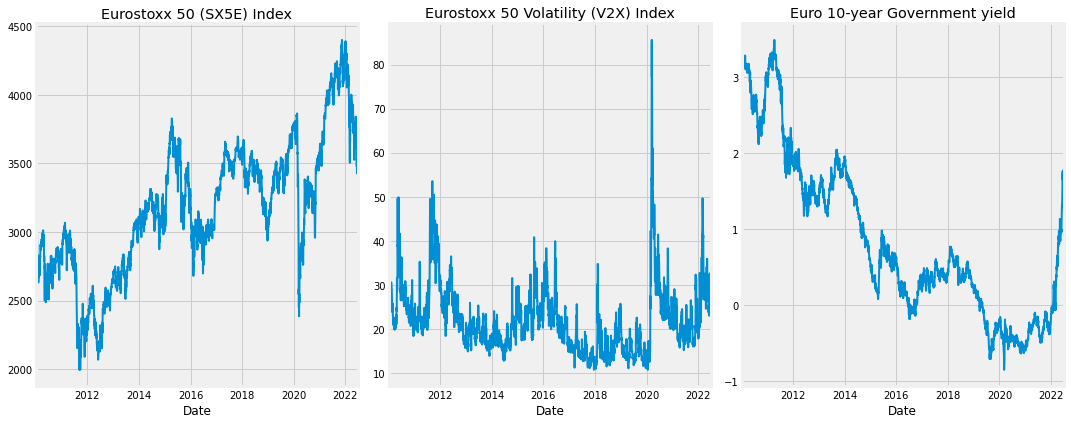

In [4]:
# Plot Eurostoxx 50 Index, V2X Index and EU 10Y Government yield
%matplotlib inline
fig, ax = plt.subplots(1,3, figsize=(15,6))
df['SX5E Index'].plot(title='Eurostoxx 50 (SX5E) Index', ax=ax[0], grid=True, linewidth=2)
df['V2X Index'].plot(title='Eurostoxx 50 Volatility (V2X) Index', ax=ax[1], grid=True, linewidth=2)
df['GECU10YR Index'].plot(title='Euro 10-year Government yield', ax=ax[2], grid=True, linewidth=2)
plt.tight_layout()

### Feature creation

**Features (also called predictors) are the independent variables which are used to determine the value of the target variable (the dependent variable we aim to predict)**.

#### Backward-looking features

Now that we have a fair understanding of the behavior of the Eurostoxx 50 Index and its related implied volatility Index (V2X Index),over the past 10 years, **we start building lagged features based on our 8 underlying financial quantities**. In particular, we will take as additional new features the 2, 3, 5 (1 week), 10 (2 weeks), 21 (1 month), 93 (3 months), 181 (6 months) and 252 (1 year) daily lagged values of:
- **For the Eurostoxx 50 Index, the V2X Index as well as oil and wheat prices**: Value change, Momentum, Exponential Moving Average (EMA), Volatility, and Upper / Lower Bollinger bands
- **EU 2, 5 and 10-year Government yields as well as EURIBOR 6 months**: Momentum, Exponential Moving Average (EMA), and Upper / Lower Bollinger bands

In [5]:
# Define set of predictors
predictors_1 = ['SX5E Index','V2X Index','CO1 Comdty','W 1 COMB Comdty']
predictors_2 = ['GECU2YR Index','GECU5YR Index','GECU10YR Index','EUR006M Index']
# Creation of model features
def create_features(df):
    # Calculate daily log returns
    df['Return'] = np.log(df['SX5E Index']).diff()
    for predictor_1 in predictors_1:
        df[str(predictor_1)+'_Return'] = np.log(df[predictor_1]).diff()
        # Create time-lagged features for Eurostoxx 50 Index
        for r in [2,3,5,10,21,93,181,252]:   # r: number of lagged days
            df[str(predictor_1)+'_Return_'+str(r)+'d'] = df[str(predictor_1)+'_Return'].rolling(r).sum()
            df[str(predictor_1)+'_Momentum_'+str(r)+'d'] = df[predictor_1]-df[predictor_1].shift(periods=r)
            df[str(predictor_1)+'_EMA_'+str(r)+'d'] = df[predictor_1].ewm(r, adjust=False).mean()
            df[str(predictor_1)+'_Volatility_'+str(r)+'d'] = df[str(predictor_1)+'_Return'].rolling(r).std()
            # Bollinger bands
            multiplier = 2
            df[str(predictor_1)+'_UpperBand_'+str(r)+'d'] = df[predictor_1].rolling(r).mean() + df[predictor_1].rolling(r).std() * multiplier
            df[str(predictor_1)+'_LowerBand_'+str(r)+'d'] = df[predictor_1].rolling(r).mean() - df[predictor_1].rolling(r).std() * multiplier
       
    for predictor_2 in predictors_2:
        # Create time-lagged features for Eurostoxx 50 Index
        for r in [2,3,5,10,21,93,181,252]:   # r: number of lagged days
            df[str(predictor_2)+'_Momentum_'+str(r)+'d'] = df[predictor_2]-df[predictor_2].shift(periods=r)
            df[str(predictor_2)+'_EMA_'+str(r)+'d'] = df[predictor_2].ewm(r, adjust=False).mean()
            # Bollinger bands
            multiplier = 2
            df[str(predictor_2)+'_UpperBand_'+str(r)+'d'] = df[predictor_2].rolling(r).mean() + df[predictor_2].rolling(r).std() * multiplier
            df[str(predictor_2)+'_LowerBand_'+str(r)+'d'] = df[predictor_2].rolling(r).mean() - df[predictor_2].rolling(r).std() * multiplier
    # Drop NaN values
    df.dropna()
    return df

We remove all NA values which result from the creation of lagged features from the dataframe. At this stage, we have more than 11 years of data (3,007 daily prices), for 333 different features.

In [6]:
create_features(df)
df = df.dropna()
print(df.shape)
df

(3007, 333)


SX5E Index  V2X Index  GECU2YR Index  GECU5YR Index  \
Date                                                              
2010-12-22     2869.63    18.5947          0.953          1.892   
2010-12-23     2864.52    19.5693          0.940          1.895   
2010-12-24     2861.94    19.5693          0.943          1.895   
2010-12-27     2826.51    22.5773          0.948          1.939   
2010-12-28     2824.30    22.5709          0.891          1.883   
...                ...        ...            ...            ...   
2022-06-24     3533.17    27.7689          0.813          1.163   
2022-06-27     3538.88    27.0179          0.905          1.289   
2022-06-28     3549.29    26.6834          0.957          1.433   
2022-06-29     3514.32    28.1127          0.838          1.283   
2022-06-30     3454.86    29.7804          0.649          1.067   

            GECU10YR Index  EUR006M Index  CO1 Comdty  W 1 COMB Comdty  \
Date                                                                     
2010-12-22           2.952          1.253       93.65           783.50   
2010-12-23           2.977          1.248       94.25           783.00   
2010-12-24           2.982          1.243       93.77           783.00   
2010-12-27           3.029          1.241       93.85           780.25   
2010-12-28           2.976          1.240       94.38           798.25   
...                    ...            ...         ...              ...   
2022-06-24           1.442          0.223      113.12           923.75   
2022-06-27           1.547          0.223      115.09           904.00   
2022-06-28           1.628          0.225      117.98           921.25   
2022-06-29           1.519          0.278      116.26           915.50   
2022-06-30           1.336          0.263      114.81           868.75   

              Return  SX5E Index_Return  ...  EUR006M Index_UpperBand_93d  \
Date                                     ...                                
2010-12-22 -0.002562          -0.002562  ...                     1.323803   
2010-12-23 -0.001782          -0.001782  ...                     1.324459   
2010-12-24 -0.000901          -0.000901  ...                     1.324942   
2010-12-27 -0.012457          -0.012457  ...                     1.325342   
2010-12-28 -0.000782          -0.000782  ...                     1.325669   
...              ...                ...  ...                          ...   
2022-06-24  0.027803           0.027803  ...                     0.221198   
2022-06-27  0.001615           0.001615  ...                     0.235406   
2022-06-28  0.002937           0.002937  ...                     0.248912   
2022-06-29 -0.009902          -0.009902  ...                     0.264526   
2022-06-30 -0.017064          -0.017064  ...                     0.278726   

            EUR006M Index_LowerBand_93d  EUR006M Index_Momentum_181d  \
Date                                                                   
2010-12-22                     1.094498                        0.300   
2010-12-23                     1.095950                        0.294   
2010-12-24                     1.097488                        0.289   
2010-12-27                     1.099066                        0.287   
2010-12-28                     1.100719                        0.287   
...                                 ...                          ...   
2022-06-24                    -0.674553                        0.746   
2022-06-27                    -0.674052                        0.751   
2022-06-28                    -0.672439                        0.752   
2022-06-29                    -0.671601                        0.802   
2022-06-30                    -0.669780                        0.790   

            EUR006M Index_EMA_181d  EUR006M Index_UpperBand_181d  \
Date                                                               
2010-12-22                1.091492                      1.339879   
2010-12-23                1.092352

#### Forward-looking features

Until now, we only have, with the lagged features built in 1.2.1, a backward-looking view - to the exception of the V2X Index. In other terms, we assume that past observations carry all the necessary information to make predictions ahead in time. For that reason, we complement the feature set with GARCH Eurostoxx 50 volatility predictions 1 day, 5 days and 10 days ahead in time, based on the past 60 observations of Eurostoxx 50 daily prices.

In [7]:
# GARCH forecasts
garch_1 = []
garch_5 = []
garch_10 = []
for i in range(df.shape[0]):
    returns = df['Return'][i:i+60]
    g1 = arch_model(returns, vol='GARCH', mean='Zero', p=1, o=0, q=1, dist='Normal')
    model = g1.fit()
    yhat_1 = model.forecast(horizon=1)
    yhat_5 = model.forecast(horizon=5)
    yhat_10 = model.forecast(horizon=10)
    values_1 = np.sqrt(yhat_1.variance.values[-1])*100*np.sqrt(252)
    values_5 = np.sqrt(yhat_5.variance.values[-1])*100*np.sqrt(252)
    values_10 = np.sqrt(yhat_10.variance.values[-1])*100*np.sqrt(252)
    forecast_1 = values_1[-1]
    forecast_5 = values_5[-1]
    forecast_10 = values_10[-1]
    garch_1.append(forecast_1)
    garch_5.append(forecast_5)
    garch_10.append(forecast_10)

Iteration:      1,   Func. Count:      5,   Neg. LLF: -162.3343186349692
Iteration:      2,   Func. Count:     12,   Neg. LLF: -160.54701012111445
Iteration:      3,   Func. Count:     18,   Neg. LLF: -178.9135378895561
Iteration:      4,   Func. Count:     25,   Neg. LLF: -194.56324136027945
Iteration:      5,   Func. Count:     30,   Neg. LLF: -194.60466177217913
Iteration:      6,   Func. Count:     34,   Neg. LLF: -194.60465793587827
Optimization terminated successfully    (Exit mode 0)
            Current function value: -194.6046617721714
            Iterations: 6
            Function evaluations: 44
            Gradient evaluations: 6
Iteration:      1,   Func. Count:      5,   Neg. LLF: -144.6628390108596
Iteration:      2,   Func. Count:     12,   Neg. LLF: -184.24382254345318
Iteration:      3,   Func. Count:     18,   Neg. LLF: -192.7375887788091
Iteration:      4,   Func. Count:     23,   Neg. LLF: -192.80144369222126
Iteration:      5,   Func. Count:     29,   Neg. LLF: -1

Iteration:      1,   Func. Count:      5,   Neg. LLF: 27492.58407561982
Iteration:      2,   Func. Count:     12,   Neg. LLF: -192.07212613667565
Iteration:      3,   Func. Count:     18,   Neg. LLF: -188.4881922489788
Iteration:      4,   Func. Count:     23,   Neg. LLF: -190.98595426910336
Iteration:      5,   Func. Count:     29,   Neg. LLF: -192.37026384681317
Iteration:      6,   Func. Count:     35,   Neg. LLF: -194.0378650402114
Iteration:      7,   Func. Count:     39,   Neg. LLF: -194.03802395373862
Iteration:      8,   Func. Count:     42,   Neg. LLF: -194.03802395369652
Optimization terminated successfully    (Exit mode 0)
            Current function value: -194.03802395373862
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8
Iteration:      1,   Func. Count:      5,   Neg. LLF: 32394115.1621962
Iteration:      2,   Func. Count:     12,   Neg. LLF: -192.86024785605744
Iteration:      3,   Func. Count:     18,   Neg. LLF: -189

Iteration:      3,   Func. Count:     19,   Neg. LLF: -187.8592965289387
Iteration:      4,   Func. Count:     24,   Neg. LLF: -187.9455835211403
Iteration:      5,   Func. Count:     30,   Neg. LLF: -189.9764734352383
Iteration:      6,   Func. Count:     35,   Neg. LLF: -189.97684652850404
Iteration:      7,   Func. Count:     38,   Neg. LLF: -189.97684652849844
Optimization terminated successfully    (Exit mode 0)
            Current function value: -189.97684652850404
            Iterations: 7
            Function evaluations: 38
            Gradient evaluations: 7
Iteration:      1,   Func. Count:      5,   Neg. LLF: -99.59133457172003
Iteration:      2,   Func. Count:     13,   Neg. LLF: -188.9841769164214
Iteration:      3,   Func. Count:     18,   Neg. LLF: -190.32208400470486
Iteration:      4,   Func. Count:     24,   Neg. LLF: -188.3018070961906
Iteration:      5,   Func. Count:     30,   Neg. LLF: -192.02053921503938
Iteration:      6,   Func. Count:     33,   Neg. LLF: -19

Iteration:      1,   Func. Count:      4,   Neg. LLF: -188.38035066520882
Optimization terminated successfully    (Exit mode 0)
            Current function value: -188.38035065772445
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: -130.73037266646398
Iteration:      2,   Func. Count:     11,   Neg. LLF: -187.2479913378798
Iteration:      3,   Func. Count:     16,   Neg. LLF: -184.6116256532883
Iteration:      4,   Func. Count:     22,   Neg. LLF: 1217.1650439952198
Iteration:      5,   Func. Count:     28,   Neg. LLF: -185.6934608919596
Iteration:      6,   Func. Count:     33,   Neg. LLF: -185.51498009862644
Iteration:      7,   Func. Count:     39,   Neg. LLF: -188.28827177293007
Iteration:      8,   Func. Count:     43,   Neg. LLF: -188.28831909349606
Iteration:      9,   Func. Count:     46,   Neg. LLF: -188.28831909347613
Optimization terminated successfully    (Exit mode 0)
  

Optimization terminated successfully    (Exit mode 0)
            Current function value: -189.7496084368263
            Iterations: 6
            Function evaluations: 45
            Gradient evaluations: 6
Iteration:      1,   Func. Count:      5,   Neg. LLF: -192.14461285519968
Iteration:      2,   Func. Count:     10,   Neg. LLF: -147.96933830000768
Iteration:      3,   Func. Count:     18,   Neg. LLF: -65.29751338832952
Iteration:      4,   Func. Count:     26,   Neg. LLF: -192.62521735195028
Iteration:      5,   Func. Count:     30,   Neg. LLF: -191.49836985704053
Iteration:      6,   Func. Count:     35,   Neg. LLF: -192.75759776097956
Iteration:      7,   Func. Count:     39,   Neg. LLF: -192.759767814267
Optimization terminated successfully    (Exit mode 0)
            Current function value: -192.759767814267
            Iterations: 8
            Function evaluations: 39
            Gradient evaluations: 7
Iteration:      1,   Func. Count:      5,   Neg. LLF: -57.385097909008

Iteration:      1,   Func. Count:      5,   Neg. LLF: -65.38247355146613
Iteration:      2,   Func. Count:     13,   Neg. LLF: -185.0614386543692
Iteration:      3,   Func. Count:     17,   Neg. LLF: -185.0627981548594
Iteration:      4,   Func. Count:     21,   Neg. LLF: -185.06593924191384
Iteration:      5,   Func. Count:     25,   Neg. LLF: -185.06685143278708
Iteration:      6,   Func. Count:     29,   Neg. LLF: -185.06705069391975
Iteration:      7,   Func. Count:     33,   Neg. LLF: -185.06697334665932
Optimization terminated successfully    (Exit mode 0)
            Current function value: -185.06705069391964
            Iterations: 7
            Function evaluations: 43
            Gradient evaluations: 7
Iteration:      1,   Func. Count:      5,   Neg. LLF: -125.07046235841422
Optimization terminated successfully    (Exit mode 0)
            Current function value: -184.97928781938776
            Iterations: 1
            Function evaluations: 10
            Gradient evaluati

Iteration:      2,   Func. Count:     10,   Neg. LLF: -179.12592783379085
Iteration:      3,   Func. Count:     15,   Neg. LLF: -135.12651961106286
Iteration:      4,   Func. Count:     23,   Neg. LLF: -179.84279504562681
Optimization terminated successfully    (Exit mode 0)
            Current function value: -179.8427950855256
            Iterations: 8
            Function evaluations: 23
            Gradient evaluations: 4
Iteration:      1,   Func. Count:      5,   Neg. LLF: -179.2921181026617
Iteration:      2,   Func. Count:     10,   Neg. LLF: -135.186927870344
Iteration:      3,   Func. Count:     19,   Neg. LLF: -179.29386515630182
Iteration:      4,   Func. Count:     24,   Neg. LLF: -135.186927870344
Iteration:      5,   Func. Count:     33,   Neg. LLF: -48.86870375016217
Iteration:      6,   Func. Count:     42,   Neg. LLF: -180.099217449842
Iteration:      7,   Func. Count:     46,   Neg. LLF: -45.92145952104564
Optimization terminated successfully    (Exit mode 0)
       

C:\Users\zacha\anaconda3\envs\pythonlab\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\zacha\anaconda3\envs\pythonlab\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      3,   Func. Count:     20,   Neg. LLF: -163.41890364411915
Iteration:      4,   Func. Count:     27,   Neg. LLF: -171.06329736112235
Iteration:      5,   Func. Count:     31,   Neg. LLF: -170.7591161042741
Iteration:      6,   Func. Count:     36,   Neg. LLF: -171.19139280816466
Iteration:      7,   Func. Count:     40,   Neg. LLF: -171.29417204746997
Iteration:      8,   Func. Count:     44,   Neg. LLF: -171.31368603095459
Optimization terminated successfully    (Exit mode 0)
            Current function value: -171.31368603095459
            Iterations: 8
            Function evaluations: 44
            Gradient evaluations: 8
Iteration:      1,   Func. Count:      5,   Neg. LLF: -154.12456162537174
Iteration:      2,   Func. Count:     10,   Neg. LLF: -27.242199501307034
Iteration:      3,   Func. Count:     18,   Neg. LLF: -134.21561438922313
Iteration:      4,   Func. Count:     24,   Neg. LLF: -165.5667622012101
Iteration:      5,   Func. Count:     27,   Neg. LLF:

Iteration:      7,   Func. Count:     35,   Neg. LLF: -156.80596996989422
Iteration:      8,   Func. Count:     39,   Neg. LLF: -156.80598869600698
Iteration:      9,   Func. Count:     43,   Neg. LLF: -156.80598808687134
Optimization terminated successfully    (Exit mode 0)
            Current function value: -156.8059888275079
            Iterations: 9
            Function evaluations: 45
            Gradient evaluations: 9
Iteration:      1,   Func. Count:      5,   Neg. LLF: -93.93239682169308
Iteration:      2,   Func. Count:     11,   Neg. LLF: -154.40246069205554
Iteration:      3,   Func. Count:     16,   Neg. LLF: -144.81199884109284
Iteration:      4,   Func. Count:     21,   Neg. LLF: -122.33647490308795
Iteration:      5,   Func. Count:     29,   Neg. LLF: -92.82983728211937
Iteration:      6,   Func. Count:     37,   Neg. LLF: -103.66135201002469
Iteration:      7,   Func. Count:     43,   Neg. LLF: -155.93909581842937
Iteration:      8,   Func. Count:     47,   Neg. LLF: 

Iteration:     10,   Func. Count:     50,   Neg. LLF: -144.26820084682382
Iteration:     11,   Func. Count:     55,   Neg. LLF: -144.27290844217967
Iteration:     12,   Func. Count:     60,   Neg. LLF: -144.3303823356333
Iteration:     13,   Func. Count:     65,   Neg. LLF: -144.4038725641778
Iteration:     14,   Func. Count:     69,   Neg. LLF: -144.4228186447062
Iteration:     15,   Func. Count:     73,   Neg. LLF: -144.5333243014289
Iteration:     16,   Func. Count:     77,   Neg. LLF: -144.54300654011294
Optimization terminated successfully    (Exit mode 0)
            Current function value: -144.54300654011294
            Iterations: 16
            Function evaluations: 77
            Gradient evaluations: 16
Iteration:      1,   Func. Count:      5,   Neg. LLF: -96.15517531233013
Iteration:      2,   Func. Count:     13,   Neg. LLF: -6.752413563654317
Iteration:      3,   Func. Count:     19,   Neg. LLF: -142.7109441264242
Iteration:      4,   Func. Count:     24,   Neg. LLF: -1

Iteration:      1,   Func. Count:      5,   Neg. LLF: 0.3935430425675466
Iteration:      2,   Func. Count:     14,   Neg. LLF: -133.51064858685888
Iteration:      3,   Func. Count:     19,   Neg. LLF: -133.93823265807424
Iteration:      4,   Func. Count:     23,   Neg. LLF: -133.19207418366142
Optimization terminated successfully    (Exit mode 0)
            Current function value: -133.94748707412714
            Iterations: 4
            Function evaluations: 24
            Gradient evaluations: 4
Iteration:      1,   Func. Count:      5,   Neg. LLF: -132.1089172602947
Iteration:      2,   Func. Count:     10,   Neg. LLF: -88.6960894689181
Iteration:      3,   Func. Count:     19,   Neg. LLF: -132.11111958985666
Iteration:      4,   Func. Count:     24,   Neg. LLF: -132.11111958985666
Iteration:      5,   Func. Count:     29,   Neg. LLF: 34684729.626501784
Iteration:      6,   Func. Count:     36,   Neg. LLF: -133.55835676615897
Iteration:      7,   Func. Count:     41,   Neg. LLF: -1

Iteration:      1,   Func. Count:      4,   Neg. LLF: -131.8091977308871
Optimization terminated successfully    (Exit mode 0)
            Current function value: -131.8091979715839
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: 8723.087686955412
Iteration:      2,   Func. Count:     11,   Neg. LLF: -126.6405031734603
Iteration:      3,   Func. Count:     16,   Neg. LLF: -132.24162580102353
Iteration:      4,   Func. Count:     20,   Neg. LLF: 29560824.88182731
Iteration:      5,   Func. Count:     28,   Neg. LLF: -131.99197895211594
Iteration:      6,   Func. Count:     35,   Neg. LLF: -132.22828707506105
Optimization terminated successfully    (Exit mode 0)
            Current function value: -132.2431007493251
            Iterations: 7
            Function evaluations: 45
            Gradient evaluations: 6
Iteration:      1,   Func. Count:      5,   Neg. LLF: 2152.135423761755
I

Iteration:      4,   Func. Count:     21,   Neg. LLF: -135.17486315068072
Iteration:      5,   Func. Count:     25,   Neg. LLF: -135.21174875128116
Iteration:      6,   Func. Count:     29,   Neg. LLF: 28805604.074083548
Iteration:      7,   Func. Count:     36,   Neg. LLF: -135.2119349187998
Optimization terminated successfully    (Exit mode 0)
            Current function value: -135.21193491946033
            Iterations: 11
            Function evaluations: 36
            Gradient evaluations: 7
Iteration:      1,   Func. Count:      4,   Neg. LLF: -135.0244159292283
Optimization terminated successfully    (Exit mode 0)
            Current function value: -135.02441608617016
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: 28338884.179202516
Iteration:      2,   Func. Count:     11,   Neg. LLF: -134.88039915349125
Iteration:      3,   Func. Count:     15,   Neg. LLF: -109.395195094

Optimization terminated successfully    (Exit mode 0)
            Current function value: -138.8036073930236
            Iterations: 18
            Function evaluations: 99
            Gradient evaluations: 18
Iteration:      1,   Func. Count:      4,   Neg. LLF: -138.97020469269677
Optimization terminated successfully    (Exit mode 0)
            Current function value: -138.97020496849922
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: 28457760.515401203
Iteration:      2,   Func. Count:     11,   Neg. LLF: -123.50546081736066
Iteration:      3,   Func. Count:     16,   Neg. LLF: -133.75632195127966
Iteration:      4,   Func. Count:     21,   Neg. LLF: -136.97706938196444
Iteration:      5,   Func. Count:     26,   Neg. LLF: -138.47539547930248
Iteration:      6,   Func. Count:     31,   Neg. LLF: -139.11289051882332
Iteration:      7,   Func. Count:     35,   Neg. LLF: -137.915420

Iteration:      6,   Func. Count:     30,   Neg. LLF: -147.23641983310415
Iteration:      7,   Func. Count:     34,   Neg. LLF: -147.2364228627697
Iteration:      8,   Func. Count:     37,   Neg. LLF: -147.2364228627661
Optimization terminated successfully    (Exit mode 0)
            Current function value: -147.2364228627697
            Iterations: 8
            Function evaluations: 37
            Gradient evaluations: 8
Iteration:      1,   Func. Count:      5,   Neg. LLF: -13.382770655731052
Iteration:      2,   Func. Count:     13,   Neg. LLF: -147.21475968151285
Iteration:      3,   Func. Count:     17,   Neg. LLF: -147.2147648737701
Optimization terminated successfully    (Exit mode 0)
            Current function value: -147.2147648737701
            Iterations: 3
            Function evaluations: 17
            Gradient evaluations: 3
Iteration:      1,   Func. Count:      5,   Neg. LLF: 27755535.374241807
Iteration:      2,   Func. Count:     12,   Neg. LLF: -147.47966523504

Iteration:      1,   Func. Count:      4,   Neg. LLF: -163.54754256869876
Optimization terminated successfully    (Exit mode 0)
            Current function value: -163.54754378181752
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: 24538056.064120553
Iteration:      2,   Func. Count:     11,   Neg. LLF: -35.44283737418689
Iteration:      3,   Func. Count:     19,   Neg. LLF: -166.03786203326518
Iteration:      4,   Func. Count:     23,   Neg. LLF: -163.83704848131862
Iteration:      5,   Func. Count:     28,   Neg. LLF: -166.4610116235347
Iteration:      6,   Func. Count:     32,   Neg. LLF: -166.46114995370414
Iteration:      7,   Func. Count:     35,   Neg. LLF: -166.46114995462065
Optimization terminated successfully    (Exit mode 0)
            Current function value: -166.46114995370414
            Iterations: 8
            Function evaluations: 35
            Gradient evaluatio

Iteration:      1,   Func. Count:      4,   Neg. LLF: -181.04336241383402
Optimization terminated successfully    (Exit mode 0)
            Current function value: -181.04336252596983
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -181.442124677858
Optimization terminated successfully    (Exit mode 0)
            Current function value: -181.44212484321054
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: 31359598.542564
Iteration:      2,   Func. Count:     11,   Neg. LLF: -180.69675157196988
Iteration:      3,   Func. Count:     16,   Neg. LLF: -136.84481545825633
Iteration:      4,   Func. Count:     24,   Neg. LLF: -180.7532121212252
Iteration:      5,   Func. Count:     29,   Neg. LLF: -180.7532121212252
Iteration:      6,   Func. Count:     33,   Neg. LLF: -181.7505381276993
O

Iteration:      2,   Func. Count:     11,   Neg. LLF: -147.64861386550453
Iteration:      3,   Func. Count:     16,   Neg. LLF: -186.6770869629694
Iteration:      4,   Func. Count:     20,   Neg. LLF: -55.72341038978533
Iteration:      5,   Func. Count:     28,   Neg. LLF: -186.29747688020402
Iteration:      6,   Func. Count:     33,   Neg. LLF: -186.54914661399184
Iteration:      7,   Func. Count:     38,   Neg. LLF: -186.6673459226724
Iteration:      8,   Func. Count:     43,   Neg. LLF: -186.68056686411646
Optimization terminated successfully    (Exit mode 0)
            Current function value: -186.6824031251494
            Iterations: 9
            Function evaluations: 53
            Gradient evaluations: 8
Iteration:      1,   Func. Count:      5,   Neg. LLF: -64.87496292523805
Iteration:      2,   Func. Count:     12,   Neg. LLF: -188.07643699687253
Iteration:      3,   Func. Count:     17,   Neg. LLF: -182.66805749792687
Iteration:      4,   Func. Count:     22,   Neg. LLF: -1

C:\Users\zacha\anaconda3\envs\pythonlab\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\zacha\anaconda3\envs\pythonlab\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\zacha\anaconda3\envs\pythonlab\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:      5,   Neg. LLF: -180.5802461568785
Iteration:      2,   Func. Count:     10,   Neg. LLF: -137.40949446343845
Iteration:      3,   Func. Count:     18,   Neg. LLF: -181.98974070254465
Optimization terminated successfully    (Exit mode 0)
            Current function value: -181.98974076841367
            Iterations: 7
            Function evaluations: 18
            Gradient evaluations: 3
Iteration:      1,   Func. Count:      5,   Neg. LLF: -180.9756554501097
Iteration:      2,   Func. Count:     10,   Neg. LLF: -137.27968089956235
Iteration:      3,   Func. Count:     19,   Neg. LLF: -181.00880811456906
Iteration:      4,   Func. Count:     24,   Neg. LLF: -181.00880811456906
Iteration:      5,   Func. Count:     28,   Neg. LLF: -182.0268075133226
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -182.026807420635
            Iterations: 5
            Function evaluations: 28
            Gradient evaluations

C:\Users\zacha\anaconda3\envs\pythonlab\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\zacha\anaconda3\envs\pythonlab\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\zacha\anaconda3\envs\pythonlab\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:      5,   Neg. LLF: -172.62709265705433
Iteration:      2,   Func. Count:     10,   Neg. LLF: -133.43897859974572
Iteration:      3,   Func. Count:     18,   Neg. LLF: -177.27189474916804
Optimization terminated successfully    (Exit mode 0)
            Current function value: -177.27189469749558
            Iterations: 7
            Function evaluations: 18
            Gradient evaluations: 3
Iteration:      1,   Func. Count:      5,   Neg. LLF: -170.74949527378814
Iteration:      2,   Func. Count:     10,   Neg. LLF: -131.0268334692614
Iteration:      3,   Func. Count:     19,   Neg. LLF: -170.79798809003088
Iteration:      4,   Func. Count:     23,   Neg. LLF: -176.95861488802637
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -176.95861482298332
            Iterations: 4
            Function evaluations: 23
            Gradient evaluations: 4
Iteration:      1,   Func. Count:      5,   Neg. LLF: -169.6374824

Iteration:      1,   Func. Count:      5,   Neg. LLF: -171.14994145045344
Iteration:      2,   Func. Count:     10,   Neg. LLF: -171.16353080596943
Iteration:      3,   Func. Count:     15,   Neg. LLF: -127.55158939484784
Iteration:      4,   Func. Count:     23,   Neg. LLF: -172.43828519934027
Optimization terminated successfully    (Exit mode 0)
            Current function value: -172.43828536672456
            Iterations: 8
            Function evaluations: 23
            Gradient evaluations: 4
Iteration:      1,   Func. Count:      5,   Neg. LLF: -171.0695745814752
Iteration:      2,   Func. Count:     10,   Neg. LLF: -127.17604149388725
Iteration:      3,   Func. Count:     19,   Neg. LLF: 34296738.526735745
Iteration:      4,   Func. Count:     26,   Neg. LLF: -172.01901813782996
Iteration:      5,   Func. Count:     29,   Neg. LLF: -172.0190188336465
Optimization terminated successfully    (Exit mode 0)
            Current function value: -172.01901813782996
            Iterat

Optimization terminated successfully    (Exit mode 0)
            Current function value: -170.54230471580132
            Iterations: 1
            Function evaluations: 15
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: -36.69795265779984
Iteration:      2,   Func. Count:     13,   Neg. LLF: -170.44750080344804
Iteration:      3,   Func. Count:     20,   Neg. LLF: -170.62006687746828
Iteration:      4,   Func. Count:     24,   Neg. LLF: -170.58994266090716
Iteration:      5,   Func. Count:     29,   Neg. LLF: -170.62129069849502
Iteration:      6,   Func. Count:     34,   Neg. LLF: -170.6217653549186
Optimization terminated successfully    (Exit mode 0)
            Current function value: -170.62190211488502
            Iterations: 6
            Function evaluations: 44
            Gradient evaluations: 6
Iteration:      1,   Func. Count:      5,   Neg. LLF: -41.1966294819482
Iteration:      2,   Func. Count:     12,   Neg. LLF: -169.418326878

Iteration:      1,   Func. Count:      4,   Neg. LLF: -166.70800050112504
Optimization terminated successfully    (Exit mode 0)
            Current function value: -166.70800073795624
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: 33743573.116529144
Iteration:      2,   Func. Count:     12,   Neg. LLF: -161.50477869847333
Iteration:      3,   Func. Count:     17,   Neg. LLF: -166.7808821233405
Iteration:      4,   Func. Count:     22,   Neg. LLF: -166.97968258798036
Iteration:      5,   Func. Count:     27,   Neg. LLF: -161.91403222389687
Iteration:      6,   Func. Count:     32,   Neg. LLF: -167.00535598710414
Iteration:      7,   Func. Count:     39,   Neg. LLF: -167.1616189710921
Iteration:      8,   Func. Count:     43,   Neg. LLF: -167.17527383882222
Iteration:      9,   Func. Count:     47,   Neg. LLF: 28138084.450569328
Iteration:     10,   Func. Count:     54,   Neg. LLF: -1

Iteration:      1,   Func. Count:      5,   Neg. LLF: -164.56826691831608
Iteration:      2,   Func. Count:     10,   Neg. LLF: -164.57698479776255
Iteration:      3,   Func. Count:     15,   Neg. LLF: -120.87774899704058
Iteration:      4,   Func. Count:     23,   Neg. LLF: -165.38362970256262
Optimization terminated successfully    (Exit mode 0)
            Current function value: -165.38362979567867
            Iterations: 8
            Function evaluations: 23
            Gradient evaluations: 4
Iteration:      1,   Func. Count:      5,   Neg. LLF: -164.33973594632883
Iteration:      2,   Func. Count:     10,   Neg. LLF: -120.74197967128079
Iteration:      3,   Func. Count:     19,   Neg. LLF: -164.34632076269227
Iteration:      4,   Func. Count:     24,   Neg. LLF: -153.47658683677162
Iteration:      5,   Func. Count:     29,   Neg. LLF: -165.3563307911775
Optimization terminated successfully    (Exit mode 0)
            Current function value: -165.3563308195095
            Itera

C:\Users\zacha\anaconda3\envs\pythonlab\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      8,   Func. Count:     45,   Neg. LLF: -162.55256885864551
Optimization terminated successfully    (Exit mode 0)
            Current function value: -162.55256917277293
            Iterations: 9
            Function evaluations: 45
            Gradient evaluations: 8
Iteration:      1,   Func. Count:      5,   Neg. LLF: -158.5730888258678
Iteration:      2,   Func. Count:     10,   Neg. LLF: -116.12256147190371
Iteration:      3,   Func. Count:     19,   Neg. LLF: 39707128.59728522
Iteration:      4,   Func. Count:     25,   Neg. LLF: -160.99845620726046
Optimization terminated successfully    (Exit mode 0)
            Current function value: -160.99845619829722
            Iterations: 8
            Function evaluations: 25
            Gradient evaluations: 4
Iteration:      1,   Func. Count:      5,   Neg. LLF: -159.11642808869505
Iteration:      2,   Func. Count:     10,   Neg. LLF: -116.43651244234339
Iteration:      3,   Func. Count:     18,   Neg. LLF: -161.23198749

C:\Users\zacha\anaconda3\envs\pythonlab\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      3,   Func. Count:     19,   Neg. LLF: -161.72215862107075
Iteration:      4,   Func. Count:     25,   Neg. LLF: -161.0837556383831
Iteration:      5,   Func. Count:     31,   Neg. LLF: -162.98196448771913
Iteration:      6,   Func. Count:     35,   Neg. LLF: -162.9819706394024
Iteration:      7,   Func. Count:     38,   Neg. LLF: -162.98197063940557
Optimization terminated successfully    (Exit mode 0)
            Current function value: -162.9819706394024
            Iterations: 7
            Function evaluations: 38
            Gradient evaluations: 7
Iteration:      1,   Func. Count:      5,   Neg. LLF: 31.823604932402734
Iteration:      2,   Func. Count:     11,   Neg. LLF: -151.66495289970308
Iteration:      3,   Func. Count:     17,   Neg. LLF: -162.80619306750282
Iteration:      4,   Func. Count:     24,   Neg. LLF: -162.6530762230747
Iteration:      5,   Func. Count:     29,   Neg. LLF: -162.85306589158512
Iteration:      6,   Func. Count:     33,   Neg. LLF: -1

Iteration:      2,   Func. Count:     13,   Neg. LLF: -161.92986050446717
Iteration:      3,   Func. Count:     18,   Neg. LLF: -161.96554620900687
Iteration:      4,   Func. Count:     23,   Neg. LLF: -162.02468099081477
Iteration:      5,   Func. Count:     27,   Neg. LLF: -158.49738964545298
Iteration:      6,   Func. Count:     33,   Neg. LLF: -162.03548637469785
Iteration:      7,   Func. Count:     37,   Neg. LLF: -162.0438012130328
Iteration:      8,   Func. Count:     41,   Neg. LLF: -162.04406476564165
Iteration:      9,   Func. Count:     45,   Neg. LLF: -162.04408254228775
Iteration:     10,   Func. Count:     48,   Neg. LLF: -162.0440825409014
Optimization terminated successfully    (Exit mode 0)
            Current function value: -162.04408254228775
            Iterations: 10
            Function evaluations: 48
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      5,   Neg. LLF: -95.42190648309993
Iteration:      2,   Func. Count:     13,   Neg. LLF

Iteration:      1,   Func. Count:      5,   Neg. LLF: -122.39619209888583
Iteration:      2,   Func. Count:     13,   Neg. LLF: -122.95067318734243
Iteration:      3,   Func. Count:     19,   Neg. LLF: -159.36639242858865
Iteration:      4,   Func. Count:     25,   Neg. LLF: -165.32856557302583
Iteration:      5,   Func. Count:     30,   Neg. LLF: -167.609755939178
Iteration:      6,   Func. Count:     34,   Neg. LLF: -167.60975940027015
Iteration:      7,   Func. Count:     37,   Neg. LLF: -167.6097594002493
Optimization terminated successfully    (Exit mode 0)
            Current function value: -167.60975940027015
            Iterations: 7
            Function evaluations: 37
            Gradient evaluations: 7
Iteration:      1,   Func. Count:      5,   Neg. LLF: -122.39852981260537
Iteration:      2,   Func. Count:     13,   Neg. LLF: -125.70457768727465
Iteration:      3,   Func. Count:     19,   Neg. LLF: -164.69129549659954
Iteration:      4,   Func. Count:     24,   Neg. LLF: 

Iteration:      1,   Func. Count:      5,   Neg. LLF: -49.86750020975708
Iteration:      2,   Func. Count:     14,   Neg. LLF: -183.92673860011345
Iteration:      3,   Func. Count:     19,   Neg. LLF: -181.64318676956484
Iteration:      4,   Func. Count:     24,   Neg. LLF: -184.25095838033403
Iteration:      5,   Func. Count:     29,   Neg. LLF: -166.8992625266579
Iteration:      6,   Func. Count:     35,   Neg. LLF: -184.452295795071
Iteration:      7,   Func. Count:     39,   Neg. LLF: -184.45235876298872
Iteration:      8,   Func. Count:     43,   Neg. LLF: -184.45237321272933
Iteration:      9,   Func. Count:     46,   Neg. LLF: -184.4523732124283
Optimization terminated successfully    (Exit mode 0)
            Current function value: -184.45237321272933
            Iterations: 9
            Function evaluations: 46
            Gradient evaluations: 9
Iteration:      1,   Func. Count:      5,   Neg. LLF: -182.1384816365781
Iteration:      2,   Func. Count:     10,   Neg. LLF: -18

Iteration:      2,   Func. Count:     12,   Neg. LLF: -179.08636764848842
Iteration:      3,   Func. Count:     17,   Neg. LLF: -155.5052609169145
Iteration:      4,   Func. Count:     25,   Neg. LLF: -179.04973717220713
Iteration:      5,   Func. Count:     30,   Neg. LLF: 30344488.56583078
Iteration:      6,   Func. Count:     37,   Neg. LLF: -178.87366082436571
Iteration:      7,   Func. Count:     42,   Neg. LLF: -178.9691330787372
Iteration:      8,   Func. Count:     47,   Neg. LLF: -178.77609373924818
Iteration:      9,   Func. Count:     53,   Neg. LLF: -178.81494221845293
Iteration:     10,   Func. Count:     60,   Neg. LLF: -179.44802807564264
Iteration:     11,   Func. Count:     64,   Neg. LLF: -178.65339428919012
Iteration:     12,   Func. Count:     73,   Neg. LLF: 30344488.56583078
Iteration:     13,   Func. Count:     79,   Neg. LLF: -179.49120317065638
Optimization terminated successfully    (Exit mode 0)
            Current function value: -179.49120318007112
        

Iteration:      1,   Func. Count:      5,   Neg. LLF: 24008467.71806102
Iteration:      2,   Func. Count:     11,   Neg. LLF: -116.8109396557414
Iteration:      3,   Func. Count:     17,   Neg. LLF: -195.554300341627
Optimization terminated successfully    (Exit mode 0)
            Current function value: -195.5543003222356
            Iterations: 7
            Function evaluations: 17
            Gradient evaluations: 3
Iteration:      1,   Func. Count:      4,   Neg. LLF: -197.0544466303069
Optimization terminated successfully    (Exit mode 0)
            Current function value: -197.05444721661993
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -198.1467429415094
Optimization terminated successfully    (Exit mode 0)
            Current function value: -198.14674283092435
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:   

Iteration:      1,   Func. Count:      4,   Neg. LLF: -203.7974993437627
Optimization terminated successfully    (Exit mode 0)
            Current function value: -203.79749987915497
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -205.14864735613628
Optimization terminated successfully    (Exit mode 0)
            Current function value: -205.14864781266394
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -205.56523251013957
Optimization terminated successfully    (Exit mode 0)
            Current function value: -205.56523308463477
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -206.42568367135303
Optimization terminated successfully    (Exit mode 0)
            Current functio

C:\Users\zacha\anaconda3\envs\pythonlab\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\zacha\anaconda3\envs\pythonlab\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\zacha\anaconda3\envs\pythonlab\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      2,   Func. Count:     10,   Neg. LLF: -199.99803366043648
Iteration:      3,   Func. Count:     15,   Neg. LLF: -159.843542167846
Iteration:      4,   Func. Count:     24,   Neg. LLF: -204.7539050472026
Optimization terminated successfully    (Exit mode 0)
            Current function value: -204.7539049236622
            Iterations: 8
            Function evaluations: 24
            Gradient evaluations: 4
Iteration:      1,   Func. Count:      5,   Neg. LLF: -199.6537536049793
Iteration:      2,   Func. Count:     10,   Neg. LLF: -200.2554169135448
Iteration:      3,   Func. Count:     15,   Neg. LLF: -200.2554169135448
Iteration:      4,   Func. Count:     19,   Neg. LLF: -203.9764653876126
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -203.97646472868973
            Iterations: 4
            Function evaluations: 19
            Gradient evaluations: 4
Iteration:      1,   Func. Count:      5,   Neg. LLF: -188.2286256830387


C:\Users\zacha\anaconda3\envs\pythonlab\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:      5,   Neg. LLF: -143.50483429711736
Iteration:      2,   Func. Count:     14,   Neg. LLF: 8179035.830006706
Iteration:      3,   Func. Count:     20,   Neg. LLF: -188.96849414699304
Iteration:      4,   Func. Count:     25,   Neg. LLF: -174.24152681121302
Iteration:      5,   Func. Count:     30,   Neg. LLF: -189.09649258200375
Iteration:      6,   Func. Count:     35,   Neg. LLF: -185.26883494997293
Iteration:      7,   Func. Count:     41,   Neg. LLF: -189.37280285079473
Iteration:      8,   Func. Count:     45,   Neg. LLF: -189.68624919903655
Iteration:      9,   Func. Count:     49,   Neg. LLF: -188.88216325618632
Iteration:     10,   Func. Count:     54,   Neg. LLF: -190.19802874314652
Iteration:     11,   Func. Count:     58,   Neg. LLF: -190.19981039445685
Optimization terminated successfully    (Exit mode 0)
            Current function value: -190.19981039445685
            Iterations: 11
            Function evaluations: 58
            Gr

Iteration:      2,   Func. Count:     10,   Neg. LLF: -185.7631523387147
Optimization terminated successfully    (Exit mode 0)
            Current function value: -185.76315202169775
            Iterations: 6
            Function evaluations: 10
            Gradient evaluations: 2
Iteration:      1,   Func. Count:      5,   Neg. LLF: -50.51843079172061
Iteration:      2,   Func. Count:     14,   Neg. LLF: -184.3325872018543
Iteration:      3,   Func. Count:     19,   Neg. LLF: -182.21519953482064
Iteration:      4,   Func. Count:     24,   Neg. LLF: -184.71355172130623
Iteration:      5,   Func. Count:     29,   Neg. LLF: -185.10839596792508
Iteration:      6,   Func. Count:     33,   Neg. LLF: -185.12554771768436
Iteration:      7,   Func. Count:     37,   Neg. LLF: -185.12696552814074
Iteration:      8,   Func. Count:     41,   Neg. LLF: -185.1267759996663
Optimization terminated successfully    (Exit mode 0)
            Current function value: -185.1269655454005
            Iteratio

Iteration:      2,   Func. Count:     11,   Neg. LLF: -173.4688371462171
Iteration:      3,   Func. Count:     16,   Neg. LLF: -173.4444627724315
Iteration:      4,   Func. Count:     21,   Neg. LLF: -176.54786634914765
Iteration:      5,   Func. Count:     25,   Neg. LLF: -176.21166000390988
Iteration:      6,   Func. Count:     30,   Neg. LLF: 16910735.134261187
Iteration:      7,   Func. Count:     37,   Neg. LLF: -176.48165626195242
Iteration:      8,   Func. Count:     42,   Neg. LLF: -176.21166000390988
Iteration:      9,   Func. Count:     47,   Neg. LLF: -176.21166000390988
Iteration:     10,   Func. Count:     51,   Neg. LLF: -176.56904294178838
Optimization terminated successfully    (Exit mode 0)
            Current function value: -176.56904296007772
            Iterations: 14
            Function evaluations: 51
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      4,   Neg. LLF: -176.45703466757084
Optimization terminated successfully    (Exit mode 0

Iteration:      1,   Func. Count:      4,   Neg. LLF: -188.8086351735934
Optimization terminated successfully    (Exit mode 0)
            Current function value: -188.80863529296232
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: 28635143.910498988
Iteration:      2,   Func. Count:     12,   Neg. LLF: -189.92719493423616
Iteration:      3,   Func. Count:     16,   Neg. LLF: -189.7545069227742
Iteration:      4,   Func. Count:     21,   Neg. LLF: -189.94247752608464
Iteration:      5,   Func. Count:     25,   Neg. LLF: -189.94235693745236
Optimization terminated successfully    (Exit mode 0)
            Current function value: -189.94248558010344
            Iterations: 5
            Function evaluations: 26
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      5,   Neg. LLF: -54.41024855561043
Iteration:      2,   Func. Count:     13,   Neg. LLF: -188.2696012931

Iteration:      9,   Func. Count:     45,   Neg. LLF: -186.18371867251497
Iteration:     10,   Func. Count:     49,   Neg. LLF: -186.18380987328104
Iteration:     11,   Func. Count:     52,   Neg. LLF: -186.1838098735276
Optimization terminated successfully    (Exit mode 0)
            Current function value: -186.18380987328104
            Iterations: 11
            Function evaluations: 52
            Gradient evaluations: 11
Iteration:      1,   Func. Count:      5,   Neg. LLF: -96.98455995752359
Iteration:      2,   Func. Count:     12,   Neg. LLF: -185.9076596496103
Iteration:      3,   Func. Count:     17,   Neg. LLF: -167.95385170779355
Iteration:      4,   Func. Count:     22,   Neg. LLF: -185.9912350793879
Iteration:      5,   Func. Count:     27,   Neg. LLF: -186.8128711284219
Iteration:      6,   Func. Count:     31,   Neg. LLF: -186.72984442803266
Optimization terminated successfully    (Exit mode 0)
            Current function value: -186.8128713074172
            Iterati

Iteration:      6,   Func. Count:     32,   Neg. LLF: -45.18422031532929
Optimization terminated successfully    (Exit mode 0)
            Current function value: -179.75465437723562
            Iterations: 7
            Function evaluations: 37
            Gradient evaluations: 6
Iteration:      1,   Func. Count:      5,   Neg. LLF: -177.17707467972772
Iteration:      2,   Func. Count:     10,   Neg. LLF: -133.20991386347725
Iteration:      3,   Func. Count:     19,   Neg. LLF: -177.17762494007204
Iteration:      4,   Func. Count:     24,   Neg. LLF: -177.17762494007204
Iteration:      5,   Func. Count:     29,   Neg. LLF: -133.20991386347725
Iteration:      6,   Func. Count:     37,   Neg. LLF: -177.17762494007204
Iteration:      7,   Func. Count:     42,   Neg. LLF: -177.17762494007204
Iteration:      8,   Func. Count:     47,   Neg. LLF: -177.17762494007204
Iteration:      9,   Func. Count:     52,   Neg. LLF: -133.20991386347725
Iteration:     10,   Func. Count:     61,   Neg. LLF

Iteration:      1,   Func. Count:      5,   Neg. LLF: 51.778883855582194
Iteration:      2,   Func. Count:     11,   Neg. LLF: -180.03513420935582
Iteration:      3,   Func. Count:     16,   Neg. LLF: -138.00355697711254
Iteration:      4,   Func. Count:     24,   Neg. LLF: -183.15027418786713
Optimization terminated successfully    (Exit mode 0)
            Current function value: -183.1502741959882
            Iterations: 8
            Function evaluations: 24
            Gradient evaluations: 4
Iteration:      1,   Func. Count:      5,   Neg. LLF: -161.87662905430363
Iteration:      2,   Func. Count:     11,   Neg. LLF: -104.57414966447111
Iteration:      3,   Func. Count:     17,   Neg. LLF: -182.96832472448304
Iteration:      4,   Func. Count:     21,   Neg. LLF: -182.03325278646946
Iteration:      5,   Func. Count:     27,   Neg. LLF: -167.4169331300797
Iteration:      6,   Func. Count:     32,   Neg. LLF: -182.97665116219267
Iteration:      7,   Func. Count:     36,   Neg. LLF: 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 24764644.297174565
Iteration:      2,   Func. Count:     11,   Neg. LLF: -183.4161212657161
Iteration:      3,   Func. Count:     15,   Neg. LLF: -186.46378461393007
Optimization terminated successfully    (Exit mode 0)
            Current function value: -186.46378474074643
            Iterations: 7
            Function evaluations: 15
            Gradient evaluations: 3
Iteration:      1,   Func. Count:      4,   Neg. LLF: -186.07340684618424
Optimization terminated successfully    (Exit mode 0)
            Current function value: -186.0734072387719
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -185.9245958121168
Optimization terminated successfully    (Exit mode 0)
            Current function value: -185.92459587031726
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration

Iteration:      1,   Func. Count:      4,   Neg. LLF: -192.43454131025078
Optimization terminated successfully    (Exit mode 0)
            Current function value: -192.43454152276595
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -194.53051233701035
Optimization terminated successfully    (Exit mode 0)
            Current function value: -194.53051232671072
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -194.32578927553797
Optimization terminated successfully    (Exit mode 0)
            Current function value: -194.3257893015699
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: 28218938.14680867
Iteration:      2,   Func. Count:     10,   Neg. LLF: -194.7578814242488
Optimizati

Optimization terminated successfully    (Exit mode 0)
            Current function value: -201.9684954719172
            Iterations: 1
            Function evaluations: 15
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: -201.1695300469882
Optimization terminated successfully    (Exit mode 0)
            Current function value: -201.45456874863348
            Iterations: 1
            Function evaluations: 15
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: -201.36198256531745
Iteration:      2,   Func. Count:     10,   Neg. LLF: -201.36199977134586
Iteration:      3,   Func. Count:     15,   Neg. LLF: -156.89947761065991
Iteration:      4,   Func. Count:     23,   Neg. LLF: -201.36199977134586
Iteration:      5,   Func. Count:     28,   Neg. LLF: -201.36199977134586
Optimization terminated successfully    (Exit mode 0)
            Current function value: -201.45102927306647
            Iterations: 5
    

Iteration:      2,   Func. Count:     12,   Neg. LLF: -212.2989232949349
Iteration:      3,   Func. Count:     16,   Neg. LLF: -211.58805648117536
Iteration:      4,   Func. Count:     21,   Neg. LLF: -211.35069250513922
Iteration:      5,   Func. Count:     26,   Neg. LLF: -212.1379520065739
Iteration:      6,   Func. Count:     31,   Neg. LLF: -212.1128478708796
Iteration:      7,   Func. Count:     36,   Neg. LLF: -212.1128478708796
Iteration:      8,   Func. Count:     41,   Neg. LLF: -111.51399425452179
Iteration:      9,   Func. Count:     49,   Neg. LLF: -211.60695718303168
Iteration:     10,   Func. Count:     54,   Neg. LLF: -211.6455728454713
Iteration:     11,   Func. Count:     59,   Neg. LLF: -212.38808201336226
Iteration:     12,   Func. Count:     63,   Neg. LLF: -211.88648083164884
Iteration:     13,   Func. Count:     68,   Neg. LLF: -191.2627026945368
Iteration:     14,   Func. Count:     73,   Neg. LLF: -211.66303753920397
Iteration:     15,   Func. Count:     78,   

C:\Users\zacha\anaconda3\envs\pythonlab\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:      5,   Neg. LLF: -117.36623505823253
Iteration:      2,   Func. Count:     13,   Neg. LLF: -204.84102216427016
Iteration:      3,   Func. Count:     16,   Neg. LLF: -204.8410217957683
Optimization terminated successfully    (Exit mode 0)
            Current function value: -204.84102216427016
            Iterations: 7
            Function evaluations: 16
            Gradient evaluations: 3
Iteration:      1,   Func. Count:      5,   Neg. LLF: -143.45555113262708
Optimization terminated successfully    (Exit mode 0)
            Current function value: -204.6945292793406
            Iterations: 1
            Function evaluations: 10
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: -113.07937241170029
Iteration:      2,   Func. Count:     13,   Neg. LLF: -204.11190766454635
Iteration:      3,   Func. Count:     19,   Neg. LLF: -204.13041858969865
Iteration:      4,   Func. Count:     23,   Neg. LLF: -204.1310922

Iteration:      1,   Func. Count:      5,   Neg. LLF: -203.2516741282399
Iteration:      2,   Func. Count:     10,   Neg. LLF: -159.83919194597905
Iteration:      3,   Func. Count:     18,   Neg. LLF: -204.67090183142128
Optimization terminated successfully    (Exit mode 0)
            Current function value: -204.67090186154167
            Iterations: 7
            Function evaluations: 18
            Gradient evaluations: 3
Iteration:      1,   Func. Count:      5,   Neg. LLF: -70.71674679125925
Iteration:      2,   Func. Count:     13,   Neg. LLF: -204.61481285139374
Iteration:      3,   Func. Count:     18,   Neg. LLF: -204.77522620972508
Iteration:      4,   Func. Count:     22,   Neg. LLF: 3475501.55119374
Iteration:      5,   Func. Count:     30,   Neg. LLF: -204.84574217684897
Iteration:      6,   Func. Count:     34,   Neg. LLF: -204.83611850215158
Iteration:      7,   Func. Count:     42,   Neg. LLF: -204.8308339649045
Iteration:      8,   Func. Count:     56,   Neg. LLF: -20

C:\Users\zacha\anaconda3\envs\pythonlab\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\zacha\anaconda3\envs\pythonlab\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:      5,   Neg. LLF: -197.17289528144144
Iteration:      2,   Func. Count:     10,   Neg. LLF: -154.72252180912017
Iteration:      3,   Func. Count:     19,   Neg. LLF: -197.38081193010854
Iteration:      4,   Func. Count:     24,   Neg. LLF: -197.38081193010854
Iteration:      5,   Func. Count:     29,   Neg. LLF: -197.38081193010854
Iteration:      6,   Func. Count:     33,   Neg. LLF: -199.67153389320865
Optimization terminated successfully    (Exit mode 0)
            Current function value: -199.67153398129759
            Iterations: 10
            Function evaluations: 33
            Gradient evaluations: 6
Iteration:      1,   Func. Count:      5,   Neg. LLF: -65.18765460341032
Iteration:      2,   Func. Count:     14,   Neg. LLF: -199.44933605434412
Iteration:      3,   Func. Count:     18,   Neg. LLF: -199.31548305377393
Optimization terminated successfully    (Exit mode 0)
            Current function value: -199.85273458607136
            Ite

Iteration:      2,   Func. Count:     12,   Neg. LLF: -195.84370118377856
Iteration:      3,   Func. Count:     16,   Neg. LLF: -195.8437569344045
Optimization terminated successfully    (Exit mode 0)
            Current function value: -195.8437569344045
            Iterations: 3
            Function evaluations: 16
            Gradient evaluations: 3
Iteration:      1,   Func. Count:      5,   Neg. LLF: -63.61156010011766
Iteration:      2,   Func. Count:     12,   Neg. LLF: -196.08614376716426
Iteration:      3,   Func. Count:     16,   Neg. LLF: -196.08624231033886
Optimization terminated successfully    (Exit mode 0)
            Current function value: -196.08624231033886
            Iterations: 3
            Function evaluations: 16
            Gradient evaluations: 3
Iteration:      1,   Func. Count:      5,   Neg. LLF: -107.58132421462399
Iteration:      2,   Func. Count:     13,   Neg. LLF: -196.14414446281933
Iteration:      3,   Func. Count:     17,   Neg. LLF: -196.14449838

Iteration:      1,   Func. Count:      5,   Neg. LLF: -190.93475371354654
Iteration:      2,   Func. Count:     10,   Neg. LLF: -149.59795456669073
Iteration:      3,   Func. Count:     20,   Neg. LLF: -191.3337185107055
Iteration:      4,   Func. Count:     25,   Neg. LLF: -149.59795456669073
Iteration:      5,   Func. Count:     34,   Neg. LLF: -191.3350696430377
Iteration:      6,   Func. Count:     39,   Neg. LLF: -191.3337185107055
Iteration:      7,   Func. Count:     44,   Neg. LLF: -149.59795456669073
Iteration:      8,   Func. Count:     53,   Neg. LLF: -191.3363777383152
Iteration:      9,   Func. Count:     58,   Neg. LLF: -191.3337185107055
Iteration:     10,   Func. Count:     63,   Neg. LLF: -149.59795456669073
Iteration:     11,   Func. Count:     72,   Neg. LLF: -191.3337185107055
Iteration:     12,   Func. Count:     77,   Neg. LLF: -149.59795456669073
Iteration:     13,   Func. Count:     86,   Neg. LLF: -191.3350357224232
Iteration:     14,   Func. Count:     91,   N

Iteration:      6,   Func. Count:     32,   Neg. LLF: -192.03679943992444
Iteration:      7,   Func. Count:     36,   Neg. LLF: -192.0375992305407
Iteration:      8,   Func. Count:     40,   Neg. LLF: -192.0376265985012
Iteration:      9,   Func. Count:     43,   Neg. LLF: -192.03762657105665
Optimization terminated successfully    (Exit mode 0)
            Current function value: -192.0376265985012
            Iterations: 9
            Function evaluations: 43
            Gradient evaluations: 9
Iteration:      1,   Func. Count:      5,   Neg. LLF: -149.82181684302836
Iteration:      2,   Func. Count:     12,   Neg. LLF: -191.87694619914672
Iteration:      3,   Func. Count:     17,   Neg. LLF: 1545334.3789525835
Iteration:      4,   Func. Count:     23,   Neg. LLF: -192.7268473239425
Iteration:      5,   Func. Count:     27,   Neg. LLF: -192.736057231252
Iteration:      6,   Func. Count:     31,   Neg. LLF: -192.74518135940085
Iteration:      7,   Func. Count:     35,   Neg. LLF: -192

Iteration:      2,   Func. Count:     11,   Neg. LLF: -151.75697224656116
Iteration:      3,   Func. Count:     17,   Neg. LLF: -191.31586487248094
Iteration:      4,   Func. Count:     23,   Neg. LLF: -194.46330989703273
Iteration:      5,   Func. Count:     27,   Neg. LLF: 2085.4563710853085
Iteration:      6,   Func. Count:     33,   Neg. LLF: -193.51924814385492
Iteration:      7,   Func. Count:     39,   Neg. LLF: -194.60144666731634
Iteration:      8,   Func. Count:     43,   Neg. LLF: -194.48760128384416
Iteration:      9,   Func. Count:     49,   Neg. LLF: 1832432.7878127366
Optimization terminated successfully    (Exit mode 0)
            Current function value: -194.6015087292953
            Iterations: 11
            Function evaluations: 53
            Gradient evaluations: 9
Iteration:      1,   Func. Count:      5,   Neg. LLF: -181.18935515396834
Iteration:      2,   Func. Count:     11,   Neg. LLF: 1710144.264177208
Iteration:      3,   Func. Count:     17,   Neg. LLF: -

Iteration:      1,   Func. Count:      5,   Neg. LLF: -152.30555929571418
Iteration:      2,   Func. Count:     12,   Neg. LLF: -194.2958087431246
Iteration:      3,   Func. Count:     17,   Neg. LLF: -177.94365937765636
Iteration:      4,   Func. Count:     23,   Neg. LLF: -195.42873265352821
Iteration:      5,   Func. Count:     27,   Neg. LLF: -195.44465753955214
Iteration:      6,   Func. Count:     31,   Neg. LLF: -195.45926327072303
Iteration:      7,   Func. Count:     35,   Neg. LLF: -195.46031131337972
Iteration:      8,   Func. Count:     39,   Neg. LLF: -195.46040527666827
Iteration:      9,   Func. Count:     43,   Neg. LLF: -195.46042317494852
Iteration:     10,   Func. Count:     46,   Neg. LLF: -195.46042315391827
Optimization terminated successfully    (Exit mode 0)
            Current function value: -195.46042317494852
            Iterations: 10
            Function evaluations: 46
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      5,   Neg. L

Iteration:      1,   Func. Count:      4,   Neg. LLF: -207.75056707234998
Optimization terminated successfully    (Exit mode 0)
            Current function value: -207.75056778439404
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -208.39303306278313
Optimization terminated successfully    (Exit mode 0)
            Current function value: -208.39303388688643
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -208.06235554876446
Optimization terminated successfully    (Exit mode 0)
            Current function value: -208.06235646049672
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: 24896745.907350283
Iteration:      2,   Func. Count:     11,   Neg. LLF: -165.66835395760293
Iterati

Iteration:      1,   Func. Count:      5,   Neg. LLF: 32175993.258985884
Iteration:      2,   Func. Count:     11,   Neg. LLF: -198.57281075828246
Iteration:      3,   Func. Count:     17,   Neg. LLF: -187.07553898815945
Iteration:      4,   Func. Count:     22,   Neg. LLF: -211.47425975619473
Optimization terminated successfully    (Exit mode 0)
            Current function value: -211.47425979723155
            Iterations: 8
            Function evaluations: 22
            Gradient evaluations: 4
Iteration:      1,   Func. Count:      5,   Neg. LLF: 8525.119265940994
Iteration:      2,   Func. Count:     11,   Neg. LLF: -206.202120821092
Iteration:      3,   Func. Count:     18,   Neg. LLF: -210.99188739018558
Iteration:      4,   Func. Count:     24,   Neg. LLF: -211.63199149546932
Iteration:      5,   Func. Count:     30,   Neg. LLF: -208.85198498002623
Optimization terminated successfully    (Exit mode 0)
            Current function value: -212.1152147072205
            Iteration

Iteration:      1,   Func. Count:      4,   Neg. LLF: -206.97510277761202
Optimization terminated successfully    (Exit mode 0)
            Current function value: -206.9751022928389
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: -70.78186089012685
Iteration:      2,   Func. Count:     14,   Neg. LLF: -202.22181679829546
Iteration:      3,   Func. Count:     20,   Neg. LLF: -179.42065458790393
Iteration:      4,   Func. Count:     26,   Neg. LLF: -206.59387318007367
Iteration:      5,   Func. Count:     31,   Neg. LLF: -196.1026096170439
Iteration:      6,   Func. Count:     37,   Neg. LLF: -206.6831220611509
Iteration:      7,   Func. Count:     42,   Neg. LLF: -206.70475737276777
Iteration:      8,   Func. Count:     47,   Neg. LLF: -206.7048709357708
Optimization terminated successfully    (Exit mode 0)
            Current function value: -206.70502249158608
            Iteration

Optimization terminated successfully    (Exit mode 0)
            Current function value: -197.83141441723282
            Iterations: 10
            Function evaluations: 33
            Gradient evaluations: 6
Iteration:      1,   Func. Count:      5,   Neg. LLF: -193.9257567748927
Iteration:      2,   Func. Count:     10,   Neg. LLF: -152.52096447409045
Iteration:      3,   Func. Count:     19,   Neg. LLF: -194.0319493106692
Iteration:      4,   Func. Count:     24,   Neg. LLF: -194.03185086862104
Iteration:      5,   Func. Count:     29,   Neg. LLF: -152.52096447409045
Iteration:      6,   Func. Count:     38,   Neg. LLF: -194.0318508773279
Iteration:      7,   Func. Count:     43,   Neg. LLF: -152.52096447409045
Iteration:      8,   Func. Count:     50,   Neg. LLF: -198.2604705685923
Optimization terminated successfully    (Exit mode 0)
            Current function value: -198.26047051127634
            Iterations: 12
            Function evaluations: 50
            Gradient evaluat

Iteration:      1,   Func. Count:      5,   Neg. LLF: -61.90491280280424
Iteration:      2,   Func. Count:     12,   Neg. LLF: -195.71183905066795
Iteration:      3,   Func. Count:     15,   Neg. LLF: -195.71183905043608
Optimization terminated successfully    (Exit mode 0)
            Current function value: -195.71183905066795
            Iterations: 3
            Function evaluations: 15
            Gradient evaluations: 3
Iteration:      1,   Func. Count:      4,   Neg. LLF: -195.71004976988425
Optimization terminated successfully    (Exit mode 0)
            Current function value: -195.71004984926137
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -195.67579449440763
Optimization terminated successfully    (Exit mode 0)
            Current function value: -195.6757946656628
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iterati

Iteration:      6,   Func. Count:     31,   Neg. LLF: -187.05563569349536
Optimization terminated successfully    (Exit mode 0)
            Current function value: -187.05563561862988
            Iterations: 10
            Function evaluations: 31
            Gradient evaluations: 6
Iteration:      1,   Func. Count:      5,   Neg. LLF: -52.24722428253711
Iteration:      2,   Func. Count:     13,   Neg. LLF: -186.9685411985951
Iteration:      3,   Func. Count:     17,   Neg. LLF: 38466155.30205815
Iteration:      4,   Func. Count:     24,   Neg. LLF: -185.28484368260433
Iteration:      5,   Func. Count:     29,   Neg. LLF: -185.26401700567376
Optimization terminated successfully    (Exit mode 0)
            Current function value: -187.0248079782306
            Iterations: 6
            Function evaluations: 39
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      5,   Neg. LLF: -138.95505418434126
Iteration:      2,   Func. Count:     14,   Neg. LLF: -109.783647083

C:\Users\zacha\anaconda3\envs\pythonlab\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:      5,   Neg. LLF: 1044.357466232097
Iteration:      2,   Func. Count:     11,   Neg. LLF: -179.0214118482992
Iteration:      3,   Func. Count:     16,   Neg. LLF: -137.43352661039194
Iteration:      4,   Func. Count:     25,   Neg. LLF: -179.0214118482992
Iteration:      5,   Func. Count:     30,   Neg. LLF: -179.0214118482992
Iteration:      6,   Func. Count:     35,   Neg. LLF: -179.0214118482992
Iteration:      7,   Func. Count:     40,   Neg. LLF: -179.0214118482992
Iteration:      8,   Func. Count:     45,   Neg. LLF: -137.43352661039194
Iteration:      9,   Func. Count:     54,   Neg. LLF: -179.0214118482992
Iteration:     10,   Func. Count:     59,   Neg. LLF: -179.0214118482992
Iteration:     11,   Func. Count:     64,   Neg. LLF: -137.43352661039194
Iteration:     12,   Func. Count:     73,   Neg. LLF: -169.31298329270425
Iteration:     13,   Func. Count:     79,   Neg. LLF: -183.33608344740125
Optimization terminated successfully    (Exit m

Iteration:     24,   Func. Count:    159,   Neg. LLF: -176.09355339736786
Iteration:     25,   Func. Count:    164,   Neg. LLF: -134.0203053113576
Iteration:     26,   Func. Count:    172,   Neg. LLF: -179.765858023153
Optimization terminated successfully    (Exit mode 0)
            Current function value: -179.76585790653158
            Iterations: 30
            Function evaluations: 172
            Gradient evaluations: 26
Iteration:      1,   Func. Count:      5,   Neg. LLF: -176.74234307384438
Iteration:      2,   Func. Count:     10,   Neg. LLF: -134.0683469911996
Iteration:      3,   Func. Count:     19,   Neg. LLF: -176.7436954084828
Iteration:      4,   Func. Count:     24,   Neg. LLF: -176.74369479905
Iteration:      5,   Func. Count:     29,   Neg. LLF: -176.74369479905
Iteration:      6,   Func. Count:     34,   Neg. LLF: -176.74369479905
Iteration:      7,   Func. Count:     39,   Neg. LLF: -176.74369479905
Iteration:      8,   Func. Count:     44,   Neg. LLF: -134.068346

Iteration:      1,   Func. Count:      5,   Neg. LLF: -44.30374012351493
Iteration:      2,   Func. Count:     14,   Neg. LLF: -177.73043195705003
Iteration:      3,   Func. Count:     19,   Neg. LLF: -163.13618639371919
Iteration:      4,   Func. Count:     24,   Neg. LLF: -178.71180771798453
Iteration:      5,   Func. Count:     28,   Neg. LLF: -178.71189570461885
Iteration:      6,   Func. Count:     32,   Neg. LLF: -178.7120207857856
Iteration:      7,   Func. Count:     36,   Neg. LLF: -178.7119783987621
Optimization terminated successfully    (Exit mode 0)
            Current function value: -178.71202078578563
            Iterations: 7
            Function evaluations: 46
            Gradient evaluations: 7
Iteration:      1,   Func. Count:      4,   Neg. LLF: -178.6048819227981
Optimization terminated successfully    (Exit mode 0)
            Current function value: -178.60488164002942
            Iterations: 5
            Function evaluations: 4
            Gradient evaluation

Iteration:     10,   Func. Count:     53,   Neg. LLF: -168.36883645166228
Iteration:     11,   Func. Count:     58,   Neg. LLF: -168.7194746141619
Iteration:     12,   Func. Count:     63,   Neg. LLF: -126.64227328470572
Iteration:     13,   Func. Count:     71,   Neg. LLF: 18708418.88717015
Optimization terminated successfully    (Exit mode 0)
            Current function value: -168.73987065039813
            Iterations: 15
            Function evaluations: 81
            Gradient evaluations: 13
Iteration:      1,   Func. Count:      5,   Neg. LLF: -111.04666857073012
Iteration:      2,   Func. Count:     13,   Neg. LLF: -2.902475755972617
Iteration:      3,   Func. Count:     19,   Neg. LLF: -166.19611364868896
Iteration:      4,   Func. Count:     24,   Neg. LLF: -166.59263819701704
Iteration:      5,   Func. Count:     29,   Neg. LLF: -165.84780920861598
Iteration:      6,   Func. Count:     34,   Neg. LLF: -166.72882151633667
Iteration:      7,   Func. Count:     39,   Neg. LLF:

Iteration:      1,   Func. Count:      5,   Neg. LLF: 28553655.080854487
Iteration:      2,   Func. Count:     12,   Neg. LLF: -163.2485669848586
Iteration:      3,   Func. Count:     17,   Neg. LLF: -169.89434841558958
Iteration:      4,   Func. Count:     21,   Neg. LLF: -169.120379852069
Iteration:      5,   Func. Count:     26,   Neg. LLF: -166.76747460078232
Iteration:      6,   Func. Count:     31,   Neg. LLF: -167.19744971793457
Iteration:      7,   Func. Count:     36,   Neg. LLF: -169.8591949875212
Iteration:      8,   Func. Count:     41,   Neg. LLF: -168.76705818136398
Iteration:      9,   Func. Count:     46,   Neg. LLF: -169.50969113049945
Iteration:     10,   Func. Count:     51,   Neg. LLF: -169.89371845653997
Iteration:     11,   Func. Count:     57,   Neg. LLF: -169.89371845653997
Optimization terminated successfully    (Exit mode 0)
            Current function value: -169.8974952736635
            Iterations: 11
            Function evaluations: 67
            Gradie

Iteration:      1,   Func. Count:      5,   Neg. LLF: -112.5920935436743
Iteration:      2,   Func. Count:     13,   Neg. LLF: -35.409737563434696
Iteration:      3,   Func. Count:     19,   Neg. LLF: -167.46560979372165
Optimization terminated successfully    (Exit mode 0)
            Current function value: -167.79221825283952
            Iterations: 3
            Function evaluations: 24
            Gradient evaluations: 3
Iteration:      1,   Func. Count:      5,   Neg. LLF: -121.16285474450237
Iteration:      2,   Func. Count:     13,   Neg. LLF: 61.21312235413189
Iteration:      3,   Func. Count:     19,   Neg. LLF: -167.55303067189868
Iteration:      4,   Func. Count:     25,   Neg. LLF: -168.08557213853052
Iteration:      5,   Func. Count:     29,   Neg. LLF: -168.0855890734995
Iteration:      6,   Func. Count:     32,   Neg. LLF: -168.08558907349104
Optimization terminated successfully    (Exit mode 0)
            Current function value: -168.0855890734995
            Iteratio

Iteration:      3,   Func. Count:     16,   Neg. LLF: -169.68898344614306
Iteration:      4,   Func. Count:     21,   Neg. LLF: -168.96273582403498
Iteration:      5,   Func. Count:     27,   Neg. LLF: -167.48798463926352
Iteration:      6,   Func. Count:     33,   Neg. LLF: -170.30961828514305
Iteration:      7,   Func. Count:     38,   Neg. LLF: -170.3392271196171
Iteration:      8,   Func. Count:     41,   Neg. LLF: -170.33922711959357
Optimization terminated successfully    (Exit mode 0)
            Current function value: -170.3392271196171
            Iterations: 8
            Function evaluations: 41
            Gradient evaluations: 8
Iteration:      1,   Func. Count:      4,   Neg. LLF: -170.42157653659177
Optimization terminated successfully    (Exit mode 0)
            Current function value: -170.42157685776093
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -170.76286709

Iteration:      1,   Func. Count:      5,   Neg. LLF: 23860759.19528548
Iteration:      2,   Func. Count:     10,   Neg. LLF: -183.21375548600693
Optimization terminated successfully    (Exit mode 0)
            Current function value: -183.21375544907576
            Iterations: 6
            Function evaluations: 10
            Gradient evaluations: 2
Iteration:      1,   Func. Count:      4,   Neg. LLF: -183.08341627989302
Optimization terminated successfully    (Exit mode 0)
            Current function value: -183.08341666018418
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -183.92628109745155
Optimization terminated successfully    (Exit mode 0)
            Current function value: -183.92628159411885
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -185.22073266689347
Optimiz

C:\Users\zacha\anaconda3\envs\pythonlab\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:      5,   Neg. LLF: -76.34685270252075
Iteration:      2,   Func. Count:     13,   Neg. LLF: -198.17326030982125
Iteration:      3,   Func. Count:     17,   Neg. LLF: -198.22219951303077
Iteration:      4,   Func. Count:     21,   Neg. LLF: -198.20492236768123
Iteration:      5,   Func. Count:     25,   Neg. LLF: -198.25162275172826
Optimization terminated successfully    (Exit mode 0)
            Current function value: -198.25162275486963
            Iterations: 9
            Function evaluations: 25
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      5,   Neg. LLF: -116.62835113764717
Iteration:      2,   Func. Count:     13,   Neg. LLF: -198.28697667605877
Iteration:      3,   Func. Count:     17,   Neg. LLF: -198.3027628058411
Iteration:      4,   Func. Count:     21,   Neg. LLF: -198.34704752027145
Iteration:      5,   Func. Count:     25,   Neg. LLF: -198.35740743849
Iteration:      6,   Func. Count:     29,   Neg. LLF: -1

Iteration:      1,   Func. Count:      5,   Neg. LLF: -186.35072271353224
Iteration:      2,   Func. Count:     10,   Neg. LLF: -143.05753813671623
Iteration:      3,   Func. Count:     19,   Neg. LLF: 36207963.31174883
Iteration:      4,   Func. Count:     26,   Neg. LLF: -188.2001319519226
Iteration:      5,   Func. Count:     30,   Neg. LLF: 36207963.31174883
Iteration:      6,   Func. Count:     36,   Neg. LLF: -188.2892896075186
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -188.28928961554237
            Iterations: 10
            Function evaluations: 36
            Gradient evaluations: 6
Iteration:      1,   Func. Count:      5,   Neg. LLF: -51.98508110113312
Iteration:      2,   Func. Count:     13,   Neg. LLF: -186.91364202604234
Iteration:      3,   Func. Count:     17,   Neg. LLF: -186.8051194022723
Iteration:      4,   Func. Count:     22,   Neg. LLF: -184.11992036452537
Optimization terminated successfully    (Exit mo

C:\Users\zacha\anaconda3\envs\pythonlab\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      4,   Func. Count:     24,   Neg. LLF: -140.83605608855416
Iteration:      5,   Func. Count:     33,   Neg. LLF: -62.16509555297779
Iteration:      6,   Func. Count:     41,   Neg. LLF: -185.77796317493267
Iteration:      7,   Func. Count:     45,   Neg. LLF: -185.77956776370286
Iteration:      8,   Func. Count:     49,   Neg. LLF: -185.78185826771286
Iteration:      9,   Func. Count:     52,   Neg. LLF: -185.78185832514814
Optimization terminated successfully    (Exit mode 0)
            Current function value: -185.78185826771286
            Iterations: 13
            Function evaluations: 52
            Gradient evaluations: 9
Iteration:      1,   Func. Count:      5,   Neg. LLF: -182.96397655864894
Iteration:      2,   Func. Count:     10,   Neg. LLF: -182.9651347477246
Iteration:      3,   Func. Count:     15,   Neg. LLF: -138.9885861722894
Iteration:      4,   Func. Count:     24,   Neg. LLF: -182.9651347477246
Iteration:      5,   Func. Count:     28,   Neg. LLF: 

Iteration:      1,   Func. Count:      5,   Neg. LLF: -182.77543213250743
Iteration:      2,   Func. Count:     10,   Neg. LLF: -182.79225057951857
Iteration:      3,   Func. Count:     15,   Neg. LLF: -138.6633046113081
Iteration:      4,   Func. Count:     24,   Neg. LLF: -182.79225057951857
Iteration:      5,   Func. Count:     28,   Neg. LLF: -183.36800041235588
Optimization terminated successfully    (Exit mode 0)
            Current function value: -183.36800047440104
            Iterations: 9
            Function evaluations: 28
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      5,   Neg. LLF: -176.0927185082574
Iteration:      2,   Func. Count:     10,   Neg. LLF: -176.18448324624453
Iteration:      3,   Func. Count:     15,   Neg. LLF: -134.06097257339243
Iteration:      4,   Func. Count:     25,   Neg. LLF: -176.18448324624453
Iteration:      5,   Func. Count:     30,   Neg. LLF: -44.57762974176541
Optimization terminated successfully    (Exit mode 0)


C:\Users\zacha\anaconda3\envs\pythonlab\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\zacha\anaconda3\envs\pythonlab\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      7,   Func. Count:     47,   Neg. LLF: -167.63755673923765
Iteration:      8,   Func. Count:     51,   Neg. LLF: -167.57922089168312
Iteration:      9,   Func. Count:     55,   Neg. LLF: -167.64401079305784
Optimization terminated successfully    (Exit mode 0)
            Current function value: -167.6440106268667
            Iterations: 13
            Function evaluations: 55
            Gradient evaluations: 9
Iteration:      1,   Func. Count:      5,   Neg. LLF: -165.73183062696668
Iteration:      2,   Func. Count:     10,   Neg. LLF: -121.87139029228385
Iteration:      3,   Func. Count:     19,   Neg. LLF: -165.73526204093562
Iteration:      4,   Func. Count:     24,   Neg. LLF: -165.73526204093562
Iteration:      5,   Func. Count:     29,   Neg. LLF: -121.87139029228385
Iteration:      6,   Func. Count:     38,   Neg. LLF: -165.73526204093562
Iteration:      7,   Func. Count:     43,   Neg. LLF: -121.87139029228385
Iteration:      8,   Func. Count:     52,   Neg. LL

Iteration:      1,   Func. Count:      5,   Neg. LLF: -168.81488753661696
Iteration:      2,   Func. Count:     10,   Neg. LLF: -125.10284573533242
Iteration:      3,   Func. Count:     18,   Neg. LLF: -169.77757451427152
Optimization terminated successfully    (Exit mode 0)
            Current function value: -169.7775745397454
            Iterations: 7
            Function evaluations: 18
            Gradient evaluations: 3
Iteration:      1,   Func. Count:      5,   Neg. LLF: -169.2941954377364
Iteration:      2,   Func. Count:     11,   Neg. LLF: -125.5012228936209
Iteration:      3,   Func. Count:     20,   Neg. LLF: -169.29869159230572
Iteration:      4,   Func. Count:     25,   Neg. LLF: -39.632756190672794
Optimization terminated successfully    (Exit mode 0)
            Current function value: -170.24729899752813
            Iterations: 5
            Function evaluations: 31
            Gradient evaluations: 4
Iteration:      1,   Func. Count:      4,   Neg. LLF: -170.12319886

Iteration:      2,   Func. Count:     10,   Neg. LLF: -151.80542963653323
Iteration:      3,   Func. Count:     16,   Neg. LLF: -153.86837652326787
Iteration:      4,   Func. Count:     21,   Neg. LLF: -157.15623417752164
Iteration:      5,   Func. Count:     25,   Neg. LLF: -95.47046686792704
Iteration:      6,   Func. Count:     31,   Neg. LLF: -154.03055381846193
Iteration:      7,   Func. Count:     36,   Neg. LLF: -157.1881611875642
Iteration:      8,   Func. Count:     40,   Neg. LLF: -157.18818645425262
Iteration:      9,   Func. Count:     44,   Neg. LLF: -157.18818709876376
Optimization terminated successfully    (Exit mode 0)
            Current function value: -157.18818709876376
            Iterations: 9
            Function evaluations: 44
            Gradient evaluations: 9
Iteration:      1,   Func. Count:      5,   Neg. LLF: 19435.003056704303
Iteration:      2,   Func. Count:     10,   Neg. LLF: -153.83092945698377
Iteration:      3,   Func. Count:     16,   Neg. LLF: 

Iteration:      2,   Func. Count:     10,   Neg. LLF: -138.39213029067196
Iteration:      3,   Func. Count:     15,   Neg. LLF: -153.73759567771094
Iteration:      4,   Func. Count:     20,   Neg. LLF: -157.80471942614486
Iteration:      5,   Func. Count:     25,   Neg. LLF: -153.0353891392282
Iteration:      6,   Func. Count:     30,   Neg. LLF: -157.8197334569222
Iteration:      7,   Func. Count:     35,   Neg. LLF: -155.99154670086682
Iteration:      8,   Func. Count:     41,   Neg. LLF: -157.89903233309994
Iteration:      9,   Func. Count:     44,   Neg. LLF: -157.89903233308993
Optimization terminated successfully    (Exit mode 0)
            Current function value: -157.89903233309994
            Iterations: 9
            Function evaluations: 44
            Gradient evaluations: 9
Iteration:      1,   Func. Count:      5,   Neg. LLF: 2648.1885634833257
Iteration:      2,   Func. Count:     10,   Neg. LLF: -151.81948655988862
Iteration:      3,   Func. Count:     15,   Neg. LLF: 

Iteration:      2,   Func. Count:     10,   Neg. LLF: -153.8981675543715
Iteration:      3,   Func. Count:     16,   Neg. LLF: -121.90546813792875
Iteration:      4,   Func. Count:     22,   Neg. LLF: -156.7549833368919
Iteration:      5,   Func. Count:     27,   Neg. LLF: -157.58944021453928
Iteration:      6,   Func. Count:     31,   Neg. LLF: -157.58945424685848
Iteration:      7,   Func. Count:     35,   Neg. LLF: -157.5894549632605
Optimization terminated successfully    (Exit mode 0)
            Current function value: -157.5894549632605
            Iterations: 7
            Function evaluations: 35
            Gradient evaluations: 7
Iteration:      1,   Func. Count:      5,   Neg. LLF: -154.6666659585831
Iteration:      2,   Func. Count:     11,   Neg. LLF: 2249.3426109099596
Iteration:      3,   Func. Count:     16,   Neg. LLF: -156.92068496090496
Iteration:      4,   Func. Count:     21,   Neg. LLF: -148.95342367193243
Iteration:      5,   Func. Count:     27,   Neg. LLF: -14

Iteration:      1,   Func. Count:      4,   Neg. LLF: -160.06144962433606
Optimization terminated successfully    (Exit mode 0)
            Current function value: -160.0614497244896
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -160.52522211531002
Optimization terminated successfully    (Exit mode 0)
            Current function value: -160.5252222855644
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -161.13816947570785
Optimization terminated successfully    (Exit mode 0)
            Current function value: -161.13816966949966
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -161.1603184566028
Optimization terminated successfully    (Exit mode 0)
            Current function 

Iteration:      1,   Func. Count:      4,   Neg. LLF: -171.89510047333428
Optimization terminated successfully    (Exit mode 0)
            Current function value: -171.89510108860856
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -172.48947860280956
Optimization terminated successfully    (Exit mode 0)
            Current function value: -172.48947930585175
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -172.9354180373898
Optimization terminated successfully    (Exit mode 0)
            Current function value: -172.9354184852836
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -173.62426194038449
Optimization terminated successfully    (Exit mode 0)
            Current function

C:\Users\zacha\anaconda3\envs\pythonlab\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      3,   Func. Count:     15,   Neg. LLF: -130.5200059224802
Iteration:      4,   Func. Count:     23,   Neg. LLF: -175.1966410055826
Optimization terminated successfully    (Exit mode 0)
            Current function value: -175.19664107294324
            Iterations: 8
            Function evaluations: 23
            Gradient evaluations: 4
Iteration:      1,   Func. Count:      5,   Neg. LLF: -173.2801304052511
Iteration:      2,   Func. Count:     10,   Neg. LLF: -130.2894181825436
Iteration:      3,   Func. Count:     19,   Neg. LLF: -173.31222542131638
Iteration:      4,   Func. Count:     23,   Neg. LLF: -175.09761724757936
Optimization terminated successfully    (Exit mode 0)
            Current function value: -175.09761725001673
            Iterations: 8
            Function evaluations: 23
            Gradient evaluations: 4
Iteration:      1,   Func. Count:      5,   Neg. LLF: -40.39312586144883
Iteration:      2,   Func. Count:     13,   Neg. LLF: -175.0759423582

Iteration:      1,   Func. Count:      5,   Neg. LLF: -165.87059303316533
Iteration:      2,   Func. Count:     10,   Neg. LLF: -122.73221129737925
Iteration:      3,   Func. Count:     19,   Neg. LLF: -165.87337753249057
Iteration:      4,   Func. Count:     24,   Neg. LLF: 36787313.65172582
Iteration:      5,   Func. Count:     30,   Neg. LLF: -167.59633783447603
Optimization terminated successfully    (Exit mode 0)
            Current function value: -167.59633782718475
            Iterations: 9
            Function evaluations: 30
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      5,   Neg. LLF: -32.49528570589884
Iteration:      2,   Func. Count:     13,   Neg. LLF: -166.9959211868125
Iteration:      3,   Func. Count:     17,   Neg. LLF: -165.666793960955
Iteration:      4,   Func. Count:     22,   Neg. LLF: -167.03447982359097
Iteration:      5,   Func. Count:     26,   Neg. LLF: -167.0348318095141
Optimization terminated successfully    (Exit mode 0)
    

C:\Users\zacha\anaconda3\envs\pythonlab\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(



Iteration:      6,   Func. Count:     36,   Neg. LLF: -156.29287415654107
Iteration:      7,   Func. Count:     41,   Neg. LLF: -112.62781791826326
Iteration:      8,   Func. Count:     50,   Neg. LLF: -23.47613330095137
Optimization terminated successfully    (Exit mode 0)
            Current function value: -157.56285784496254
            Iterations: 11
            Function evaluations: 55
            Gradient evaluations: 8
Iteration:      1,   Func. Count:      5,   Neg. LLF: -23.347345223577733
Iteration:      2,   Func. Count:     13,   Neg. LLF: -157.56657183405275
Iteration:      3,   Func. Count:     17,   Neg. LLF: -156.58781776848042
Iteration:      4,   Func. Count:     22,   Neg. LLF: -157.65657690757516
Iteration:      5,   Func. Count:     26,   Neg. LLF: -157.65741627562187
Optimization terminated successfully    (Exit mode 0)
            Current function value: -157.65741627562187
            Iterations: 5
            Function evaluations: 26
            Gradient eval

C:\Users\zacha\anaconda3\envs\pythonlab\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:      5,   Neg. LLF: -62.64253726467931
Iteration:      2,   Func. Count:     13,   Neg. LLF: -156.87531211227423
Iteration:      3,   Func. Count:     17,   Neg. LLF: -155.79545465856341
Optimization terminated successfully    (Exit mode 0)
            Current function value: -156.95035218232036
            Iterations: 3
            Function evaluations: 18
            Gradient evaluations: 3
Iteration:      1,   Func. Count:      5,   Neg. LLF: -63.48521704386133
Iteration:      2,   Func. Count:     13,   Neg. LLF: -156.56227074379143
Iteration:      3,   Func. Count:     17,   Neg. LLF: -156.59511062150622
Optimization terminated successfully    (Exit mode 0)
            Current function value: -156.69072218389977
            Iterations: 3
            Function evaluations: 18
            Gradient evaluations: 3
Iteration:      1,   Func. Count:      5,   Neg. LLF: 32126590.73999169
Iteration:      2,   Func. Count:     12,   Neg. LLF: -156.338715380

Iteration:      2,   Func. Count:     13,   Neg. LLF: -159.2253505264211
Iteration:      3,   Func. Count:     18,   Neg. LLF: -159.46607204218273
Iteration:      4,   Func. Count:     23,   Neg. LLF: -158.42435727382366
Iteration:      5,   Func. Count:     29,   Neg. LLF: -159.61774753129936
Iteration:      6,   Func. Count:     33,   Neg. LLF: -159.617751820621
Iteration:      7,   Func. Count:     36,   Neg. LLF: -159.61775182061112
Optimization terminated successfully    (Exit mode 0)
            Current function value: -159.617751820621
            Iterations: 7
            Function evaluations: 36
            Gradient evaluations: 7
Iteration:      1,   Func. Count:      5,   Neg. LLF: 727.2054428862925
Iteration:      2,   Func. Count:     11,   Neg. LLF: -139.2715681951186
Iteration:      3,   Func. Count:     17,   Neg. LLF: -159.41964017371998
Iteration:      4,   Func. Count:     22,   Neg. LLF: -159.12147687893452
Iteration:      5,   Func. Count:     28,   Neg. LLF: -144.

Iteration:      2,   Func. Count:     12,   Neg. LLF: -161.19207637300337
Iteration:      3,   Func. Count:     19,   Neg. LLF: -136.00196885319033
Iteration:      4,   Func. Count:     26,   Neg. LLF: -161.47781665927965
Iteration:      5,   Func. Count:     31,   Neg. LLF: -161.55173224768964
Iteration:      6,   Func. Count:     37,   Neg. LLF: -162.19745585193465
Iteration:      7,   Func. Count:     42,   Neg. LLF: -162.19785576408233
Optimization terminated successfully    (Exit mode 0)
            Current function value: -162.19787474418203
            Iterations: 7
            Function evaluations: 45
            Gradient evaluations: 7
Iteration:      1,   Func. Count:      5,   Neg. LLF: 27481522.678985313
Iteration:      2,   Func. Count:     12,   Neg. LLF: -161.87696037683432
Iteration:      3,   Func. Count:     19,   Neg. LLF: -156.02496090537184
Iteration:      4,   Func. Count:     25,   Neg. LLF: -162.11234806045366
Iteration:      5,   Func. Count:     30,   Neg. LLF

Iteration:      2,   Func. Count:     11,   Neg. LLF: -174.04465054672642
Iteration:      3,   Func. Count:     16,   Neg. LLF: -174.34743344423842
Iteration:      4,   Func. Count:     21,   Neg. LLF: -130.75381171173692
Iteration:      5,   Func. Count:     30,   Neg. LLF: -174.34743344423842
Iteration:      6,   Func. Count:     35,   Neg. LLF: -174.34743344423842
Iteration:      7,   Func. Count:     40,   Neg. LLF: -174.34743344423842
Iteration:      8,   Func. Count:     44,   Neg. LLF: -175.78150900186796
Optimization terminated successfully    (Exit mode 0)
            Current function value: -175.78150910178167
            Iterations: 12
            Function evaluations: 44
            Gradient evaluations: 8
Iteration:      1,   Func. Count:      5,   Neg. LLF: -91.95926871278061
Iteration:      2,   Func. Count:     13,   Neg. LLF: -177.26335201154288
Iteration:      3,   Func. Count:     17,   Neg. LLF: -177.26377868678205
Optimization terminated successfully    (Exit mode 

Iteration:      1,   Func. Count:      4,   Neg. LLF: -181.093614540469
Optimization terminated successfully    (Exit mode 0)
            Current function value: -181.0936145878958
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: -184.26109832300466
Iteration:      2,   Func. Count:     10,   Neg. LLF: -140.30316786933724
Iteration:      3,   Func. Count:     18,   Neg. LLF: -184.26100662877104
Iteration:      4,   Func. Count:     23,   Neg. LLF: -140.30316786933724
Iteration:      5,   Func. Count:     31,   Neg. LLF: -53.72931601314596
Iteration:      6,   Func. Count:     39,   Neg. LLF: -184.43264966862904
Iteration:      7,   Func. Count:     44,   Neg. LLF: -184.45131937953468
Iteration:      8,   Func. Count:     49,   Neg. LLF: -184.8860052818502
Iteration:      9,   Func. Count:     54,   Neg. LLF: -177.67159902519083
Iteration:     10,   Func. Count:     59,   Neg. LLF: -18

Iteration:      1,   Func. Count:      5,   Neg. LLF: -45.67104251022188
Iteration:      2,   Func. Count:     12,   Neg. LLF: -179.45660301818072
Iteration:      3,   Func. Count:     16,   Neg. LLF: -179.45745716651692
Iteration:      4,   Func. Count:     20,   Neg. LLF: -179.4683514754462
Iteration:      5,   Func. Count:     24,   Neg. LLF: -178.17277088760417
Iteration:      6,   Func. Count:     29,   Neg. LLF: -140.71451078813988
Iteration:      7,   Func. Count:     35,   Neg. LLF: -179.47280063744185
Iteration:      8,   Func. Count:     39,   Neg. LLF: -179.47390107997063
Iteration:      9,   Func. Count:     43,   Neg. LLF: -179.47419026876094
Iteration:     10,   Func. Count:     47,   Neg. LLF: -179.47360533740775
Optimization terminated successfully    (Exit mode 0)
            Current function value: -179.4741902686323
            Iterations: 10
            Function evaluations: 57
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      5,   Neg. LLF

Iteration:      2,   Func. Count:     10,   Neg. LLF: -22.17352747963261
Iteration:      3,   Func. Count:     17,   Neg. LLF: -111.96979809312404
Iteration:      4,   Func. Count:     24,   Neg. LLF: -158.6715868902741
Iteration:      5,   Func. Count:     28,   Neg. LLF: -160.38262625999755
Iteration:      6,   Func. Count:     33,   Neg. LLF: -162.08504902327863
Iteration:      7,   Func. Count:     37,   Neg. LLF: -162.1430587906555
Iteration:      8,   Func. Count:     41,   Neg. LLF: -162.14855421055626
Iteration:      9,   Func. Count:     45,   Neg. LLF: -162.1487285730979
Optimization terminated successfully    (Exit mode 0)
            Current function value: -162.1487285730979
            Iterations: 10
            Function evaluations: 45
            Gradient evaluations: 9
Iteration:      1,   Func. Count:      5,   Neg. LLF: -146.22175828436627
Iteration:      2,   Func. Count:     11,   Neg. LLF: -38.01528454430182
Iteration:      3,   Func. Count:     20,   Neg. LLF: -1

Iteration:      2,   Func. Count:     10,   Neg. LLF: 31.411750277438543
Iteration:      3,   Func. Count:     15,   Neg. LLF: 21.943833607457805
Iteration:      4,   Func. Count:     20,   Neg. LLF: -21.879981402214746
Iteration:      5,   Func. Count:     28,   Neg. LLF: -111.64020119846391
Iteration:      6,   Func. Count:     35,   Neg. LLF: -159.1445103986645
Iteration:      7,   Func. Count:     40,   Neg. LLF: -161.4027688257149
Iteration:      8,   Func. Count:     45,   Neg. LLF: -162.24413748744968
Iteration:      9,   Func. Count:     49,   Neg. LLF: -162.3274154525886
Iteration:     10,   Func. Count:     54,   Neg. LLF: -162.38314623230335
Iteration:     11,   Func. Count:     59,   Neg. LLF: -162.4551615586654
Iteration:     12,   Func. Count:     64,   Neg. LLF: -162.47716585531103
Iteration:     13,   Func. Count:     68,   Neg. LLF: -162.47716665858718
Optimization terminated successfully    (Exit mode 0)
            Current function value: -162.47716665858718
        

Iteration:      1,   Func. Count:      5,   Neg. LLF: -27.91827105682131
Iteration:      2,   Func. Count:     10,   Neg. LLF: -27.918555478683896
Iteration:      3,   Func. Count:     15,   Neg. LLF: -73.9289486554182
Iteration:      4,   Func. Count:     24,   Neg. LLF: -162.8361662376636
Iteration:      5,   Func. Count:     28,   Neg. LLF: -163.42797134880317
Iteration:      6,   Func. Count:     32,   Neg. LLF: -163.74074048562605
Iteration:      7,   Func. Count:     36,   Neg. LLF: -163.8356912795353
Iteration:      8,   Func. Count:     40,   Neg. LLF: -163.84451273476964
Iteration:      9,   Func. Count:     44,   Neg. LLF: -163.84519819327556
Iteration:     10,   Func. Count:     48,   Neg. LLF: -163.84519997606984
Optimization terminated successfully    (Exit mode 0)
            Current function value: -163.84519997606984
            Iterations: 12
            Function evaluations: 48
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      5,   Neg. LLF: 

Iteration:      7,   Func. Count:     39,   Neg. LLF: -168.86054633866635
Optimization terminated successfully    (Exit mode 0)
            Current function value: -168.86054633866635
            Iterations: 9
            Function evaluations: 39
            Gradient evaluations: 7
Iteration:      1,   Func. Count:      5,   Neg. LLF: -154.76314607089654
Iteration:      2,   Func. Count:     10,   Neg. LLF: -154.6355609110755
Iteration:      3,   Func. Count:     15,   Neg. LLF: -154.6355609110755
Iteration:      4,   Func. Count:     21,   Neg. LLF: -115.19503725977889
Iteration:      5,   Func. Count:     31,   Neg. LLF: 21959350.706089575
Iteration:      6,   Func. Count:     37,   Neg. LLF: -76.52184161026614
Iteration:      7,   Func. Count:     44,   Neg. LLF: -154.63642919460406
Iteration:      8,   Func. Count:     50,   Neg. LLF: -154.6355609110755
Iteration:      9,   Func. Count:     57,   Neg. LLF: -115.19503725977889
Iteration:     10,   Func. Count:     66,   Neg. LLF: -1

Iteration:      1,   Func. Count:      4,   Neg. LLF: -190.14192278641917
Optimization terminated successfully    (Exit mode 0)
            Current function value: -190.14192318390948
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -191.41278110783097
Optimization terminated successfully    (Exit mode 0)
            Current function value: -191.4127814326844
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -192.71955401132868
Optimization terminated successfully    (Exit mode 0)
            Current function value: -192.71955406186711
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -193.1285948292778
Optimization terminated successfully    (Exit mode 0)
            Current function

C:\Users\zacha\anaconda3\envs\pythonlab\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\zacha\anaconda3\envs\pythonlab\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      5,   Func. Count:     31,   Neg. LLF: -198.27102652624652
Iteration:      6,   Func. Count:     36,   Neg. LLF: -153.90392612976726
Iteration:      7,   Func. Count:     45,   Neg. LLF: -64.70757050394013
Iteration:      8,   Func. Count:     53,   Neg. LLF: -198.52595532191236
Iteration:      9,   Func. Count:     57,   Neg. LLF: -198.10958830782687
Iteration:     10,   Func. Count:     61,   Neg. LLF: -198.53554235360073
Optimization terminated successfully    (Exit mode 0)
            Current function value: -198.5355424220631
            Iterations: 14
            Function evaluations: 61
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      5,   Neg. LLF: -197.57227211918598
Iteration:      2,   Func. Count:     10,   Neg. LLF: -197.5721306164998
Iteration:      3,   Func. Count:     15,   Neg. LLF: -153.1477484757087
Iteration:      4,   Func. Count:     23,   Neg. LLF: -63.88771590237179
Iteration:      5,   Func. Count:     32,   Neg. LLF: 

Iteration:      1,   Func. Count:      5,   Neg. LLF: -123.3508920772734
Iteration:      2,   Func. Count:     13,   Neg. LLF: -200.52260715166398
Iteration:      3,   Func. Count:     17,   Neg. LLF: -187.8040082959057
Iteration:      4,   Func. Count:     25,   Neg. LLF: 29806844.747555755
Iteration:      5,   Func. Count:     32,   Neg. LLF: -158.45965623417203
Iteration:      6,   Func. Count:     41,   Neg. LLF: -200.53666684120185
Iteration:      7,   Func. Count:     45,   Neg. LLF: -200.57771096171882
Optimization terminated successfully    (Exit mode 0)
            Current function value: -200.57771108179048
            Iterations: 11
            Function evaluations: 45
            Gradient evaluations: 7
Iteration:      1,   Func. Count:      4,   Neg. LLF: -200.1485754350094
Optimization terminated successfully    (Exit mode 0)
            Current function value: -200.1485754447952
            Iterations: 5
            Function evaluations: 4
            Gradient evaluation

Iteration:      1,   Func. Count:      5,   Neg. LLF: -131.25836444958813
Iteration:      2,   Func. Count:     13,   Neg. LLF: -198.99901541360225
Iteration:      3,   Func. Count:     17,   Neg. LLF: -199.00021780425865
Iteration:      4,   Func. Count:     21,   Neg. LLF: -198.99991407584835
Iteration:      5,   Func. Count:     26,   Neg. LLF: -199.00033116999563
Iteration:      6,   Func. Count:     33,   Neg. LLF: -199.00060624663294
Optimization terminated successfully    (Exit mode 0)
            Current function value: -199.0014014289768
            Iterations: 6
            Function evaluations: 43
            Gradient evaluations: 6
Iteration:      1,   Func. Count:      5,   Neg. LLF: -65.93645587825863
Iteration:      2,   Func. Count:     12,   Neg. LLF: -199.75464471350406
Iteration:      3,   Func. Count:     16,   Neg. LLF: 30568437.675782837
Optimization terminated successfully    (Exit mode 0)
            Current function value: -199.7546978780147
            Iterati

Iteration:      1,   Func. Count:      5,   Neg. LLF: 29894378.117679458
Iteration:      2,   Func. Count:     12,   Neg. LLF: -197.93039388120232
Iteration:      3,   Func. Count:     19,   Neg. LLF: -200.84150662045582
Optimization terminated successfully    (Exit mode 0)
            Current function value: -201.5655657382767
            Iterations: 3
            Function evaluations: 22
            Gradient evaluations: 3
Iteration:      1,   Func. Count:      5,   Neg. LLF: 29390265.945116416
Iteration:      2,   Func. Count:     11,   Neg. LLF: -192.25656485299194
Iteration:      3,   Func. Count:     16,   Neg. LLF: -201.72550120088684
Iteration:      4,   Func. Count:     21,   Neg. LLF: -194.70650921194874
Iteration:      5,   Func. Count:     27,   Neg. LLF: -197.36768271564858
Iteration:      6,   Func. Count:     33,   Neg. LLF: -202.14301828943925
Iteration:      7,   Func. Count:     36,   Neg. LLF: -202.14301828950465
Optimization terminated successfully    (Exit mode 0)


Iteration:      1,   Func. Count:      4,   Neg. LLF: -219.04410395913152
Optimization terminated successfully    (Exit mode 0)
            Current function value: -219.04410419482988
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -219.43572677287034
Optimization terminated successfully    (Exit mode 0)
            Current function value: -219.4357270290965
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -219.22781468423966
Optimization terminated successfully    (Exit mode 0)
            Current function value: -219.22781489193096
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -216.83904390285392
Optimization terminated successfully    (Exit mode 0)
            Current functio

Iteration:      1,   Func. Count:      5,   Neg. LLF: 19999.51552783801
Iteration:      2,   Func. Count:     11,   Neg. LLF: -162.2642852136941
Iteration:      3,   Func. Count:     19,   Neg. LLF: -212.31835287836554
Iteration:      4,   Func. Count:     25,   Neg. LLF: -207.56077740766315
Iteration:      5,   Func. Count:     30,   Neg. LLF: -216.7141346975374
Iteration:      6,   Func. Count:     35,   Neg. LLF: 38696.90539962782
Iteration:      7,   Func. Count:     40,   Neg. LLF: -217.04364829415857
Iteration:      8,   Func. Count:     45,   Neg. LLF: -217.16999322866113
Iteration:      9,   Func. Count:     49,   Neg. LLF: -217.17007959666387
Iteration:     10,   Func. Count:     52,   Neg. LLF: -217.17007959652403
Optimization terminated successfully    (Exit mode 0)
            Current function value: -217.17007959666387
            Iterations: 11
            Function evaluations: 52
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      5,   Neg. LLF: 1

Iteration:      1,   Func. Count:      5,   Neg. LLF: -209.93302322270006
Iteration:      2,   Func. Count:     10,   Neg. LLF: -177.05584088901693
Iteration:      3,   Func. Count:     19,   Neg. LLF: -222.79315176216213
Optimization terminated successfully    (Exit mode 0)
            Current function value: -222.79315162301538
            Iterations: 7
            Function evaluations: 19
            Gradient evaluations: 3
Iteration:      1,   Func. Count:      5,   Neg. LLF: -211.36432013270536
Iteration:      2,   Func. Count:     10,   Neg. LLF: -216.94551897492053
Iteration:      3,   Func. Count:     15,   Neg. LLF: -177.0843571951387
Iteration:      4,   Func. Count:     25,   Neg. LLF: -216.94551897492053
Iteration:      5,   Func. Count:     30,   Neg. LLF: -216.94551897492053
Iteration:      6,   Func. Count:     35,   Neg. LLF: -177.0843571951387
Iteration:      7,   Func. Count:     44,   Neg. LLF: -183.99493554172327
Iteration:      8,   Func. Count:     51,   Neg. LLF:

Iteration:      2,   Func. Count:      8,   Neg. LLF: -219.1076609464257
Optimization terminated successfully    (Exit mode 0)
            Current function value: -219.10766212351953
            Iterations: 6
            Function evaluations: 8
            Gradient evaluations: 2
Iteration:      1,   Func. Count:      5,   Neg. LLF: -218.70248874322306
Iteration:      2,   Func. Count:      9,   Neg. LLF: -218.70277250727875
Iteration:      3,   Func. Count:     12,   Neg. LLF: -218.7027744999872
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -218.70277250727875
            Iterations: 3
            Function evaluations: 12
            Gradient evaluations: 3
Iteration:      1,   Func. Count:      5,   Neg. LLF: -218.02685019207158
Iteration:      2,   Func. Count:      9,   Neg. LLF: -218.0269681176761
Optimization terminated successfully    (Exit mode 0)
            Current function value: -218.0269681176761
            Iterations: 2
        

C:\Users\zacha\anaconda3\envs\pythonlab\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:      4,   Neg. LLF: -221.80068018368968
Optimization terminated successfully    (Exit mode 0)
            Current function value: -221.80068064301162
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -220.27561433384267
Optimization terminated successfully    (Exit mode 0)
            Current function value: -220.27561481717854
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -222.10884774013616
Optimization terminated successfully    (Exit mode 0)
            Current function value: -222.10884802944798
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: 27463731.936989833
Iteration:      2,   Func. Count:     11,   Neg. LLF: -220.27311327102157
Iterati

C:\Users\zacha\anaconda3\envs\pythonlab\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(



Optimization terminated successfully    (Exit mode 0)
            Current function value: -208.42057507484785
            Iterations: 12
            Function evaluations: 55
            Gradient evaluations: 9
Iteration:      1,   Func. Count:      5,   Neg. LLF: -74.92433110167616
Iteration:      2,   Func. Count:     12,   Neg. LLF: -208.7246890721303
Iteration:      3,   Func. Count:     16,   Neg. LLF: -208.72494244653274
Iteration:      4,   Func. Count:     20,   Neg. LLF: -208.72497451353576
Iteration:      5,   Func. Count:     23,   Neg. LLF: -208.72497451198015
Optimization terminated successfully    (Exit mode 0)
            Current function value: -208.72497451353576
            Iterations: 5
            Function evaluations: 23
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      5,   Neg. LLF: -208.18458244332572
Iteration:      2,   Func. Count:     10,   Neg. LLF: -208.1873721590582
Iteration:      3,   Func. Count:     15,   Neg. LLF: -208.189081

C:\Users\zacha\anaconda3\envs\pythonlab\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:     12,   Func. Count:     57,   Neg. LLF: -209.76751514006943
Optimization terminated successfully    (Exit mode 0)
            Current function value: -210.7208738729721
            Iterations: 15
            Function evaluations: 58
            Gradient evaluations: 12
Iteration:      1,   Func. Count:      5,   Neg. LLF: -111.47924972983121
Iteration:      2,   Func. Count:     11,   Neg. LLF: -207.97563596489363
Iteration:      3,   Func. Count:     15,   Neg. LLF: -204.64185726699944
Iteration:      4,   Func. Count:     20,   Neg. LLF: -207.98765086148842
Iteration:      5,   Func. Count:     24,   Neg. LLF: -207.9431755036499
Iteration:      6,   Func. Count:     29,   Neg. LLF: -207.47033472564627
Iteration:      7,   Func. Count:     34,   Neg. LLF: -131.302761832958
Iteration:      8,   Func. Count:     42,   Neg. LLF: -208.60585018332998
Iteration:      9,   Func. Count:     46,   Neg. LLF: -207.47033472564627
Optimization terminated successfully    (Exit mode 0)

C:\Users\zacha\anaconda3\envs\pythonlab\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Optimization terminated successfully    (Exit mode 0)
            Current function value: -212.3668382836154
            Iterations: 1
            Function evaluations: 15
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: -208.49248074585506
Iteration:      2,   Func. Count:     10,   Neg. LLF: -167.99416602917245
Iteration:      3,   Func. Count:     20,   Neg. LLF: -209.18884426646363
Iteration:      4,   Func. Count:     25,   Neg. LLF: -78.40171673923481
Iteration:      5,   Func. Count:     33,   Neg. LLF: -213.12967266828912
Iteration:      6,   Func. Count:     37,   Neg. LLF: -212.99903771658043
Iteration:      7,   Func. Count:     42,   Neg. LLF: -211.960005410541
Iteration:      8,   Func. Count:     50,   Neg. LLF: -213.320574841378
Iteration:      9,   Func. Count:     54,   Neg. LLF: -213.3188431154984
Optimization terminated successfully    (Exit mode 0)
            Current function value: -213.32057482992025
            Iterations

Iteration:      3,   Func. Count:     15,   Neg. LLF: -210.14499773663113
Iteration:      4,   Func. Count:     20,   Neg. LLF: -166.500519869522
Iteration:      5,   Func. Count:     28,   Neg. LLF: -76.80296716156782
Iteration:      6,   Func. Count:     35,   Neg. LLF: -210.0149215084223
Iteration:      7,   Func. Count:     40,   Neg. LLF: -210.3734348741198
Iteration:      8,   Func. Count:     45,   Neg. LLF: -194.95704382329944
Iteration:      9,   Func. Count:     50,   Neg. LLF: -210.54408318846336
Iteration:     10,   Func. Count:     57,   Neg. LLF: -210.798517162741
Iteration:     11,   Func. Count:     61,   Neg. LLF: -210.18639222664802
Iteration:     12,   Func. Count:     66,   Neg. LLF: -210.82087281074345
Iteration:     13,   Func. Count:     70,   Neg. LLF: -210.82033426746895
Optimization terminated successfully    (Exit mode 0)
            Current function value: -210.8208728106941
            Iterations: 15
            Function evaluations: 80
            Gradient

C:\Users\zacha\anaconda3\envs\pythonlab\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\zacha\anaconda3\envs\pythonlab\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\zacha\anaconda3\envs\pythonlab\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      2,   Func. Count:     12,   Neg. LLF: -209.7509449664335
Iteration:      3,   Func. Count:     16,   Neg. LLF: -209.75176263654984
Iteration:      4,   Func. Count:     20,   Neg. LLF: -209.75183536288597
Iteration:      5,   Func. Count:     24,   Neg. LLF: -209.7518161549724
Optimization terminated successfully    (Exit mode 0)
            Current function value: -209.75183536270293
            Iterations: 5
            Function evaluations: 34
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      5,   Neg. LLF: -210.09728682759211
Iteration:      2,   Func. Count:      9,   Neg. LLF: -210.09940160440502
Iteration:      3,   Func. Count:     12,   Neg. LLF: -210.0994029293927
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -210.09940160440502
            Iterations: 3
            Function evaluations: 12
            Gradient evaluations: 3
Iteration:      1,   Func. Count:      5,   Neg. LLF: -210.122770305

C:\Users\zacha\anaconda3\envs\pythonlab\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\zacha\anaconda3\envs\pythonlab\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      3,   Func. Count:     17,   Neg. LLF: -216.07581842179138
Iteration:      4,   Func. Count:     21,   Neg. LLF: -216.07612995476597
Iteration:      5,   Func. Count:     25,   Neg. LLF: -216.07616005815026
Iteration:      6,   Func. Count:     29,   Neg. LLF: -216.07617331121247
Iteration:      7,   Func. Count:     32,   Neg. LLF: -216.07617331121872
Optimization terminated successfully    (Exit mode 0)
            Current function value: -216.07617331121247
            Iterations: 7
            Function evaluations: 32
            Gradient evaluations: 7
Iteration:      1,   Func. Count:      4,   Neg. LLF: -215.761804632246
Optimization terminated successfully    (Exit mode 0)
            Current function value: -215.76180464520647
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: -146.87180888732232
Iteration:      2,   Func. Count:     13,   Neg. LLF: -217.38605145

Iteration:      2,   Func. Count:     14,   Neg. LLF: -214.82376630480545
Iteration:      3,   Func. Count:     18,   Neg. LLF: -214.3788243969107
Iteration:      4,   Func. Count:     23,   Neg. LLF: -215.19110790908485
Iteration:      5,   Func. Count:     27,   Neg. LLF: -215.20022726737847
Optimization terminated successfully    (Exit mode 0)
            Current function value: -215.20022726737847
            Iterations: 5
            Function evaluations: 27
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      5,   Neg. LLF: -207.54209459973984
Iteration:      2,   Func. Count:     10,   Neg. LLF: -210.94401991073877
Iteration:      3,   Func. Count:     15,   Neg. LLF: -168.80260046654874
Iteration:      4,   Func. Count:     25,   Neg. LLF: -210.94401991073877
Iteration:      5,   Func. Count:     29,   Neg. LLF: -214.16721588542853
Optimization terminated successfully    (Exit mode 0)
            Current function value: -214.16721582624663
            Iter

Iteration:      3,   Func. Count:     18,   Neg. LLF: 421.6936804949446
Iteration:      4,   Func. Count:     25,   Neg. LLF: -211.07975495873785
Iteration:      5,   Func. Count:     29,   Neg. LLF: -211.08487426978147
Iteration:      6,   Func. Count:     33,   Neg. LLF: -211.05654978508298
Iteration:      7,   Func. Count:     38,   Neg. LLF: -210.63976847623542
Iteration:      8,   Func. Count:     43,   Neg. LLF: -211.08988337246632
Iteration:      9,   Func. Count:     46,   Neg. LLF: -211.08988287093158
Optimization terminated successfully    (Exit mode 0)
            Current function value: -211.08988337246632
            Iterations: 13
            Function evaluations: 46
            Gradient evaluations: 9
Iteration:      1,   Func. Count:      5,   Neg. LLF: -212.25569884004665
Iteration:      2,   Func. Count:     10,   Neg. LLF: -167.73334022344284
Iteration:      3,   Func. Count:     18,   Neg. LLF: -212.25569683988218
Iteration:      4,   Func. Count:     23,   Neg. LLF

C:\Users\zacha\anaconda3\envs\pythonlab\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:      5,   Neg. LLF: 26926553.259012178
Iteration:      2,   Func. Count:     12,   Neg. LLF: -147.02036117946594
Iteration:      3,   Func. Count:     20,   Neg. LLF: -147.02036117946594
Optimization terminated successfully    (Exit mode 0)
            Current function value: -219.21294103158073
            Iterations: 3
            Function evaluations: 30
            Gradient evaluations: 3
Iteration:      1,   Func. Count:      4,   Neg. LLF: -219.52443456698725
Optimization terminated successfully    (Exit mode 0)
            Current function value: -219.52443541920988
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -218.59792475253693
Optimization terminated successfully    (Exit mode 0)
            Current function value: -218.59792498990325
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iterat

Iteration:      2,   Func. Count:     13,   Neg. LLF: -236.86859103608606
Iteration:      3,   Func. Count:     17,   Neg. LLF: -236.86858504687038
Iteration:      4,   Func. Count:     22,   Neg. LLF: -236.86708250951816
Optimization terminated successfully    (Exit mode 0)
            Current function value: -236.86873746946213
            Iterations: 4
            Function evaluations: 32
            Gradient evaluations: 4
Iteration:      1,   Func. Count:      5,   Neg. LLF: -138.10403244966292
Iteration:      2,   Func. Count:     13,   Neg. LLF: -237.21897242359418
Iteration:      3,   Func. Count:     17,   Neg. LLF: -237.21906014628587
Optimization terminated successfully    (Exit mode 0)
            Current function value: -237.21906014628587
            Iterations: 3
            Function evaluations: 17
            Gradient evaluations: 3
Iteration:      1,   Func. Count:      4,   Neg. LLF: -236.62832507037137
Optimization terminated successfully    (Exit mode 0)
          

Iteration:      2,   Func. Count:     12,   Neg. LLF: -229.11811500423315
Iteration:      3,   Func. Count:     17,   Neg. LLF: 16486.701805359608
Iteration:      4,   Func. Count:     23,   Neg. LLF: -236.34306519393994
Iteration:      5,   Func. Count:     27,   Neg. LLF: -235.60940775913383
Iteration:      6,   Func. Count:     33,   Neg. LLF: -236.34473817349482
Iteration:      7,   Func. Count:     37,   Neg. LLF: -236.344743626673
Iteration:      8,   Func. Count:     40,   Neg. LLF: -236.34474361961944
Optimization terminated successfully    (Exit mode 0)
            Current function value: -236.344743626673
            Iterations: 8
            Function evaluations: 40
            Gradient evaluations: 8
Iteration:      1,   Func. Count:      5,   Neg. LLF: 15.978291095452102
Iteration:      2,   Func. Count:     11,   Neg. LLF: -189.91485178127706
Iteration:      3,   Func. Count:     17,   Neg. LLF: -235.38580250207352
Optimization terminated successfully    (Exit mode 0)
   

C:\Users\zacha\anaconda3\envs\pythonlab\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:      4,   Neg. LLF: -228.767618555221
Optimization terminated successfully    (Exit mode 0)
            Current function value: -228.7676185542348
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -228.19785560275
Optimization terminated successfully    (Exit mode 0)
            Current function value: -228.19785559757372
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: -214.2145866517781
Iteration:      2,   Func. Count:     10,   Neg. LLF: -179.11300415637123
Iteration:      3,   Func. Count:     20,   Neg. LLF: -220.621507248662
Iteration:      4,   Func. Count:     25,   Neg. LLF: -89.60062512249445
Iteration:      5,   Func. Count:     33,   Neg. LLF: -224.70040149816268
Iteration:      6,   Func. Count:     37,   Neg. LLF: -224.8324561096532
Opt

Iteration:      1,   Func. Count:      5,   Neg. LLF: 32261582.22071191
Iteration:      2,   Func. Count:     12,   Neg. LLF: 32261582.22071191
Optimization terminated successfully    (Exit mode 0)
            Current function value: -222.88604095746112
            Iterations: 3
            Function evaluations: 22
            Gradient evaluations: 2
Iteration:      1,   Func. Count:      5,   Neg. LLF: -184.50861709189064
Iteration:      2,   Func. Count:     12,   Neg. LLF: -222.17121020626197
Iteration:      3,   Func. Count:     17,   Neg. LLF: -219.99648814065756
Iteration:      4,   Func. Count:     22,   Neg. LLF: -222.57471825871943
Iteration:      5,   Func. Count:     27,   Neg. LLF: -222.94989247561998
Iteration:      6,   Func. Count:     31,   Neg. LLF: -222.9390886472853
Iteration:      7,   Func. Count:     36,   Neg. LLF: -222.95619838555342
Iteration:      8,   Func. Count:     40,   Neg. LLF: -222.9563069919851
Iteration:      9,   Func. Count:     43,   Neg. LLF: -22

Iteration:      1,   Func. Count:      5,   Neg. LLF: 212333.38813679572
Iteration:      2,   Func. Count:      9,   Neg. LLF: -207.26296198444834
Optimization terminated successfully    (Exit mode 0)
            Current function value: -207.26296210782687
            Iterations: 6
            Function evaluations: 9
            Gradient evaluations: 2
Iteration:      1,   Func. Count:      4,   Neg. LLF: -206.1350483447898
Optimization terminated successfully    (Exit mode 0)
            Current function value: -206.13504849928327
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -206.08118123681734
Optimization terminated successfully    (Exit mode 0)
            Current function value: -206.08118140595235
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -206.41736763518526
Optimiza

Iteration:      2,   Func. Count:     10,   Neg. LLF: -189.96318247856507
Iteration:      3,   Func. Count:     16,   Neg. LLF: -192.12368039754287
Iteration:      4,   Func. Count:     21,   Neg. LLF: -194.5608235787659
Iteration:      5,   Func. Count:     25,   Neg. LLF: -194.56233375724597
Iteration:      6,   Func. Count:     29,   Neg. LLF: -194.56283032934076
Iteration:      7,   Func. Count:     33,   Neg. LLF: -194.56285510031682
Iteration:      8,   Func. Count:     37,   Neg. LLF: -194.5628576071747
Iteration:      9,   Func. Count:     41,   Neg. LLF: -194.56285906127752
Iteration:     10,   Func. Count:     44,   Neg. LLF: -194.5628590487226
Optimization terminated successfully    (Exit mode 0)
            Current function value: -194.56285906127752
            Iterations: 10
            Function evaluations: 44
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      4,   Neg. LLF: -193.9136565281481
Optimization terminated successfully    (Exit mode 0)

Iteration:      1,   Func. Count:      4,   Neg. LLF: -200.1354264076147
Optimization terminated successfully    (Exit mode 0)
            Current function value: -200.13542655655888
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -202.6301100747148
Optimization terminated successfully    (Exit mode 0)
            Current function value: -202.6301100999653
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -203.99024873951484
Optimization terminated successfully    (Exit mode 0)
            Current function value: -203.99024875203452
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: -152.44397179532925
Iteration:      2,   Func. Count:     14,   Neg. LLF: -205.1181269260703
Iteration:

Iteration:      1,   Func. Count:      4,   Neg. LLF: -209.66821665907165
Optimization terminated successfully    (Exit mode 0)
            Current function value: -209.66821680130084
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: 29941175.773435187
Iteration:      2,   Func. Count:     11,   Neg. LLF: -167.66777605340488
Iteration:      3,   Func. Count:     19,   Neg. LLF: -144.50646096490132
Iteration:      4,   Func. Count:     27,   Neg. LLF: -209.13625249799628
Iteration:      5,   Func. Count:     32,   Neg. LLF: -209.13625249799628
Iteration:      6,   Func. Count:     37,   Neg. LLF: -209.13625249799628
Iteration:      7,   Func. Count:     42,   Neg. LLF: -209.13625249799628
Iteration:      8,   Func. Count:     46,   Neg. LLF: -210.12678596281384
Optimization terminated successfully    (Exit mode 0)
            Current function value: -210.12678632122768
            Itera

Iteration:      3,   Func. Count:     16,   Neg. LLF: -167.03332251687806
Iteration:      4,   Func. Count:     24,   Neg. LLF: -207.90596458817268
Iteration:      5,   Func. Count:     29,   Neg. LLF: -207.90596458817268
Iteration:      6,   Func. Count:     34,   Neg. LLF: -213.59535987003127
Optimization terminated successfully    (Exit mode 0)
            Current function value: -213.5953598538775
            Iterations: 10
            Function evaluations: 34
            Gradient evaluations: 6
Iteration:      1,   Func. Count:      5,   Neg. LLF: -166.55747553438877
Iteration:      2,   Func. Count:     13,   Neg. LLF: -205.06681729137463
Iteration:      3,   Func. Count:     18,   Neg. LLF: -205.89398701236215
Iteration:      4,   Func. Count:     25,   Neg. LLF: -213.53075056736574
Iteration:      5,   Func. Count:     29,   Neg. LLF: -213.10505868867477
Iteration:      6,   Func. Count:     34,   Neg. LLF: -213.63394349720392
Iteration:      7,   Func. Count:     39,   Neg. LL

Iteration:      2,   Func. Count:     11,   Neg. LLF: -131.11862042112023
Iteration:      3,   Func. Count:     19,   Neg. LLF: -175.73803811728112
Iteration:      4,   Func. Count:     25,   Neg. LLF: -210.32940896386322
Optimization terminated successfully    (Exit mode 0)
            Current function value: -210.9397207736872
            Iterations: 5
            Function evaluations: 35
            Gradient evaluations: 4
Iteration:      1,   Func. Count:      5,   Neg. LLF: -158.45836833581288
Iteration:      2,   Func. Count:     13,   Neg. LLF: -168.3697904174706
Iteration:      3,   Func. Count:     19,   Neg. LLF: -210.24644645399505
Iteration:      4,   Func. Count:     25,   Neg. LLF: -211.15470804408267
Iteration:      5,   Func. Count:     30,   Neg. LLF: -211.15908573015514
Iteration:      6,   Func. Count:     35,   Neg. LLF: -211.16894949461184
Iteration:      7,   Func. Count:     41,   Neg. LLF: -211.16903101263614
Optimization terminated successfully    (Exit mode 0)

Iteration:      1,   Func. Count:      5,   Neg. LLF: 29989833.606717795
Iteration:      2,   Func. Count:     11,   Neg. LLF: -201.3888287688238
Iteration:      3,   Func. Count:     16,   Neg. LLF: -204.48921952817176
Iteration:      4,   Func. Count:     20,   Neg. LLF: -82.38007852011847
Iteration:      5,   Func. Count:     28,   Neg. LLF: -204.3092760455707
Iteration:      6,   Func. Count:     33,   Neg. LLF: -204.31258364745818
Iteration:      7,   Func. Count:     38,   Neg. LLF: -203.9928412717
Iteration:      8,   Func. Count:     43,   Neg. LLF: 22167373.992625892
Iteration:      9,   Func. Count:     50,   Neg. LLF: -204.4360802074175
Iteration:     10,   Func. Count:     54,   Neg. LLF: -204.50270231343274
Optimization terminated successfully    (Exit mode 0)
            Current function value: -204.50270231411918
            Iterations: 14
            Function evaluations: 54
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      5,   Neg. LLF: -128.

Iteration:      1,   Func. Count:      5,   Neg. LLF: -97.69812111991142
Iteration:      2,   Func. Count:     12,   Neg. LLF: -216.42754898699022
Iteration:      3,   Func. Count:     16,   Neg. LLF: -216.4305006879738
Iteration:      4,   Func. Count:     20,   Neg. LLF: -215.54000362195794
Iteration:      5,   Func. Count:     25,   Neg. LLF: -216.43339015911764
Iteration:      6,   Func. Count:     29,   Neg. LLF: 26740003.950607
Iteration:      7,   Func. Count:     36,   Neg. LLF: -216.41829714662933
Iteration:      8,   Func. Count:     41,   Neg. LLF: -113.43975557736074
Iteration:      9,   Func. Count:     50,   Neg. LLF: -216.4024811094401
Iteration:     10,   Func. Count:     55,   Neg. LLF: -216.40282985236527
Iteration:     11,   Func. Count:     60,   Neg. LLF: -216.40452671083864
Iteration:     12,   Func. Count:     65,   Neg. LLF: -207.88451552954254
Iteration:     13,   Func. Count:     73,   Neg. LLF: -216.4182993181212
Iteration:     14,   Func. Count:     87,   Ne

Iteration:      5,   Func. Count:     31,   Neg. LLF: -208.68569690835093
Iteration:      6,   Func. Count:     35,   Neg. LLF: -208.23266320235732
Iteration:      7,   Func. Count:     40,   Neg. LLF: -208.85738856646262
Iteration:      8,   Func. Count:     44,   Neg. LLF: -208.85771332554583
Optimization terminated successfully    (Exit mode 0)
            Current function value: -208.85771332554583
            Iterations: 8
            Function evaluations: 44
            Gradient evaluations: 8
Iteration:      1,   Func. Count:      5,   Neg. LLF: 112323.45019499802
Optimization terminated successfully    (Exit mode 0)
            Current function value: -208.28072074146016
            Iterations: 1
            Function evaluations: 11
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: -73.27855283344161
Iteration:      2,   Func. Count:     13,   Neg. LLF: -197.17940384185363
Iteration:      3,   Func. Count:     19,   Neg. LLF: -207.1977274

C:\Users\zacha\anaconda3\envs\pythonlab\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      2,   Func. Count:     11,   Neg. LLF: -204.0060801917097
Iteration:      3,   Func. Count:     16,   Neg. LLF: -204.0060801917097
Iteration:      4,   Func. Count:     21,   Neg. LLF: -162.42038961734207
Iteration:      5,   Func. Count:     30,   Neg. LLF: -204.0060801917097
Iteration:      6,   Func. Count:     35,   Neg. LLF: -204.0060801917097
Iteration:      7,   Func. Count:     40,   Neg. LLF: -162.42038961734207
Iteration:      8,   Func. Count:     48,   Neg. LLF: -204.0060801917097
Iteration:      9,   Func. Count:     53,   Neg. LLF: -162.42038961734207
Iteration:     10,   Func. Count:     61,   Neg. LLF: -204.0060801917097
Iteration:     11,   Func. Count:     66,   Neg. LLF: -162.42038961734207
Iteration:     12,   Func. Count:     74,   Neg. LLF: -204.0060801917097
Iteration:     13,   Func. Count:     79,   Neg. LLF: -162.42038961734207
Iteration:     14,   Func. Count:     88,   Neg. LLF: -204.00610825920833
Iteration:     15,   Func. Count:     93,   N

Iteration:      1,   Func. Count:      5,   Neg. LLF: -71.14177092261572
Iteration:      2,   Func. Count:     13,   Neg. LLF: -205.04799327105616
Iteration:      3,   Func. Count:     18,   Neg. LLF: -153.82787528233078
Iteration:      4,   Func. Count:     23,   Neg. LLF: -205.33251388848825
Iteration:      5,   Func. Count:     28,   Neg. LLF: -205.67014296684496
Iteration:      6,   Func. Count:     32,   Neg. LLF: -205.28672426409102
Iteration:      7,   Func. Count:     37,   Neg. LLF: -205.67322020332224
Iteration:      8,   Func. Count:     42,   Neg. LLF: -205.67985985131384
Optimization terminated successfully    (Exit mode 0)
            Current function value: -205.683958924428
            Iterations: 8
            Function evaluations: 52
            Gradient evaluations: 8
Iteration:      1,   Func. Count:      5,   Neg. LLF: -71.40704646652665
Iteration:      2,   Func. Count:     13,   Neg. LLF: -205.0868241836481
Iteration:      3,   Func. Count:     18,   Neg. LLF: -1

C:\Users\zacha\anaconda3\envs\pythonlab\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:      5,   Neg. LLF: -108.59691473142108
Iteration:      2,   Func. Count:     14,   Neg. LLF: -190.6449253395114
Iteration:      3,   Func. Count:     18,   Neg. LLF: -190.64572984762614
Iteration:      4,   Func. Count:     22,   Neg. LLF: -190.64610179645587
Optimization terminated successfully    (Exit mode 0)
            Current function value: -190.64610179645587
            Iterations: 4
            Function evaluations: 22
            Gradient evaluations: 4
Iteration:      1,   Func. Count:      5,   Neg. LLF: -57.9777133280355
Iteration:      2,   Func. Count:     12,   Neg. LLF: -192.0978476622989
Iteration:      3,   Func. Count:     15,   Neg. LLF: -192.09784821865486
Optimization terminated successfully    (Exit mode 0)
            Current function value: -192.0978476622989
            Iterations: 7
            Function evaluations: 15
            Gradient evaluations: 3
Iteration:      1,   Func. Count:      5,   Neg. LLF: -57.63963952015

C:\Users\zacha\anaconda3\envs\pythonlab\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:      5,   Neg. LLF: -190.37108569948765
Iteration:      2,   Func. Count:     10,   Neg. LLF: -147.10083104240863
Iteration:      3,   Func. Count:     19,   Neg. LLF: 36089202.55129282
Iteration:      4,   Func. Count:     25,   Neg. LLF: -191.6885662287983
Optimization terminated successfully    (Exit mode 0)
            Current function value: -191.68856622230095
            Iterations: 8
            Function evaluations: 25
            Gradient evaluations: 4
Iteration:      1,   Func. Count:      5,   Neg. LLF: -168.56338831024064
Iteration:      2,   Func. Count:     12,   Neg. LLF: -183.89999525911392
Iteration:      3,   Func. Count:     17,   Neg. LLF: -189.75953992305554
Iteration:      4,   Func. Count:     23,   Neg. LLF: -192.13353495461854
Iteration:      5,   Func. Count:     27,   Neg. LLF: -191.93344696517062
Iteration:      6,   Func. Count:     32,   Neg. LLF: -192.37351793775957
Iteration:      7,   Func. Count:     36,   Neg. LLF: 

Iteration:     19,   Func. Count:    108,   Neg. LLF: -191.31273018936378
Iteration:     20,   Func. Count:    112,   Neg. LLF: -191.3139680422455
Iteration:     21,   Func. Count:    116,   Neg. LLF: -191.3141117197329
Iteration:     22,   Func. Count:    119,   Neg. LLF: -191.31411171957217
Optimization terminated successfully    (Exit mode 0)
            Current function value: -191.3141117197329
            Iterations: 24
            Function evaluations: 119
            Gradient evaluations: 22
Iteration:      1,   Func. Count:      5,   Neg. LLF: -65.10134881304393
Iteration:      2,   Func. Count:     12,   Neg. LLF: -191.20622299045573
Iteration:      3,   Func. Count:     16,   Neg. LLF: -191.20979722085485
Iteration:      4,   Func. Count:     20,   Neg. LLF: -191.10438251754857
Iteration:      5,   Func. Count:     25,   Neg. LLF: -190.72953560058198
Iteration:      6,   Func. Count:     30,   Neg. LLF: -191.17398142160422
Iteration:      7,   Func. Count:     35,   Neg. LLF

Iteration:      6,   Func. Count:     29,   Neg. LLF: -189.07307636077613
Iteration:      7,   Func. Count:     33,   Neg. LLF: -189.07308617994858
Iteration:      8,   Func. Count:     36,   Neg. LLF: -189.07308617995122
Optimization terminated successfully    (Exit mode 0)
            Current function value: -189.07308617994858
            Iterations: 8
            Function evaluations: 36
            Gradient evaluations: 8
Iteration:      1,   Func. Count:      5,   Neg. LLF: 30244546.392518435
Iteration:      2,   Func. Count:     11,   Neg. LLF: -189.53382860972954
Optimization terminated successfully    (Exit mode 0)
            Current function value: -189.53382860221612
            Iterations: 6
            Function evaluations: 11
            Gradient evaluations: 2
Iteration:      1,   Func. Count:      4,   Neg. LLF: -189.68861349524613
Optimization terminated successfully    (Exit mode 0)
            Current function value: -189.68861370554572
            Iterations: 5
   

Iteration:      1,   Func. Count:      5,   Neg. LLF: -210.15150182357985
Iteration:      2,   Func. Count:      9,   Neg. LLF: -165.73683303742297
Iteration:      3,   Func. Count:     18,   Neg. LLF: -210.17135475990224
Optimization terminated successfully    (Exit mode 0)
            Current function value: -210.17135492082093
            Iterations: 7
            Function evaluations: 18
            Gradient evaluations: 3
Iteration:      1,   Func. Count:      5,   Neg. LLF: -209.32602564224442
Iteration:      2,   Func. Count:      9,   Neg. LLF: -164.87606694838962
Iteration:      3,   Func. Count:     19,   Neg. LLF: -209.3260438269324
Optimization terminated successfully    (Exit mode 0)
            Current function value: -209.32943571647266
            Iterations: 3
            Function evaluations: 29
            Gradient evaluations: 3
Iteration:      1,   Func. Count:      5,   Neg. LLF: -209.7016618827863
Iteration:      2,   Func. Count:      8,   Neg. LLF: -209.7016617

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1347137.055737727
Iteration:      2,   Func. Count:     10,   Neg. LLF: 1347137.0692307719
Iteration:      3,   Func. Count:     16,   Neg. LLF: -173.46118553712557
Iteration:      4,   Func. Count:     24,   Neg. LLF: -223.6620057832641
Optimization terminated successfully    (Exit mode 0)
            Current function value: -223.66200570409242
            Iterations: 8
            Function evaluations: 24
            Gradient evaluations: 4
Iteration:      1,   Func. Count:      5,   Neg. LLF: 1338297.9497803263
Iteration:      2,   Func. Count:     10,   Neg. LLF: -171.84854247508173
Iteration:      3,   Func. Count:     18,   Neg. LLF: 642625.2200666626
Iteration:      4,   Func. Count:     23,   Neg. LLF: -212.96287267375234
Iteration:      5,   Func. Count:     28,   Neg. LLF: -171.0273399585082
Iteration:      6,   Func. Count:     36,   Neg. LLF: -193.1699983366759
Iteration:      7,   Func. Count:     41,   Neg. LLF: -218.2

Optimization terminated successfully    (Exit mode 0)
            Current function value: -207.2699783648734
            Iterations: 5
            Function evaluations: 39
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      5,   Neg. LLF: 1007455.376019545
Iteration:      2,   Func. Count:     10,   Neg. LLF: -206.03015186436392
Iteration:      3,   Func. Count:     15,   Neg. LLF: -202.8528286285608
Iteration:      4,   Func. Count:     19,   Neg. LLF: -207.21004023869466
Optimization terminated successfully    (Exit mode 0)
            Current function value: -207.21004025413689
            Iterations: 8
            Function evaluations: 19
            Gradient evaluations: 4
Iteration:      1,   Func. Count:      5,   Neg. LLF: 1164464.521341866
Iteration:      2,   Func. Count:     11,   Neg. LLF: -158.30572688915663
Iteration:      3,   Func. Count:     20,   Neg. LLF: -206.6356689428455
Optimization terminated successfully    (Exit mode 0)
            Curre

Iteration:      1,   Func. Count:      4,   Neg. LLF: -209.37874081875552
Optimization terminated successfully    (Exit mode 0)
            Current function value: -209.3787407846731
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: -161.28549208755902
Iteration:      2,   Func. Count:     13,   Neg. LLF: -151.32667566137206
Iteration:      3,   Func. Count:     19,   Neg. LLF: -193.09880111001524
Iteration:      4,   Func. Count:     26,   Neg. LLF: -208.11893927665844
Iteration:      5,   Func. Count:     31,   Neg. LLF: -208.48358512726878
Iteration:      6,   Func. Count:     36,   Neg. LLF: -208.5228221047396
Iteration:      7,   Func. Count:     40,   Neg. LLF: -208.52301576424293
Iteration:      8,   Func. Count:     44,   Neg. LLF: -208.52308305091188
Iteration:      9,   Func. Count:     48,   Neg. LLF: -208.52307310157764
Optimization terminated successfully    (Exit mode 0)


Iteration:      1,   Func. Count:      5,   Neg. LLF: 23573150.099088706
Iteration:      2,   Func. Count:     11,   Neg. LLF: -203.4484701402036
Iteration:      3,   Func. Count:     16,   Neg. LLF: -203.4484701402036
Iteration:      4,   Func. Count:     20,   Neg. LLF: -207.40951899357484
Optimization terminated successfully    (Exit mode 0)
            Current function value: -207.40951948114872
            Iterations: 8
            Function evaluations: 20
            Gradient evaluations: 4
Iteration:      1,   Func. Count:      4,   Neg. LLF: -207.6146423057938
Optimization terminated successfully    (Exit mode 0)
            Current function value: -207.6146428608625
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -205.61206873870043
Optimization terminated successfully    (Exit mode 0)
            Current function value: -205.61206897974515
            Iterations: 5
        

Iteration:      1,   Func. Count:      5,   Neg. LLF: -62.40061457744851
Iteration:      2,   Func. Count:     13,   Neg. LLF: -180.21996921279901
Iteration:      3,   Func. Count:     19,   Neg. LLF: -197.88242465925094
Iteration:      4,   Func. Count:     24,   Neg. LLF: -194.39589742677637
Iteration:      5,   Func. Count:     30,   Neg. LLF: -197.74368810811453
Iteration:      6,   Func. Count:     35,   Neg. LLF: -198.33665987753315
Iteration:      7,   Func. Count:     38,   Neg. LLF: -198.33665987742768
Optimization terminated successfully    (Exit mode 0)
            Current function value: -198.33665987753315
            Iterations: 7
            Function evaluations: 38
            Gradient evaluations: 7
Iteration:      1,   Func. Count:      4,   Neg. LLF: -198.0460196823498
Optimization terminated successfully    (Exit mode 0)
            Current function value: -198.04601960804115
            Iterations: 5
            Function evaluations: 4
            Gradient evaluati

Iteration:      2,   Func. Count:     10,   Neg. LLF: -193.96778488611218
Iteration:      3,   Func. Count:     16,   Neg. LLF: -64.1449972619805
Iteration:      4,   Func. Count:     24,   Neg. LLF: -182.56783276137597
Iteration:      5,   Func. Count:     30,   Neg. LLF: -201.60566284158867
Iteration:      6,   Func. Count:     35,   Neg. LLF: -199.50579362636913
Iteration:      7,   Func. Count:     42,   Neg. LLF: -201.92678806385183
Iteration:      8,   Func. Count:     46,   Neg. LLF: -201.9269402743421
Iteration:      9,   Func. Count:     49,   Neg. LLF: -201.92694027434715
Optimization terminated successfully    (Exit mode 0)
            Current function value: -201.9269402743421
            Iterations: 9
            Function evaluations: 49
            Gradient evaluations: 9
Iteration:      1,   Func. Count:      5,   Neg. LLF: -194.13394359408974
Iteration:      2,   Func. Count:     10,   Neg. LLF: -153.10012836701415
Iteration:      3,   Func. Count:     19,   Neg. LLF: -

Iteration:      6,   Func. Count:     31,   Neg. LLF: -193.2455629806883
Optimization terminated successfully    (Exit mode 0)
            Current function value: -193.24556298362137
            Iterations: 10
            Function evaluations: 31
            Gradient evaluations: 6
Iteration:      1,   Func. Count:      5,   Neg. LLF: -188.65725577806194
Iteration:      2,   Func. Count:     11,   Neg. LLF: 288001.7296547322
Iteration:      3,   Func. Count:     17,   Neg. LLF: -190.97031889894302
Iteration:      4,   Func. Count:     22,   Neg. LLF: -186.15189205646192
Iteration:      5,   Func. Count:     27,   Neg. LLF: -191.95041080595075
Iteration:      6,   Func. Count:     32,   Neg. LLF: -188.652181616632
Iteration:      7,   Func. Count:     38,   Neg. LLF: -185.07869689558206
Iteration:      8,   Func. Count:     43,   Neg. LLF: -189.71093445496186
Iteration:      9,   Func. Count:     50,   Neg. LLF: -192.38127516980634
Iteration:     10,   Func. Count:     54,   Neg. LLF: -

Iteration:      1,   Func. Count:      5,   Neg. LLF: 397.60259475504677
Iteration:      2,   Func. Count:     10,   Neg. LLF: 397.60259475504677
Iteration:      3,   Func. Count:     15,   Neg. LLF: 397.57547165241704
Iteration:      4,   Func. Count:     20,   Neg. LLF: -190.8716501130459
Iteration:      5,   Func. Count:     26,   Neg. LLF: -199.0081351927484
Iteration:      6,   Func. Count:     32,   Neg. LLF: -199.0081351927484
Iteration:      7,   Func. Count:     40,   Neg. LLF: -199.0081351927484
Optimization terminated successfully    (Exit mode 0)
            Current function value: -203.8819682419496
            Iterations: 10
            Function evaluations: 50
            Gradient evaluations: 7
Iteration:      1,   Func. Count:      4,   Neg. LLF: -203.08926535124937
Optimization terminated successfully    (Exit mode 0)
            Current function value: -203.0892655296082
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1

Iteration:      2,   Func. Count:     10,   Neg. LLF: 3778.9079992772067
Iteration:      3,   Func. Count:     15,   Neg. LLF: -152.48667154017372
Iteration:      4,   Func. Count:     23,   Neg. LLF: -208.25067145457388
Iteration:      5,   Func. Count:     28,   Neg. LLF: -209.05984024341967
Iteration:      6,   Func. Count:     33,   Neg. LLF: -209.25032691078457
Iteration:      7,   Func. Count:     38,   Neg. LLF: -208.17408786546505
Iteration:      8,   Func. Count:     44,   Neg. LLF: -210.62374189184524
Iteration:      9,   Func. Count:     49,   Neg. LLF: -210.7168265523545
Iteration:     10,   Func. Count:     53,   Neg. LLF: -210.71689072370683
Iteration:     11,   Func. Count:     56,   Neg. LLF: -210.71689072362915
Optimization terminated successfully    (Exit mode 0)
            Current function value: -210.71689072370683
            Iterations: 13
            Function evaluations: 56
            Gradient evaluations: 11
Iteration:      1,   Func. Count:      5,   Neg. LL

C:\Users\zacha\anaconda3\envs\pythonlab\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      2,   Func. Count:     10,   Neg. LLF: -180.03324620912227
Iteration:      3,   Func. Count:     18,   Neg. LLF: -225.18949665354265
Optimization terminated successfully    (Exit mode 0)
            Current function value: -225.18949681379547
            Iterations: 7
            Function evaluations: 18
            Gradient evaluations: 3
Iteration:      1,   Func. Count:      5,   Neg. LLF: -90.76297343681556
Iteration:      2,   Func. Count:     14,   Neg. LLF: -225.1136645776906
Iteration:      3,   Func. Count:     19,   Neg. LLF: -225.3815162978651
Iteration:      4,   Func. Count:     23,   Neg. LLF: -225.4251151976113
Iteration:      5,   Func. Count:     27,   Neg. LLF: -224.46257652433505
Iteration:      6,   Func. Count:     34,   Neg. LLF: -225.32872679601476
Iteration:      7,   Func. Count:     39,   Neg. LLF: -225.5157119672937
Iteration:      8,   Func. Count:     47,   Neg. LLF: -225.48541057651352
Iteration:      9,   Func. Count:     61,   Neg. LLF: -2

Iteration:      1,   Func. Count:      5,   Neg. LLF: -216.4265690835435
Iteration:      2,   Func. Count:     11,   Neg. LLF: -223.32641980175433
Optimization terminated successfully    (Exit mode 0)
            Current function value: -223.32641981068062
            Iterations: 6
            Function evaluations: 11
            Gradient evaluations: 2
Iteration:      1,   Func. Count:      5,   Neg. LLF: 34225316.75068711
Iteration:      2,   Func. Count:     12,   Neg. LLF: -124.36663049168615
Iteration:      3,   Func. Count:     19,   Neg. LLF: -222.08735264588523
Iteration:      4,   Func. Count:     24,   Neg. LLF: -222.45306113560676
Iteration:      5,   Func. Count:     29,   Neg. LLF: -222.48607034748503
Iteration:      6,   Func. Count:     33,   Neg. LLF: -220.6693208331576
Iteration:      7,   Func. Count:     38,   Neg. LLF: -222.42287225483017
Optimization terminated successfully    (Exit mode 0)
            Current function value: -222.48812919373606
            Iterati

Iteration:      1,   Func. Count:      4,   Neg. LLF: -205.7257426558005
Optimization terminated successfully    (Exit mode 0)
            Current function value: -205.72574263431213
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: -141.0229345349586
Iteration:      2,   Func. Count:     11,   Neg. LLF: -203.8472622573159
Iteration:      3,   Func. Count:     17,   Neg. LLF: -195.94028534022834
Iteration:      4,   Func. Count:     23,   Neg. LLF: -201.80134354033098
Iteration:      5,   Func. Count:     29,   Neg. LLF: -205.665982026616
Iteration:      6,   Func. Count:     35,   Neg. LLF: -205.67064549972824
Iteration:      7,   Func. Count:     40,   Neg. LLF: -205.670652250561
Optimization terminated successfully    (Exit mode 0)
            Current function value: -205.67065576812155
            Iterations: 7
            Function evaluations: 50
            Gradient evaluations: 

Iteration:      8,   Func. Count:     44,   Neg. LLF: -180.67172463987362
Iteration:      9,   Func. Count:     48,   Neg. LLF: -180.67197490686388
Iteration:     10,   Func. Count:     52,   Neg. LLF: -180.67198708687678
Iteration:     11,   Func. Count:     55,   Neg. LLF: -180.6719872329388
Optimization terminated successfully    (Exit mode 0)
            Current function value: -180.67198708687678
            Iterations: 12
            Function evaluations: 55
            Gradient evaluations: 11
Iteration:      1,   Func. Count:      5,   Neg. LLF: 1738742.8632976108
Iteration:      2,   Func. Count:     10,   Neg. LLF: -114.70262926028322
Iteration:      3,   Func. Count:     20,   Neg. LLF: -176.57119578476835
Optimization terminated successfully    (Exit mode 0)
            Current function value: -176.5711957962218
            Iterations: 7
            Function evaluations: 20
            Gradient evaluations: 3
Iteration:      1,   Func. Count:      5,   Neg. LLF: 1193884.338

Iteration:      5,   Func. Count:     30,   Neg. LLF: -143.6488451192978
Iteration:      6,   Func. Count:     34,   Neg. LLF: -143.66446156705047
Iteration:      7,   Func. Count:     38,   Neg. LLF: -143.66663367211237
Iteration:      8,   Func. Count:     42,   Neg. LLF: -143.66666004021394
Iteration:      9,   Func. Count:     45,   Neg. LLF: -143.6666602830537
Optimization terminated successfully    (Exit mode 0)
            Current function value: -143.66666004021394
            Iterations: 9
            Function evaluations: 45
            Gradient evaluations: 9
Iteration:      1,   Func. Count:      5,   Neg. LLF: -78.88360110767576
Iteration:      2,   Func. Count:     16,   Neg. LLF: 8.592671871328822
Iteration:      3,   Func. Count:     21,   Neg. LLF: -141.558336229174
Iteration:      4,   Func. Count:     25,   Neg. LLF: -74.69528683616649
Iteration:      5,   Func. Count:     31,   Neg. LLF: -141.64621245525447
Iteration:      6,   Func. Count:     35,   Neg. LLF: -141.

Iteration:      2,   Func. Count:     16,   Neg. LLF: -28.28049376857515
Iteration:      3,   Func. Count:     21,   Neg. LLF: -121.42769260017737
Iteration:      4,   Func. Count:     26,   Neg. LLF: -130.18391390648011
Iteration:      5,   Func. Count:     30,   Neg. LLF: -130.18217408374642
Iteration:      6,   Func. Count:     35,   Neg. LLF: -130.1841342072154
Iteration:      7,   Func. Count:     38,   Neg. LLF: -130.1841342929603
Optimization terminated successfully    (Exit mode 0)
            Current function value: -130.1841342072154
            Iterations: 7
            Function evaluations: 38
            Gradient evaluations: 7
Iteration:      1,   Func. Count:      5,   Neg. LLF: -74.67604516996815
Iteration:      2,   Func. Count:     10,   Neg. LLF: -118.97831769528385
Iteration:      3,   Func. Count:     15,   Neg. LLF: -112.77406118494596
Iteration:      4,   Func. Count:     20,   Neg. LLF: -124.50878463683048
Iteration:      5,   Func. Count:     25,   Neg. LLF: -1

C:\Users\zacha\anaconda3\envs\pythonlab\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      3,   Func. Count:     17,   Neg. LLF: -115.23302623242566
Iteration:      4,   Func. Count:     22,   Neg. LLF: -125.47065578848954
Iteration:      5,   Func. Count:     27,   Neg. LLF: -125.70722068257905
Iteration:      6,   Func. Count:     32,   Neg. LLF: -125.9206246761076
Iteration:      7,   Func. Count:     36,   Neg. LLF: -116.10014132100908
Iteration:      8,   Func. Count:     42,   Neg. LLF: -125.93758395462615
Iteration:      9,   Func. Count:     46,   Neg. LLF: -125.93880205082037
Iteration:     10,   Func. Count:     50,   Neg. LLF: -125.93881768019764
Iteration:     11,   Func. Count:     53,   Neg. LLF: -125.93881771132958
Optimization terminated successfully    (Exit mode 0)
            Current function value: -125.93881768019764
            Iterations: 11
            Function evaluations: 53
            Gradient evaluations: 11
Iteration:      1,   Func. Count:      5,   Neg. LLF: -75.2935037429054
Iteration:      2,   Func. Count:     13,   Neg. LLF

Iteration:      6,   Func. Count:     33,   Neg. LLF: -111.57586265274487
Iteration:      7,   Func. Count:     39,   Neg. LLF: -113.99553214023028
Iteration:      8,   Func. Count:     44,   Neg. LLF: -114.11867238704774
Iteration:      9,   Func. Count:     49,   Neg. LLF: -114.28917786177202
Iteration:     10,   Func. Count:     54,   Neg. LLF: -121.82050237578405
Iteration:     11,   Func. Count:     58,   Neg. LLF: -120.80928496233948
Iteration:     12,   Func. Count:     63,   Neg. LLF: -121.53804281913678
Iteration:     13,   Func. Count:     68,   Neg. LLF: -122.49722446823134
Iteration:     14,   Func. Count:     72,   Neg. LLF: -122.55317499407968
Iteration:     15,   Func. Count:     77,   Neg. LLF: -122.89191114362859
Iteration:     16,   Func. Count:     80,   Neg. LLF: -122.89191105454331
Optimization terminated successfully    (Exit mode 0)
            Current function value: -122.89191114362859
            Iterations: 20
            Function evaluations: 80
            

Iteration:      6,   Func. Count:     30,   Neg. LLF: -129.08834120669997
Iteration:      7,   Func. Count:     34,   Neg. LLF: -137.2096762674414
Optimization terminated successfully    (Exit mode 0)
            Current function value: -137.2096765144043
            Iterations: 11
            Function evaluations: 34
            Gradient evaluations: 7
Iteration:      1,   Func. Count:      5,   Neg. LLF: 23539670.95653438
Iteration:      2,   Func. Count:     11,   Neg. LLF: -117.89938746305734
Iteration:      3,   Func. Count:     16,   Neg. LLF: -128.0033661739981
Iteration:      4,   Func. Count:     21,   Neg. LLF: 123.97764248719486
Iteration:      5,   Func. Count:     28,   Neg. LLF: -134.7525832565077
Iteration:      6,   Func. Count:     33,   Neg. LLF: 2.420939636873902
Iteration:      7,   Func. Count:     42,   Neg. LLF: -135.60789065705072
Iteration:      8,   Func. Count:     47,   Neg. LLF: -135.79339978278267
Iteration:      9,   Func. Count:     52,   Neg. LLF: -134.

Iteration:      4,   Func. Count:     22,   Neg. LLF: -151.02846653138494
Iteration:      5,   Func. Count:     27,   Neg. LLF: -118.54123093046398
Iteration:      6,   Func. Count:     32,   Neg. LLF: -151.18009407188134
Iteration:      7,   Func. Count:     36,   Neg. LLF: -151.18528701891978
Iteration:      8,   Func. Count:     40,   Neg. LLF: -151.161555603043
Iteration:      9,   Func. Count:     45,   Neg. LLF: -151.15646196895068
Iteration:     10,   Func. Count:     50,   Neg. LLF: -151.1458461218859
Iteration:     11,   Func. Count:     55,   Neg. LLF: -151.1314282490003
Iteration:     12,   Func. Count:     60,   Neg. LLF: -151.17183386162964
Iteration:     13,   Func. Count:     65,   Neg. LLF: -149.73805902797972
Iteration:     14,   Func. Count:     70,   Neg. LLF: -151.14197861001927
Iteration:     15,   Func. Count:     75,   Neg. LLF: -151.04987754608175
Iteration:     16,   Func. Count:     80,   Neg. LLF: -151.2096856753424
Iteration:     17,   Func. Count:     85,  

Iteration:      1,   Func. Count:      4,   Neg. LLF: -159.03624236260947
Optimization terminated successfully    (Exit mode 0)
            Current function value: -159.03624269529325
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: 25715955.474815544
Iteration:      2,   Func. Count:     11,   Neg. LLF: -157.12579300106785
Iteration:      3,   Func. Count:     15,   Neg. LLF: -159.66270584055178
Optimization terminated successfully    (Exit mode 0)
            Current function value: -159.66270583445424
            Iterations: 7
            Function evaluations: 15
            Gradient evaluations: 3
Iteration:      1,   Func. Count:      4,   Neg. LLF: -160.39621558598222
Optimization terminated successfully    (Exit mode 0)
            Current function value: -160.39621602697983
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iterat

Iteration:      1,   Func. Count:      4,   Neg. LLF: -179.76423597780766
Optimization terminated successfully    (Exit mode 0)
            Current function value: -179.76423634603736
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -180.6975868471413
Optimization terminated successfully    (Exit mode 0)
            Current function value: -180.6975869338619
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: -50.323746573564414
Iteration:      2,   Func. Count:     12,   Neg. LLF: -184.14366657197294
Iteration:      3,   Func. Count:     16,   Neg. LLF: -184.14367603425183
Optimization terminated successfully    (Exit mode 0)
            Current function value: -184.14367603425183
            Iterations: 3
            Function evaluations: 16
            Gradient evaluations: 3
Iterati

Iteration:      2,   Func. Count:     12,   Neg. LLF: -181.5470065002635
Iteration:      3,   Func. Count:     16,   Neg. LLF: -181.5489708191581
Iteration:      4,   Func. Count:     20,   Neg. LLF: -181.55088290126756
Iteration:      5,   Func. Count:     24,   Neg. LLF: -181.5692903926138
Iteration:      6,   Func. Count:     28,   Neg. LLF: -181.35556920388666
Iteration:      7,   Func. Count:     33,   Neg. LLF: 23231.91112025793
Iteration:      8,   Func. Count:     40,   Neg. LLF: -181.35556920388666
Iteration:      9,   Func. Count:     45,   Neg. LLF: -181.35556920388666
Iteration:     10,   Func. Count:     50,   Neg. LLF: -139.46901230102156
Iteration:     11,   Func. Count:     58,   Neg. LLF: -181.36761955016055
Iteration:     12,   Func. Count:     63,   Neg. LLF: -139.46964290088468
Iteration:     13,   Func. Count:     71,   Neg. LLF: 12.003802607127566
Iteration:     14,   Func. Count:     78,   Neg. LLF: -181.35556920388666
Iteration:     15,   Func. Count:     83,   

Iteration:      1,   Func. Count:      5,   Neg. LLF: -180.8031340888574
Iteration:      2,   Func. Count:     10,   Neg. LLF: -137.49806518620215
Iteration:      3,   Func. Count:     19,   Neg. LLF: 37521552.592642255
Iteration:      4,   Func. Count:     26,   Neg. LLF: -181.37907762440202
Iteration:      5,   Func. Count:     31,   Neg. LLF: -53.380721646642115
Iteration:      6,   Func. Count:     39,   Neg. LLF: -182.2634639415836
Iteration:      7,   Func. Count:     43,   Neg. LLF: -182.2096407442406
Optimization terminated successfully    (Exit mode 0)
            Current function value: -182.31840836544907
            Iterations: 9
            Function evaluations: 44
            Gradient evaluations: 7
Iteration:      1,   Func. Count:      5,   Neg. LLF: -50.416239789315775
Iteration:      2,   Func. Count:     12,   Neg. LLF: -181.29050351638523
Iteration:      3,   Func. Count:     16,   Neg. LLF: -181.35162107705992
Iteration:      4,   Func. Count:     20,   Neg. LLF: -

C:\Users\zacha\anaconda3\envs\pythonlab\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      3,   Func. Count:     20,   Neg. LLF: -164.3456096016302
Iteration:      4,   Func. Count:     25,   Neg. LLF: -121.44546562919352
Iteration:      5,   Func. Count:     34,   Neg. LLF: -32.30670152356707
Iteration:      6,   Func. Count:     43,   Neg. LLF: -167.97956251569872
Iteration:      7,   Func. Count:     47,   Neg. LLF: -167.9278218237144
Optimization terminated successfully    (Exit mode 0)
            Current function value: -168.00023664412976
            Iterations: 9
            Function evaluations: 48
            Gradient evaluations: 7
Iteration:      1,   Func. Count:      5,   Neg. LLF: -163.31857039390098
Iteration:      2,   Func. Count:     10,   Neg. LLF: -121.55878537976918
Iteration:      3,   Func. Count:     18,   Neg. LLF: -166.47028881417205
Optimization terminated successfully    (Exit mode 0)
            Current function value: -166.47028895172343
            Iterations: 7
            Function evaluations: 18
            Gradient evaluati

            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -171.378484843731
Optimization terminated successfully    (Exit mode 0)
            Current function value: -171.37848483109568
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: -38.41452861866874
Iteration:      2,   Func. Count:     13,   Neg. LLF: -152.68327952353366
Iteration:      3,   Func. Count:     19,   Neg. LLF: -175.4528249476365
Iteration:      4,   Func. Count:     24,   Neg. LLF: -174.70836423283816
Iteration:      5,   Func. Count:     30,   Neg. LLF: -175.5498384215553
Iteration:      6,   Func. Count:     35,   Neg. LLF: -175.7686665015993
Iteration:      7,   Func. Count:     39,   Neg. LLF: -175.76869982358156
Iteration:      8,   Func. Count:     42,   Neg. LLF: -175.7686998235915
Optimization terminated successfully    (Exit mode 0)
            Current function value: -175.76

Iteration:      1,   Func. Count:      5,   Neg. LLF: -38.09452035149829
Iteration:      2,   Func. Count:     13,   Neg. LLF: -172.29462177253745
Iteration:      3,   Func. Count:     18,   Neg. LLF: -174.609012075543
Iteration:      4,   Func. Count:     23,   Neg. LLF: -173.05623830054577
Iteration:      5,   Func. Count:     28,   Neg. LLF: -165.08353236559032
Iteration:      6,   Func. Count:     34,   Neg. LLF: -174.8925021697602
Iteration:      7,   Func. Count:     39,   Neg. LLF: -174.8960946103778
Iteration:      8,   Func. Count:     42,   Neg. LLF: -174.8960946104441
Optimization terminated successfully    (Exit mode 0)
            Current function value: -174.8960946103778
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8
Iteration:      1,   Func. Count:      4,   Neg. LLF: -175.43672885659157
Optimization terminated successfully    (Exit mode 0)
            Current function value: -175.43672879744267
            Iterations

Iteration:      1,   Func. Count:      4,   Neg. LLF: -189.85040890822134
Optimization terminated successfully    (Exit mode 0)
            Current function value: -189.8504091353066
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: -127.25858467249438
Iteration:      2,   Func. Count:     12,   Neg. LLF: -200.6220797476948
Iteration:      3,   Func. Count:     17,   Neg. LLF: -200.89104217973303
Iteration:      4,   Func. Count:     22,   Neg. LLF: -198.63334580639176
Iteration:      5,   Func. Count:     28,   Neg. LLF: -201.15395871284142
Iteration:      6,   Func. Count:     33,   Neg. LLF: -201.15454653067576
Optimization terminated successfully    (Exit mode 0)
            Current function value: -201.15455159347533
            Iterations: 6
            Function evaluations: 35
            Gradient evaluations: 6
Iteration:      1,   Func. Count:      5,   Neg. LLF: -164.99558236

Optimization terminated successfully    (Exit mode 0)
            Current function value: -202.45401456056697
            Iterations: 7
            Function evaluations: 45
            Gradient evaluations: 7
Iteration:      1,   Func. Count:      5,   Neg. LLF: -200.870267392594
Iteration:      2,   Func. Count:     11,   Neg. LLF: -158.51248288116037
Iteration:      3,   Func. Count:     18,   Neg. LLF: -200.82727699561937
Iteration:      4,   Func. Count:     23,   Neg. LLF: -200.8457580875455
Iteration:      5,   Func. Count:     28,   Neg. LLF: -198.2449023963988
Iteration:      6,   Func. Count:     34,   Neg. LLF: -202.2552687267808
Iteration:      7,   Func. Count:     39,   Neg. LLF: -202.25714560569875
Optimization terminated successfully    (Exit mode 0)
            Current function value: -202.25714788970703
            Iterations: 7
            Function evaluations: 41
            Gradient evaluations: 7
Iteration:      1,   Func. Count:      5,   Neg. LLF: -200.8134755515

Iteration:      1,   Func. Count:      5,   Neg. LLF: 105438.20981214852
Iteration:      2,   Func. Count:     10,   Neg. LLF: -155.41009885929753
Iteration:      3,   Func. Count:     17,   Neg. LLF: -200.35409108445813
Iteration:      4,   Func. Count:     22,   Neg. LLF: -199.9065240813913
Iteration:      5,   Func. Count:     28,   Neg. LLF: -201.28889608513583
Iteration:      6,   Func. Count:     33,   Neg. LLF: -201.77779066151786
Iteration:      7,   Func. Count:     38,   Neg. LLF: -201.8308808370759
Iteration:      8,   Func. Count:     43,   Neg. LLF: -201.9164566263026
Iteration:      9,   Func. Count:     47,   Neg. LLF: -201.9172764357665
Iteration:     10,   Func. Count:     51,   Neg. LLF: -201.91731335785272
Iteration:     11,   Func. Count:     54,   Neg. LLF: -201.91731335790126
Optimization terminated successfully    (Exit mode 0)
            Current function value: -201.91731335785272
            Iterations: 12
            Function evaluations: 54
            Gradi

Iteration:      4,   Func. Count:     22,   Neg. LLF: -201.67416922041866
Iteration:      5,   Func. Count:     28,   Neg. LLF: -202.27355211613002
Iteration:      6,   Func. Count:     33,   Neg. LLF: -204.84598664199848
Iteration:      7,   Func. Count:     37,   Neg. LLF: -204.7265753424152
Iteration:      8,   Func. Count:     42,   Neg. LLF: -204.60775892659535
Iteration:      9,   Func. Count:     47,   Neg. LLF: -204.8606052153244
Iteration:     10,   Func. Count:     51,   Neg. LLF: -204.8606069705513
Iteration:     11,   Func. Count:     54,   Neg. LLF: -204.86060697058298
Optimization terminated successfully    (Exit mode 0)
            Current function value: -204.8606069705513
            Iterations: 12
            Function evaluations: 54
            Gradient evaluations: 11
Iteration:      1,   Func. Count:      4,   Neg. LLF: -204.3689179078745
Optimization terminated successfully    (Exit mode 0)
            Current function value: -204.3689179289615
            Iterati

Iteration:      5,   Func. Count:     26,   Neg. LLF: -201.90256152293097
Iteration:      6,   Func. Count:     30,   Neg. LLF: -201.90282589596714
Iteration:      7,   Func. Count:     33,   Neg. LLF: -201.9028258937268
Optimization terminated successfully    (Exit mode 0)
            Current function value: -201.90282589596714
            Iterations: 7
            Function evaluations: 33
            Gradient evaluations: 7
Iteration:      1,   Func. Count:      5,   Neg. LLF: -148.13661891760052
Iteration:      2,   Func. Count:     12,   Neg. LLF: -184.62687643537356
Iteration:      3,   Func. Count:     18,   Neg. LLF: -201.6554072181947
Iteration:      4,   Func. Count:     22,   Neg. LLF: -201.23782772551257
Iteration:      5,   Func. Count:     27,   Neg. LLF: -201.66778817280593
Iteration:      6,   Func. Count:     31,   Neg. LLF: -201.66823882222346
Iteration:      7,   Func. Count:     35,   Neg. LLF: -201.66833313212328
Iteration:      8,   Func. Count:     38,   Neg. LLF:

C:\Users\zacha\anaconda3\envs\pythonlab\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:      5,   Neg. LLF: 262.5368598733541
Iteration:      2,   Func. Count:     11,   Neg. LLF: -202.36427228687572
Iteration:      3,   Func. Count:     17,   Neg. LLF: -162.2165068646827
Iteration:      4,   Func. Count:     26,   Neg. LLF: -202.36427228687572
Iteration:      5,   Func. Count:     31,   Neg. LLF: -162.2165068646827
Iteration:      6,   Func. Count:     39,   Neg. LLF: -202.36427228687572
Iteration:      7,   Func. Count:     44,   Neg. LLF: -162.2165068646827
Iteration:      8,   Func. Count:     52,   Neg. LLF: -200.09264192184355
Iteration:      9,   Func. Count:     57,   Neg. LLF: -208.03738347755134
Optimization terminated successfully    (Exit mode 0)
            Current function value: -208.03738349413663
            Iterations: 13
            Function evaluations: 57
            Gradient evaluations: 9
Iteration:      1,   Func. Count:      5,   Neg. LLF: 1953499.0559193003
Iteration:      2,   Func. Count:     11,   Neg. LLF: -1

Iteration:      2,   Func. Count:     12,   Neg. LLF: -177.319473641444
Iteration:      3,   Func. Count:     18,   Neg. LLF: -202.6902115171384
Iteration:      4,   Func. Count:     23,   Neg. LLF: -199.8083836159005
Iteration:      5,   Func. Count:     28,   Neg. LLF: -204.1020698049981
Iteration:      6,   Func. Count:     34,   Neg. LLF: -204.5702415830698
Iteration:      7,   Func. Count:     38,   Neg. LLF: -204.5706967995337
Iteration:      8,   Func. Count:     42,   Neg. LLF: -204.57068246220302
Optimization terminated successfully    (Exit mode 0)
            Current function value: -204.5706967995337
            Iterations: 8
            Function evaluations: 52
            Gradient evaluations: 8
Iteration:      1,   Func. Count:      5,   Neg. LLF: -203.64100309514413
Iteration:      2,   Func. Count:      9,   Neg. LLF: -204.30734702099775
Optimization terminated successfully    (Exit mode 0)
            Current function value: -204.30734698202116
            Iterations:

Iteration:      2,   Func. Count:     11,   Neg. LLF: -193.95923636153847
Iteration:      3,   Func. Count:     17,   Neg. LLF: -201.48127715233
Iteration:      4,   Func. Count:     21,   Neg. LLF: -132.73427088279283
Iteration:      5,   Func. Count:     26,   Neg. LLF: -201.49069134678945
Optimization terminated successfully    (Exit mode 0)
            Current function value: -201.49069138274373
            Iterations: 9
            Function evaluations: 26
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      5,   Neg. LLF: -156.43472275795705
Iteration:      2,   Func. Count:     13,   Neg. LLF: -170.90027340593926
Iteration:      3,   Func. Count:     19,   Neg. LLF: -201.17665041947535
Iteration:      4,   Func. Count:     23,   Neg. LLF: -201.2454137176678
Iteration:      5,   Func. Count:     27,   Neg. LLF: -201.35691724899127
Iteration:      6,   Func. Count:     31,   Neg. LLF: -201.39916635814498
Iteration:      7,   Func. Count:     35,   Neg. LLF: -

Iteration:      1,   Func. Count:      4,   Neg. LLF: -198.61655651909646
Optimization terminated successfully    (Exit mode 0)
            Current function value: -198.61655654733266
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: 2204.216834000658
Iteration:      2,   Func. Count:     11,   Neg. LLF: -186.82373341657447
Iteration:      3,   Func. Count:     18,   Neg. LLF: -199.77792897094972
Iteration:      4,   Func. Count:     23,   Neg. LLF: -199.98027226084332
Iteration:      5,   Func. Count:     28,   Neg. LLF: -190.4680980760308
Iteration:      6,   Func. Count:     34,   Neg. LLF: -200.35097044715621
Iteration:      7,   Func. Count:     39,   Neg. LLF: -200.52050019429177
Iteration:      8,   Func. Count:     43,   Neg. LLF: -200.52050017167264
Optimization terminated successfully    (Exit mode 0)
            Current function value: -200.52050030787896
            Iterati

Iteration:      1,   Func. Count:      5,   Neg. LLF: -141.37132870533276
Iteration:      2,   Func. Count:     13,   Neg. LLF: -184.0296378675667
Iteration:      3,   Func. Count:     19,   Neg. LLF: -201.56275876586673
Iteration:      4,   Func. Count:     24,   Neg. LLF: -201.53601752114434
Iteration:      5,   Func. Count:     29,   Neg. LLF: -192.84533518222077
Iteration:      6,   Func. Count:     34,   Neg. LLF: -201.80253538890622
Iteration:      7,   Func. Count:     39,   Neg. LLF: -203.59312637235985
Iteration:      8,   Func. Count:     44,   Neg. LLF: -203.64525675357686
Iteration:      9,   Func. Count:     49,   Neg. LLF: -203.66846205677075
Iteration:     10,   Func. Count:     54,   Neg. LLF: -203.66848805198066
Optimization terminated successfully    (Exit mode 0)
            Current function value: -203.66851262182993
            Iterations: 10
            Function evaluations: 64
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      5,   Neg. L

Iteration:      3,   Func. Count:     20,   Neg. LLF: -193.45777670802056
Iteration:      4,   Func. Count:     26,   Neg. LLF: -202.3729449080891
Iteration:      5,   Func. Count:     32,   Neg. LLF: -204.96109108808048
Iteration:      6,   Func. Count:     36,   Neg. LLF: -204.9611470256003
Iteration:      7,   Func. Count:     40,   Neg. LLF: -204.96114384717745
Optimization terminated successfully    (Exit mode 0)
            Current function value: -204.96114702553524
            Iterations: 7
            Function evaluations: 50
            Gradient evaluations: 7
Iteration:      1,   Func. Count:      4,   Neg. LLF: -204.32333841818547
Optimization terminated successfully    (Exit mode 0)
            Current function value: -204.32333847200732
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: -199.44774564721385
Iteration:      2,   Func. Count:     10,   Neg. LLF: -199.44681419

Iteration:      1,   Func. Count:      4,   Neg. LLF: -201.46222000378873
Optimization terminated successfully    (Exit mode 0)
            Current function value: -201.46221992182146
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -202.0635354871357
Optimization terminated successfully    (Exit mode 0)
            Current function value: -202.0635354028327
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -202.9650877017887
Optimization terminated successfully    (Exit mode 0)
            Current function value: -202.9650876155865
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -202.68820429257113
Optimization terminated successfully    (Exit mode 0)
            Current function v

Iteration:      2,   Func. Count:     11,   Neg. LLF: -156.74391380464039
Iteration:      3,   Func. Count:     19,   Neg. LLF: 17207.593817148932
Iteration:      4,   Func. Count:     25,   Neg. LLF: -204.90752335751313
Iteration:      5,   Func. Count:     30,   Neg. LLF: 11028.39866786196
Iteration:      6,   Func. Count:     36,   Neg. LLF: -206.60646015859717
Iteration:      7,   Func. Count:     41,   Neg. LLF: -159.0334855783686
Iteration:      8,   Func. Count:     49,   Neg. LLF: -136.23139281846233
Iteration:      9,   Func. Count:     55,   Neg. LLF: -137.99367251120665
Iteration:     10,   Func. Count:     61,   Neg. LLF: -206.45882305431698
Iteration:     11,   Func. Count:     66,   Neg. LLF: -200.98197617214277
Iteration:     12,   Func. Count:     72,   Neg. LLF: -206.47987411207572
Iteration:     13,   Func. Count:     78,   Neg. LLF: -206.6829147252319
Iteration:     14,   Func. Count:     83,   Neg. LLF: -206.6828936290803
Iteration:     15,   Func. Count:     87,   

Iteration:      1,   Func. Count:      5,   Neg. LLF: -138.39187011695827
Iteration:      2,   Func. Count:     13,   Neg. LLF: -149.53356505233214
Iteration:      3,   Func. Count:     19,   Neg. LLF: -175.75795010430727
Iteration:      4,   Func. Count:     24,   Neg. LLF: -163.9408430926212
Iteration:      5,   Func. Count:     29,   Neg. LLF: -183.10182145195432
Iteration:      6,   Func. Count:     34,   Neg. LLF: -183.20617800353915
Iteration:      7,   Func. Count:     39,   Neg. LLF: -183.20981854132575
Iteration:      8,   Func. Count:     44,   Neg. LLF: -183.2106574726553
Iteration:      9,   Func. Count:     48,   Neg. LLF: -183.21066115191738
Iteration:     10,   Func. Count:     51,   Neg. LLF: -183.21066115192528
Optimization terminated successfully    (Exit mode 0)
            Current function value: -183.21066115191738
            Iterations: 10
            Function evaluations: 51
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      4,   Neg. LL

Iteration:      9,   Func. Count:     48,   Neg. LLF: -183.11534684828462
Optimization terminated successfully    (Exit mode 0)
            Current function value: -183.11534684821513
            Iterations: 9
            Function evaluations: 48
            Gradient evaluations: 9
Iteration:      1,   Func. Count:      4,   Neg. LLF: -182.88305330399285
Optimization terminated successfully    (Exit mode 0)
            Current function value: -182.88305328166825
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: -180.70103327393372
Iteration:      2,   Func. Count:     12,   Neg. LLF: 2979.3587692735978
Iteration:      3,   Func. Count:     18,   Neg. LLF: -161.49792231406076
Iteration:      4,   Func. Count:     23,   Neg. LLF: -164.73821708967878
Iteration:      5,   Func. Count:     28,   Neg. LLF: -178.63333568507937
Iteration:      6,   Func. Count:     33,   Neg. LLF: -180.5530733

Iteration:      6,   Func. Count:     34,   Neg. LLF: -184.3673933826539
Iteration:      7,   Func. Count:     38,   Neg. LLF: -184.36747417282086
Iteration:      8,   Func. Count:     42,   Neg. LLF: -184.3674755566739
Iteration:      9,   Func. Count:     45,   Neg. LLF: -184.367475556768
Optimization terminated successfully    (Exit mode 0)
            Current function value: -184.3674755566739
            Iterations: 9
            Function evaluations: 45
            Gradient evaluations: 9
Iteration:      1,   Func. Count:      5,   Neg. LLF: -110.40220773517534
Iteration:      2,   Func. Count:     11,   Neg. LLF: -181.75654213615198
Iteration:      3,   Func. Count:     16,   Neg. LLF: 7952135.971004882
Iteration:      4,   Func. Count:     22,   Neg. LLF: -178.21400470500845
Iteration:      5,   Func. Count:     28,   Neg. LLF: -182.6568218533527
Iteration:      6,   Func. Count:     33,   Neg. LLF: -183.1920208937535
Iteration:      7,   Func. Count:     37,   Neg. LLF: -183.1

Iteration:      2,   Func. Count:     12,   Neg. LLF: -171.37063934782964
Iteration:      3,   Func. Count:     17,   Neg. LLF: -61.0428587854394
Iteration:      4,   Func. Count:     23,   Neg. LLF: -174.23529017269067
Iteration:      5,   Func. Count:     27,   Neg. LLF: -174.24689127682575
Iteration:      6,   Func. Count:     31,   Neg. LLF: -174.23859368155624
Iteration:      7,   Func. Count:     36,   Neg. LLF: -174.2472641915937
Iteration:      8,   Func. Count:     41,   Neg. LLF: -174.24752407635208
Optimization terminated successfully    (Exit mode 0)
            Current function value: -174.24764442716017
            Iterations: 8
            Function evaluations: 51
            Gradient evaluations: 8
Iteration:      1,   Func. Count:      5,   Neg. LLF: -46.76015014560659
Iteration:      2,   Func. Count:     12,   Neg. LLF: -173.15735831112394
Iteration:      3,   Func. Count:     16,   Neg. LLF: -126.57540019309434
Iteration:      4,   Func. Count:     23,   Neg. LLF: -

Iteration:      2,   Func. Count:     12,   Neg. LLF: -177.34502485896343
Iteration:      3,   Func. Count:     17,   Neg. LLF: -177.3732167448867
Iteration:      4,   Func. Count:     22,   Neg. LLF: -175.81372703139226
Iteration:      5,   Func. Count:     28,   Neg. LLF: -176.53222746092263
Iteration:      6,   Func. Count:     33,   Neg. LLF: -177.50078188930857
Iteration:      7,   Func. Count:     38,   Neg. LLF: -174.47352950390626
Iteration:      8,   Func. Count:     44,   Neg. LLF: -177.61356779402502
Iteration:      9,   Func. Count:     48,   Neg. LLF: -177.61362653576307
Iteration:     10,   Func. Count:     52,   Neg. LLF: -177.61362765488707
Iteration:     11,   Func. Count:     55,   Neg. LLF: -177.61362765489466
Optimization terminated successfully    (Exit mode 0)
            Current function value: -177.61362765488707
            Iterations: 11
            Function evaluations: 55
            Gradient evaluations: 11
Iteration:      1,   Func. Count:      5,   Neg. L

Iteration:      1,   Func. Count:      5,   Neg. LLF: -23.977669402381267
Iteration:      2,   Func. Count:     12,   Neg. LLF: -143.21375532379386
Iteration:      3,   Func. Count:     17,   Neg. LLF: -156.17032827172966
Iteration:      4,   Func. Count:     22,   Neg. LLF: -160.11196894518315
Iteration:      5,   Func. Count:     26,   Neg. LLF: -159.4859942084484
Iteration:      6,   Func. Count:     31,   Neg. LLF: -151.8380512886371
Iteration:      7,   Func. Count:     36,   Neg. LLF: -160.19811116566405
Iteration:      8,   Func. Count:     41,   Neg. LLF: -160.22454581211247
Iteration:      9,   Func. Count:     45,   Neg. LLF: -160.22469760513917
Iteration:     10,   Func. Count:     49,   Neg. LLF: -160.22469562291604
Optimization terminated successfully    (Exit mode 0)
            Current function value: -160.22469760513823
            Iterations: 10
            Function evaluations: 59
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      4,   Neg. LL

Iteration:      4,   Func. Count:     25,   Neg. LLF: -152.5593554105562
Iteration:      5,   Func. Count:     30,   Neg. LLF: -151.33692946233847
Iteration:      6,   Func. Count:     35,   Neg. LLF: -152.57771917015003
Iteration:      7,   Func. Count:     39,   Neg. LLF: -152.57771943112195
Optimization terminated successfully    (Exit mode 0)
            Current function value: -152.57771943112195
            Iterations: 7
            Function evaluations: 39
            Gradient evaluations: 7
Iteration:      1,   Func. Count:      5,   Neg. LLF: -105.88064441574974
Iteration:      2,   Func. Count:     13,   Neg. LLF: -90.19887842874297
Iteration:      3,   Func. Count:     19,   Neg. LLF: -149.76010393211723
Iteration:      4,   Func. Count:     25,   Neg. LLF: -150.99867675216507
Iteration:      5,   Func. Count:     31,   Neg. LLF: -152.55057836519646
Iteration:      6,   Func. Count:     35,   Neg. LLF: -152.55075529848062
Iteration:      7,   Func. Count:     39,   Neg. LLF:

Iteration:      6,   Func. Count:     32,   Neg. LLF: -157.14345745261076
Iteration:      7,   Func. Count:     36,   Neg. LLF: -157.1437621168762
Iteration:      8,   Func. Count:     40,   Neg. LLF: -157.1437621544032
Iteration:      9,   Func. Count:     45,   Neg. LLF: -157.1437623536028
Optimization terminated successfully    (Exit mode 0)
            Current function value: -157.14376314597578
            Iterations: 9
            Function evaluations: 55
            Gradient evaluations: 9
Iteration:      1,   Func. Count:      5,   Neg. LLF: -18.734233884821872
Iteration:      2,   Func. Count:     13,   Neg. LLF: -101.5510000899896
Iteration:      3,   Func. Count:     18,   Neg. LLF: -155.53199307233768
Iteration:      4,   Func. Count:     23,   Neg. LLF: -156.10364532754446
Iteration:      5,   Func. Count:     28,   Neg. LLF: -156.87425883760096
Iteration:      6,   Func. Count:     33,   Neg. LLF: -156.6357695509743
Iteration:      7,   Func. Count:     38,   Neg. LLF: -1

Iteration:      1,   Func. Count:      5,   Neg. LLF: -16.631205043512576
Iteration:      2,   Func. Count:     13,   Neg. LLF: -130.93506382350915
Iteration:      3,   Func. Count:     18,   Neg. LLF: -153.2032413225242
Iteration:      4,   Func. Count:     23,   Neg. LLF: -136.1872043420314
Iteration:      5,   Func. Count:     28,   Neg. LLF: -153.31832119361405
Iteration:      6,   Func. Count:     33,   Neg. LLF: -134.98267359893026
Iteration:      7,   Func. Count:     39,   Neg. LLF: -153.20100483104932
Iteration:      8,   Func. Count:     44,   Neg. LLF: -154.38063521400892
Iteration:      9,   Func. Count:     48,   Neg. LLF: -154.38074705089286
Iteration:     10,   Func. Count:     52,   Neg. LLF: -154.38074731361056
Optimization terminated successfully    (Exit mode 0)
            Current function value: -154.38074796021732
            Iterations: 10
            Function evaluations: 53
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      5,   Neg. LL

            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: 29403162.273296103
Iteration:      2,   Func. Count:     11,   Neg. LLF: -152.3754735451582
Iteration:      3,   Func. Count:     16,   Neg. LLF: -172.0378288774283
Iteration:      4,   Func. Count:     20,   Neg. LLF: -172.03488649193116
Iteration:      5,   Func. Count:     25,   Neg. LLF: -172.0087142725071
Iteration:      6,   Func. Count:     31,   Neg. LLF: -172.04013791195098
Iteration:      7,   Func. Count:     35,   Neg. LLF: 8407577.880897675
Optimization terminated successfully    (Exit mode 0)
            Current function value: -172.04013803834385
            Iterations: 8
            Function evaluations: 40
            Gradient evaluations: 7
Iteration:      1,   Func. Count:      5,   Neg. LLF: -42.28699650799254
Iteration:      2,   Func. Count:     13,   Neg. LLF: -176.01041881868147
Iteration:      3,   Func. Count: 

Iteration:      1,   Func. Count:      5,   Neg. LLF: -167.7070609554597
Iteration:      2,   Func. Count:     10,   Neg. LLF: -124.00799979238121
Iteration:      3,   Func. Count:     18,   Neg. LLF: -168.7675755897038
Optimization terminated successfully    (Exit mode 0)
            Current function value: -168.76757560405994
            Iterations: 7
            Function evaluations: 18
            Gradient evaluations: 3
Iteration:      1,   Func. Count:      5,   Neg. LLF: 492.25466659209076
Iteration:      2,   Func. Count:     12,   Neg. LLF: -167.9009503101227
Iteration:      3,   Func. Count:     17,   Neg. LLF: -168.8073001524505
Iteration:      4,   Func. Count:     23,   Neg. LLF: -168.64478328572937
Iteration:      5,   Func. Count:     28,   Neg. LLF: -168.16478018997512
Iteration:      6,   Func. Count:     34,   Neg. LLF: -168.83354770623674
Iteration:      7,   Func. Count:     38,   Neg. LLF: -168.83354887494488
Iteration:      8,   Func. Count:     41,   Neg. LLF: -1

Iteration:      1,   Func. Count:      5,   Neg. LLF: 215363.92179854235
Iteration:      2,   Func. Count:     12,   Neg. LLF: -135.65448530008734
Iteration:      3,   Func. Count:     16,   Neg. LLF: -135.66345554608856
Iteration:      4,   Func. Count:     20,   Neg. LLF: -135.66901270180514
Iteration:      5,   Func. Count:     24,   Neg. LLF: -135.6692637937586
Iteration:      6,   Func. Count:     28,   Neg. LLF: -135.66933144044648
Iteration:      7,   Func. Count:     32,   Neg. LLF: -135.66936294532036
Iteration:      8,   Func. Count:     36,   Neg. LLF: -135.66936809513683
Iteration:      9,   Func. Count:     39,   Neg. LLF: -135.66936809442652
Optimization terminated successfully    (Exit mode 0)
            Current function value: -135.66936809513683
            Iterations: 9
            Function evaluations: 39
            Gradient evaluations: 9
Iteration:      1,   Func. Count:      5,   Neg. LLF: -31.45586193565854
Iteration:      2,   Func. Count:     12,   Neg. LLF: 

Iteration:      3,   Func. Count:     20,   Neg. LLF: -100.20184778969201
Iteration:      4,   Func. Count:     24,   Neg. LLF: -100.20310453911404
Iteration:      5,   Func. Count:     28,   Neg. LLF: -100.20613420746004
Iteration:      6,   Func. Count:     32,   Neg. LLF: -100.20645712413902
Iteration:      7,   Func. Count:     36,   Neg. LLF: -100.20661930670042
Iteration:      8,   Func. Count:     40,   Neg. LLF: -100.2067445951993
Iteration:      9,   Func. Count:     44,   Neg. LLF: -100.20675838702608
Iteration:     10,   Func. Count:     48,   Neg. LLF: -100.20675941230338
Iteration:     11,   Func. Count:     51,   Neg. LLF: -100.2067594058451
Optimization terminated successfully    (Exit mode 0)
            Current function value: -100.20675941230338
            Iterations: 11
            Function evaluations: 51
            Gradient evaluations: 11
Iteration:      1,   Func. Count:      5,   Neg. LLF: 4285.094241668375
Iteration:      2,   Func. Count:     11,   Neg. LLF:

Iteration:      1,   Func. Count:      5,   Neg. LLF: -42.8601107213262
Iteration:      2,   Func. Count:     12,   Neg. LLF: -66.28129962050508
Iteration:      3,   Func. Count:     17,   Neg. LLF: -66.57607590627553
Iteration:      4,   Func. Count:     21,   Neg. LLF: -66.59026664261435
Iteration:      5,   Func. Count:     25,   Neg. LLF: -66.6287578522354
Iteration:      6,   Func. Count:     29,   Neg. LLF: -66.64058615684363
Iteration:      7,   Func. Count:     33,   Neg. LLF: -66.6484514102626
Iteration:      8,   Func. Count:     37,   Neg. LLF: -66.651906669876
Iteration:      9,   Func. Count:     41,   Neg. LLF: -66.65213120642028
Iteration:     10,   Func. Count:     45,   Neg. LLF: -66.65213009513639
Optimization terminated successfully    (Exit mode 0)
            Current function value: -66.65213149897588
            Iterations: 10
            Function evaluations: 46
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      5,   Neg. LLF: -42.6777910

Iteration:      1,   Func. Count:      5,   Neg. LLF: -21.694082121994246
Iteration:      2,   Func. Count:     10,   Neg. LLF: -29.02031002058817
Iteration:      3,   Func. Count:     15,   Neg. LLF: -30.93726472525786
Iteration:      4,   Func. Count:     20,   Neg. LLF: -30.943807173122583
Iteration:      5,   Func. Count:     25,   Neg. LLF: -30.988438716167803
Iteration:      6,   Func. Count:     29,   Neg. LLF: -30.98838717003479
Iteration:      7,   Func. Count:     34,   Neg. LLF: -30.988647429365656
Iteration:      8,   Func. Count:     37,   Neg. LLF: -30.988647429231012
Optimization terminated successfully    (Exit mode 0)
            Current function value: -30.988647429365656
            Iterations: 8
            Function evaluations: 37
            Gradient evaluations: 8
Iteration:      1,   Func. Count:      5,   Neg. LLF: -17.030294407402174
Iteration:      2,   Func. Count:     13,   Neg. LLF: -30.038902846301298
Iteration:      3,   Func. Count:     17,   Neg. LLF: 

In [8]:
# GARCH aggregates to feature dataframe
df_garch_1 = pd.DataFrame(garch_1, index = df.index)
df_garch_1.columns = ['GARCH_1d']
df_garch_5 = pd.DataFrame(garch_5, index = df.index)
df_garch_5.columns = ['GARCH_5d']
df_garch_10 = pd.DataFrame(garch_10, index = df.index)
df_garch_10.columns = ['GARCH_10d']
df = pd.concat([df, df_garch_1,df_garch_5,df_garch_10], axis=1)
df.isnull().sum()

SX5E Index                      0
V2X Index                       0
GECU2YR Index                   0
GECU5YR Index                   0
GECU10YR Index                  0
                               ..
EUR006M Index_UpperBand_252d    0
EUR006M Index_LowerBand_252d    0
GARCH_1d                        0
GARCH_5d                        0
GARCH_10d                       0
Length: 336, dtype: int64

**By predicting the class of the future RV-IV spread, we attempt to get a better understanding of the future volatility to come**. As mentioned above, the IV tends to be above the RV on the long run, saying that the market usually over-estimates the volatility to come. **What we are interested here is to predict situations where the RV-IV spread is positive; in other terms, when RV is above IV**. This latter situation describes **a situation where volatility is greater than what the market anticipated and therefore indicates that the market enters into a period of uncertainty and a bear market territory**. 

The figure below illustrates the Eurostoxx 50 RV-IV spread since 2011. As we can see, the IV is consistently above the RV, to some exception when both volatilities increase, in terms of market stress. The plot illustrates the impact of information on volatility, as events like Brexit, Trump election and of course Covid simply drove the volatility up. We also note that in times of market stress, realized volatility tends to be higher than implied volatility.

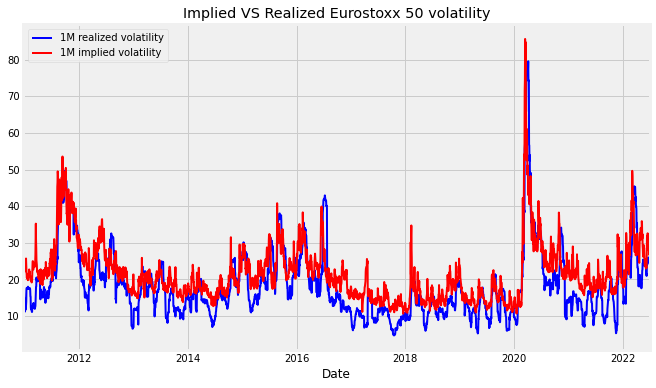

In [9]:
# Plot implied VS realized 1M SP500 (annualized) volatility 
realized = df['SX5E Index_Volatility_21d']*100*(252)**0.5
implied = df['V2X Index']
plt.figure(figsize=(10,6))
realized.plot(color='b', grid=True, linewidth=2, label='1M realized volatility')
implied.plot(color='r', grid=True, linewidth=2, label='1M implied volatility')
plt.legend()
plt.title('Implied VS Realized Eurostoxx 50 volatility');

### Label definition

We create a new variable, called 'Difference', which measures the Eurostoxx 50 RV-IV spread.

**Label (also called target) variable is the dependent variable that we aim to predict**. Here, the target variable is whether 'Difference' will close positive or negative on the next trading day, e.g. if RV will close above or below IV. We assign to the target variable a value of +1 for when tomorrow's RV is greater than tomorrow' IV, and 0 otherwise. The target can be described as :

$$
y_t = \left\{
    \begin{array}{ll}
        1 & \mbox{if } RV_{t+1}>IV_{t+1} \equiv \text{RV-IV}_{t+1}>0\\
        0 & \mbox{otherwise}
    \end{array}
\right.
$$

where $RV_{t+1}$ is the 1-day forward Eurostoxx 50 realized volatility (derived from 1 month observations), $IV_{t+1}$ is the 1-day forward Eurostoxx 50 implied volatility (estimate of the volatility in 1 month time), and $\text{RV-IV}_{t+1}$ the difference between the two.

In [10]:
# Classification label: days where realized volatility > implied volatility are classified as 1, 0 otherwise
df['Difference'] = realized - implied
df['Label'] = np.where(df['Difference'].shift(-1) > 0, 1, 0)
df = df.dropna()
# Remove the last row in the dataframe for the final prediction
df = df[:-1]
print(f'Data shape: {df.shape}')
print(pd.Series(df['Label']).value_counts())

Data shape: (3006, 338)
0    2439
1     567
Name: Label, dtype: int64


On a total of 3,006 days (as we remove the last row from Thursday 30 June 2022 for the final prediction), the realized volatility was above the implied volatility for 567 days, e.g. for 19% of the time, which indicates that **our dataset is imbalanced. As a consequence, accuracy results will be biased** (until we address the problem from section 3 onwards), **as it becomes easy to obtain a high accuracy by simply classifying all observations as the majority class**.

Finally, and prior jumping to the importance of features below, we check that the RV-IV spread is stationary. Stationarity is important in time series analysis because in its absence, a model describing the data will vary in accuracy at different time points. As such, **stationarity is required for sample statistics such as means, variances and correlations to accurately describe the data at all points of interest**. Despite stationarity may sometimes be of lower importance for machine learning models, it is always a good thing to check.

ADF statistic: -7.972440
ADF p-value: 0.000000
Critical values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


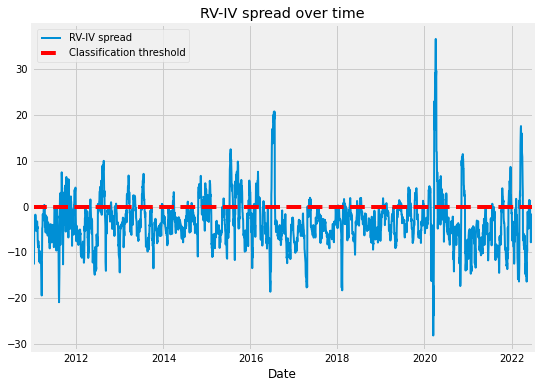

In [11]:
# Check the difference between implied and realized volatility is stationary
ADF_vol = adfuller(df['Difference'])
print('ADF statistic: %f' % ADF_vol[0])
print('ADF p-value: %f' % ADF_vol[1])
print('Critical values:')
for key, value in ADF_vol[4].items():
    print('\t%s: %.3f' % (key, value))
# Plot difference
plt.figure(figsize=(8,6))
df['Difference'].plot(title='RV-IV spread over time', label='RV-IV spread', grid=True, linewidth=2);
plt.axhline(y=0, color='r', linestyle='--', label='Classification threshold');
plt.legend();

The AD Fuller test indicates that the Eurostoxx 50 RV-IV spread is a stationary time series. As confirmed from the previous plot, the Eurostoxx 50 RV-IV spread is mostly negative, to some exceptions.

### Train-Test split

We now explicitly define our set of features $X$ and label $Y$. We exclude from the features' list the 'Difference' and 'Label' variables, as these two variables were used to build the label. For the same reason reason, we also exclude from the feature set the 'V2X Index' and 'SX5E Index_Volatility_21d' variables, as these are the two quantities of interest that were used to derive the 'Difference' variable on which our target is built. As a result, **we have a total of 334 features to predict our target variable, for a total of 3,006 daily observations.**.

**All the features should have a similar scale for every of the 334 features to be equally represented when estimating the feature importance and building the model. For this reason, we apply the MinMaxScaler to the entire feature set**.

$$X_{scaled} = \frac{X-X_{min}}{X_{max}-X_{min}}$$

In [12]:
# Define Y
Y = df['Label']
# Prepare X and Y
data = df.copy()
X = data.drop(['Label','Difference','SX5E Index_Volatility_21d','V2X Index'], axis=1)
labels = X.columns
# Transfor feature matrix
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
X = pd.DataFrame(X, columns=labels)
print(f'Number of daily prices: {X.shape[0]} | Number of features: {X.shape[1]}')

Number of daily prices: 3006 | Number of features: 334


We split the dataset into two parts: 80% of the data is kept for model training purposes while the remaining 20% are kept for test purposes, e.g. to evaluate the model performance on unseen data. When dealing with time series, the set-up 'shuffle=False' is crucial as it allows to avoid look-ahead bias.

In [13]:
# Split the datasets into training and testing data.
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=False)
# Output the train and test data size
print(f"Train and Test Size {len(X_train)}, {len(X_test)}")

Train and Test Size 2404, 602


## Feature importance

When inputting features into a model, **the goal is to feed the model with features that are relevant for predicting a class. Including irrelevant features poses the problem of unnecessary noise in the data, resulting in lower model accuracy**.

In this section, we estimate the importance of the 156 proposed features based on 3 feature importance algorithms:
- Boruta
- Decision Tree Classifier (DTC)
- Self Organizing Maps (SOM)

Boruta is an all relevant feature selection method, thus the selected features are all relevant to the outcome and may be correlated. Therefore, **we start the feature selection process with Boruta. We then apply to the set of Boruta approved features the DTC and SOM, and cross their respective results in order to come up with a set of final features**. We propose three sets of features:
- First choice: features resulting from Boruta algorithm.
- Choice A: features resulting from Boruta algorithm are passed through the DTC and SOM. Choice A features only consists of DTC and SOM 20 most important features with a correlation below 75%.
- Choice B: Choice B simply lists Boruta features with a correlation below 75%.

**The choice of the feature set is based on the ROC curve, as it indicates which model is best capable to distinguish betweeen our two prediction classes**. The feature set with the best ROC curve score (AUC) for the best number of features will be selected as input for our neural network model.

As we yet work with an imbalanced dataset, accuracy scores are biased as explain in section 1.3 above and detailed in section 3 below. As a consequence, **our key evaluation metric in section 2 will be the ROC curve and not the accuracy score**.

### Boruta

**Boruta algorithm is a wrapper built around the random forest classification algorithm - relatively quick and able to run without tuning of parameters, which gives a numerical estimate of the feature importance**. The importance measure of an attribute is obtained as the loss of accuracy in classification caused by the random permutation of attribute values between objects.

Due to the fact that the number of random forest runs during Boruta is limited by the maximum of iterations, the calculation can be forced to stop prematurely, when there are still attributes which are judged neither to be confirmed nor rejected, and thus finally marked as tentative.

We initialize the Boruta algorithm with a Random Forest of maximum depth of 5.

In [14]:
# Class weight function
def cwts(df):
    c0, c1 = np.bincount(df['Label'])
    w0=(1/c0)*(len(df))/2 
    w1=(1/c1)*(len(df))/2 
    return {0: w0, 1: w1}

# Initiate Random Forest model
rf_all_features = RandomForestClassifier(n_jobs=-1, 
                                class_weight=cwts(df), 
                                random_state=42, 
                                max_depth=5)
rf_all_features.fit(X_train, y_train)
predictions = rf_all_features.predict(X_test)
# Print classification report
print(classification_report(y_test, predictions))
print(f'Train Accuracy:  {accuracy_score(y_train, rf_all_features.predict(X_train)):.2%}')
print(f'Test Accuracy:  {accuracy_score(y_test, rf_all_features.predict(X_test)):.2%}')

              precision    recall  f1-score   support

           0       0.90      0.85      0.87       474
           1       0.54      0.64      0.59       128

    accuracy                           0.81       602
   macro avg       0.72      0.75      0.73       602
weighted avg       0.82      0.81      0.81       602

Train Accuracy:  92.64%
Test Accuracy:  80.73%


The random forest algorithm performs well - but **on an imbalanced dataset!** In sample accuracy totals to 93% while out-of-sample accuracy sums up to 81%. **We now apply the Boruta selection algorithm to our set of 334 features**.

In [16]:
# Initialise Boruta
boruta_selector = BorutaPy(rf_all_features, n_estimators='auto', verbose=2, random_state=1)
boruta_selector.fit(np.array(X_train), np.array(y_train))
# Print support and ranking for each feature
print("\n------Support and Ranking for each feature------\n")
for i in range(len(boruta_selector.support_)):
    if boruta_selector.support_[i]:
        print("Passes the test: ", X_train.columns[i],
              " - Ranking: ", boruta_selector.ranking_[i], "✔️")
    else:
        print("Doesn't pass the test: ",
              X_train.columns[i], " - Ranking: ", boruta_selector.ranking_[i], "❌")

# Features selected by Boruta
X_train_filtered = boruta_selector.transform(np.array(X_train))
print("\n------Selected Features------\n")
boruta_accepted = X_train.columns[boruta_selector.support_].to_list()
boruta_rejected = X_train.columns[boruta_selector.support_weak_].to_list()
print(boruta_accepted)
# Train the model
rf_all_features.fit(X_train_filtered, y_train)
# Compute predictions and RMSE
predictions_boruta = rf_all_features.predict(X_train_filtered)
boruta_results = pd.DataFrame({'pred': predictions_boruta, 'observed': y_train})

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	334
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	334
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	334
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	334
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	334
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	334
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	334
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	262
Tentative: 	72
Rejected: 	0
Iteration: 	9 / 100
Confirmed: 	262
Tentative: 	55
Rejected: 	17
Iteration: 	10 / 100
Confirmed: 	262
Tentative: 	55
Rejected: 	17
Iteration: 	11 / 100
Confirmed: 	262
Tentative: 	55
Rejected: 	17
Iteration: 	12 / 100
Confirmed: 	276
Tentative: 	41
Rejected: 	17
Iteration: 	13 / 100
Confirmed: 	276
Tentative: 	41
Rejected: 	17
Iteration: 	14 / 100
Confirmed: 	276
Tentative: 	34
Rejected: 	24
Iteration: 	15 / 100
Confirmed: 	276
Tentative: 	34
Rejected: 	24
Iteration: 	16 / 100
Confirmed: 	2

Out of the 334 features, the Boruta method resulted in the selection of 294 features.

In [17]:
# Apply feature selector transform to make sure all same features are selected
X_test_filtered = boruta_selector.transform(X_test.values)
# Check the shape
print(f'Shape of feature set X_test is: {X_test_filtered.shape}')

Shape of feature set X_test is: (602, 294)


We now check whether selecting features further would help, in particular Decision Tree Classifier (DTC) and Self-Organizing Maps (SOM).

### Decision Tree Classifier

CART stands for Classification and Regression Trees. The CART algorithm creates a binary tree, which means that each node has exactly two outgoing edges, in order to find the best numerical or categorical feature to split using an appropriate impurity criterion. 
- For classification, Gini impurity or entropy criterion can be used
- For regression, CART introduces variance reduction using least squares (mean square error)

**The main advantage of CART in our situation is the CART algorithm will itself identify the most significant variables and eliminate the non-significant ones**. More particularly, feature importance is calculated as the decrease in node impurity weighted by the probability of reaching that node. The node probability can be calculated by the number of samples that reach the node, divided by the total number of samples. The higher the value, the more important the feature.

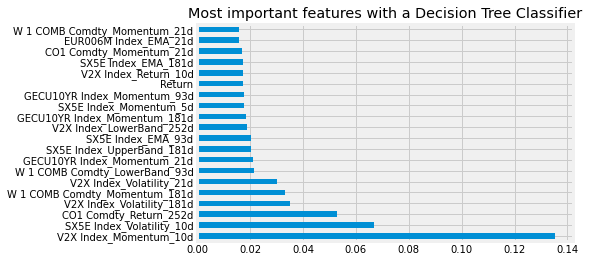

In [18]:
%matplotlib inline
# Decision Tree Classifier  for feature importance
model = DecisionTreeClassifier(random_state=0)
model.fit(X_train[boruta_accepted], y_train)
# #plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=boruta_accepted)
most_dtr = feat_importances.nlargest(20).index.values
feat_importances.nlargest(20).plot(kind='barh')
plt.title('Most important features with a Decision Tree Classifier')
plt.show()

We positively note that **all features, from yields to commodity prices, appear to have an impact on the Eurostoxx 50 RV-IV spread prediction**.

### Self-Organizing Map

A self-organizing map (SOM) is an unsupervised machine learning technique used to produce a low-dimensional (typically two-dimensional) representation of a higher dimensional data set while preserving the topological structure of the data. **SOM is a topology-preserving feature map that represents the distribution of features in the feature space**. In SOM similar feature vectors are mapped to adjacent map elements. During the training phase, the map is fed with a large number of unclassified feature vectors. More exctaly, **a SOM is a type of artificial neural network but is trained using competitive learning rather than the error-correction learning** (e.g., backpropagation with gradient descent) used by other artificial neural networks, and is used for feature selection.

The figure below illustrates the block diagram of the feature selection with a SOM:
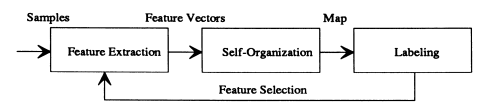

**The SOM is a practical method to find a set of features**. It is straightforward and easy to implement, and the need of preclassified samples is minimized. SOM is used in a feature selection as follows: 
1. Take $n$ features. 
2. Train the map with a large set of these features. Label the map with a set of pre-classified samples. 
    - If the classes in the labeled map overlap add a new feature or replace a feature with a new one. 
    - If the feature does not improve the separability of the classes, the feature will be replaced. 
3. Train the map again with a set of new features and label the map. 
4. Repeat this procedure until you have a set of features that can reach the desired classification rate. 

*NOTE: The feature importance for SOM is obtained from the popsom package - coming as .txt attached to this notebook*

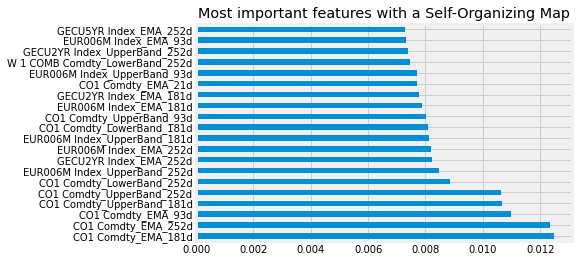

In [19]:
%matplotlib inline
# SOM features importance based on a 10x10 SOM
m = popsom.map(xdim=10,ydim=10,train=1000,norm=False)
m.fit(X_train[boruta_accepted],y_train)
features_imp = m.significance(False,False)
feat_importances = pd.Series(features_imp, index=boruta_accepted)
most_som = feat_importances.nlargest(20).index.values
feat_importances.nlargest(20).plot(kind='barh')
plt.title('Most important features with a Self-Organizing Map')
plt.show()

Interestingly, the SOM most important features seem to have a longer lag than the most important features resulting from DTC. We now plot the features in a SOM to see how the 294 Boruta features organize together.

In [20]:
# SOM input
som_data = X[boruta_accepted].describe().T
som_labels=X[boruta_accepted].columns.T
som_data = som_data.drop(['count','min','max'],axis=1)
som_values = som_data.values
# Initialize a 10x10 SOM
som = MiniSom(10, 10, 5, learning_rate=0.5, sigma=5, random_seed=42)
# Initialize with randon weights
som.random_weights_init(som_values)
# Trains SOM with 10000 iterations
som.train_batch(som_values,10000, verbose=True)

 [  1153 / 10000 ]  12% - 0:00:01 left 

 [  2280 / 10000 ]  23% - 0:00:01 left 

 [  3423 / 10000 ]  34% - 0:00:01 left 

 [  4483 / 10000 ]  45% - 0:00:00 left 

 [  5587 / 10000 ]  56% - 0:00:00 left 

 [  6703 / 10000 ]  67% - 0:00:00 left 

 [  7859 / 10000 ]  79% - 0:00:00 left 

 [  8992 / 10000 ]  90% - 0:00:00 left 

 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 0.06053975317790069


The SOM is a map made of Best Matching Units (BMU). **Each feature is attributed to a BMU, and the pairs of neighbouring data waim to be projected on the same or neighbouring unit**. The quantisation error is an average distance between each feature and its BMU. 
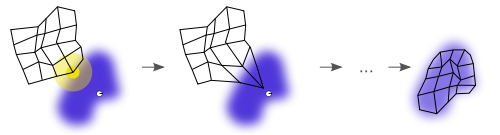
Important to note,
- when comparing two SOM, the SOM with the lowest quantisation error fits the data more accurately on average
- quantisation error only measures relationship between units and items mapped to those units, not how units preserve neighbourhood of the data

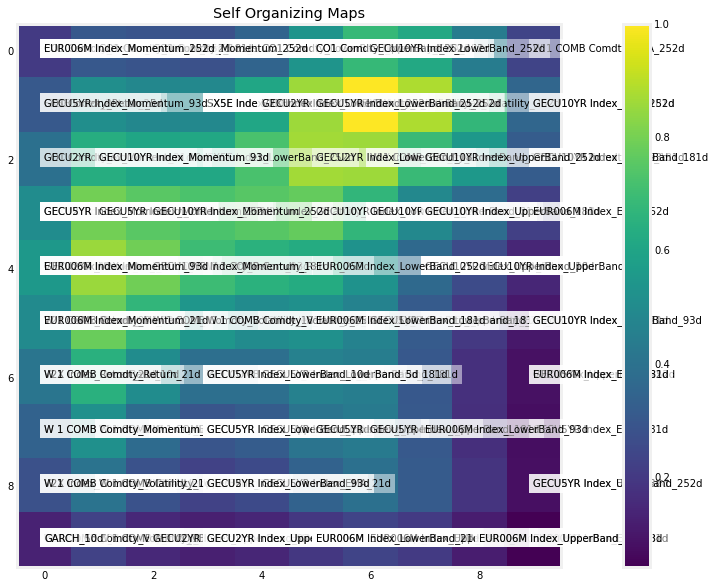

In [21]:
# Plot SOM
plt.figure(figsize=(20, 10))
for ix in range(len(som_values)):
    winner = som.winner(som_values[ix])
    plt.text(winner[0], winner[1], som_labels[ix], bbox=dict(facecolor='white', alpha=0.5, lw=0)) 
plt.imshow(som.distance_map())
plt.colorbar()
plt.grid(False)
plt.title('Self Organizing Maps');

The SOM above is the **perfect illustration on Boruta downside: the SOM indicates that many of the 334 features are correlated, as they sit on the same BMU, or very close neighborhood**. 
- On a positive note, all 294 Boruta features are fairly represented across the SOM, which indicate the good explanatory power of our features. 
- On a negative note, **plotting a SOM doesn't come with much readability when we have so many features**.

### Feature selection

Until now, we saw three different approaches to decide for the importance on each feature in label prediction: Boruta, DTC and SOM. As we saw, Boruta is very helpful inasmuch as it selects all relevant features, but this comes with the disadvantage that it selects all relevant features, and some features may be correlated. **In this subsection, the idea is to benefit from all the DTC and SOM independent methods on top of Boruta, and combine them into one final 'smarter' set of features**. To do so:
1. We merge without duplicates the **20 most important features from the DTC and SOM** methods.
2. We **remove all features** obtained in 1. **which have a correlation higher than 75%**.
3. We plot the final set of features obtained in 2. on a Self-Organizing Map to ensure they do not overlap between each other. As the number of features is now reduced, the SOM should now come with readability.
4. We **plot the ROC curve for the different Random Forest Classifier models obtained with the different feature sets** and select the model which distinguish the best between the two classes.

#### Choice A

In order to get Choice A features, we take the unique features between SOM and DTC most important 20 feature sets which have a correlation below 75%.

Final number of features selected: 19


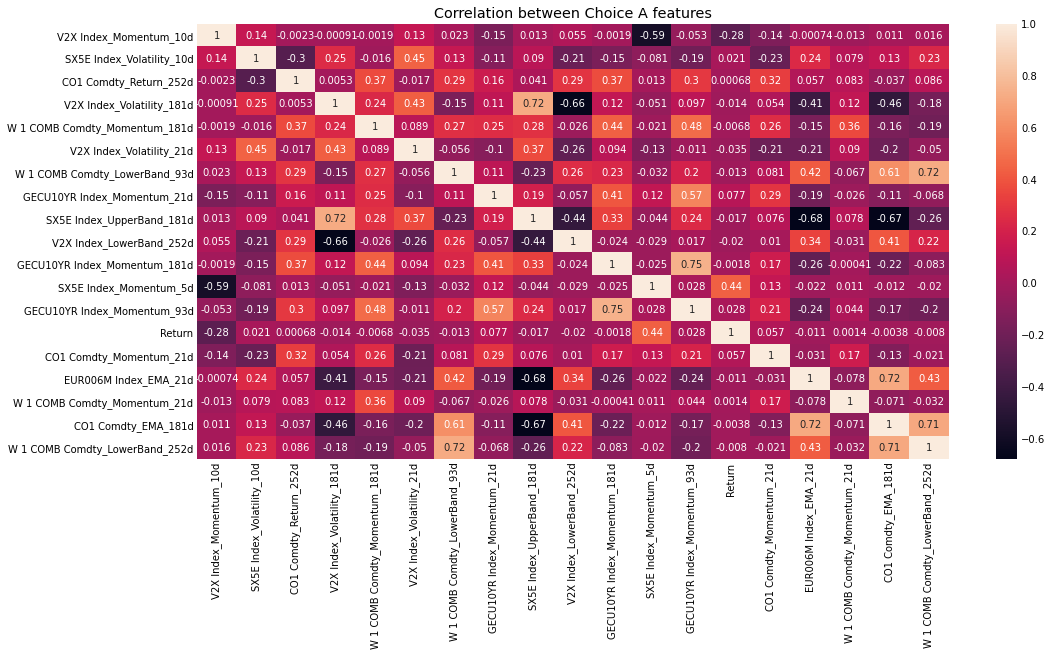

In [22]:
# Union of features from DTC and SOM
selected_features = list(most_dtr)
selected_features.extend(x for x in most_som if x not in selected_features)
# Remove features with correlation above 75%
X_A = X[selected_features]
corrmat = X_A.corr()
upper_tri = corrmat.where(np.triu(np.ones(corrmat.shape),k=1).astype(np.bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.75)]
# Plot correlation table for final list of features
X_final = X_A.drop(to_drop, axis=1)
final_features = X_final.columns
print(f'Final number of features selected: {len(final_features)}')
corrMatrix=X_final.corr()
plt.figure(figsize = (15,8))
sn.heatmap(corrMatrix, annot=True)
plt.title('Correlation between Choice A features')
plt.show()

In [23]:
# Make predictions with our new dataset of features
forest = RandomForestClassifier(n_jobs=-1, 
                                class_weight=cwts(df), 
                                random_state=42, 
                                max_depth=5)
forest.fit(X_train[final_features], y_train)
final_predictions = forest.predict(X_test[final_features])
# print classification report
print(classification_report(y_test, final_predictions))

              precision    recall  f1-score   support

           0       0.90      0.79      0.84       474
           1       0.47      0.68      0.55       128

    accuracy                           0.77       602
   macro avg       0.68      0.74      0.70       602
weighted avg       0.81      0.77      0.78       602



As we see from the classification report, **the model struggles to predict class 1 with a set of 19 features**, which is a typical issue arising from an imbalanced dataset.

We now plot Choice A set of 19 features on a SOM. At this stage, **we expect the 19 features to be quite different in nature, and therefore most of them to be on a different BMU**.

 [  1001 / 10000 ]  10% - 0:00:01 left 

 [  2150 / 10000 ]  22% - 0:00:01 left 

 [  3300 / 10000 ]  33% - 0:00:01 left 

 [  4440 / 10000 ]  44% - 0:00:00 left 

 [  5560 / 10000 ]  56% - 0:00:00 left 

 [  6627 / 10000 ]  66% - 0:00:00 left 

 [  7669 / 10000 ]  77% - 0:00:00 left 

 [  8824 / 10000 ]  88% - 0:00:00 left 

 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 0.04672708290324621


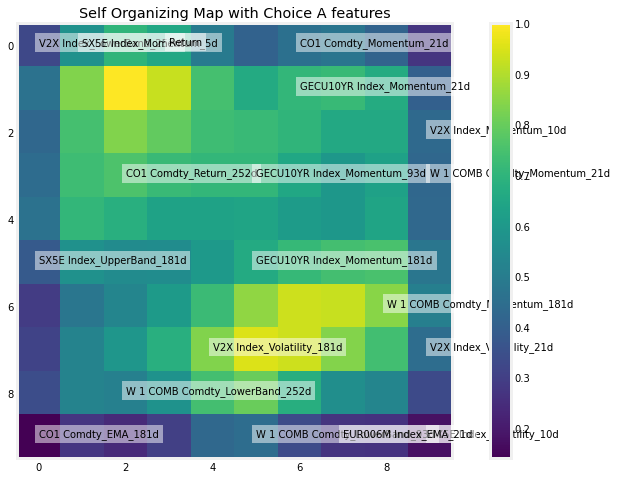

In [24]:
# SOM input
som_data = X[final_features].describe().T
som_labels=X[final_features].columns.T
som_data = som_data.drop(['count','min','max'],axis=1)
som_values = som_data.values
# Initialize a 10x10 SOM
som = MiniSom(10, 10, 5, learning_rate=0.5, sigma=5, random_seed=42)
# Initialize with randon weights
som.random_weights_init(som_values)
# Trains SOM with 10000 iterations
som.train_batch(som_values,10000, verbose=True)
# Plot SOM
plt.figure(figsize=(12, 8))
for ix in range(len(som_values)):
    winner = som.winner(som_values[ix])
    plt.text(winner[0], winner[1], som_labels[ix], bbox=dict(facecolor='white', alpha=0.5, lw=0)) 
plt.imshow(som.distance_map())
plt.colorbar()
plt.grid(False)
plt.title('Self Organizing Map with Choice A features');

As we expected, **most of Choice A features are now on a different BMU**. We can see that our 19 features more represented on the right-side of the SOM, while the left-side is clearer.

#### Choice B

In order to get Choice B features, we take the Boruta features which have a correlation below 75%.

Final number of features selected: 40


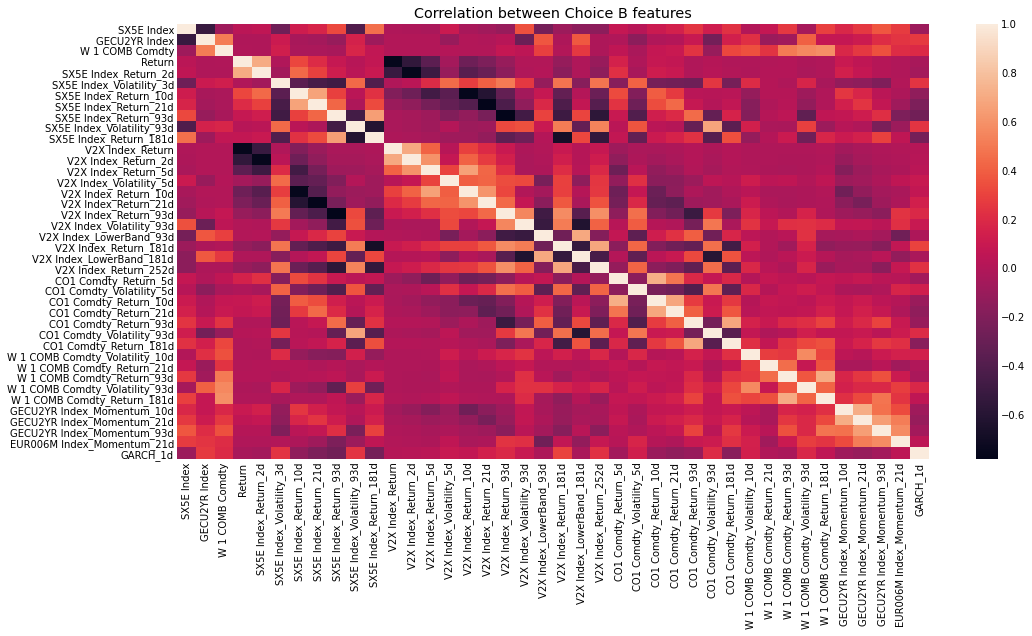

In [25]:
# Remove features with correlation above 75%
X_B = X[boruta_accepted]
corrmat_B = X_B.corr()
upper_tri_B = corrmat_B.where(np.triu(np.ones(corrmat_B.shape),k=1).astype(np.bool))
to_drop_B = [column for column in upper_tri_B.columns if any(upper_tri_B[column] > 0.75)]
# Plot correlation table for final list of features
X_final_B = X_B.drop(to_drop_B, axis=1)
final_features_B = X_final_B.columns
print(f'Final number of features selected: {len(final_features_B)}')
corrMatrix_B = X_final_B.corr()
plt.figure(figsize = (15,8))
sn.heatmap(corrMatrix_B, annot=False) # We remove correlation values for readability
plt.title('Correlation between Choice B features')
plt.show()

In [26]:
# Make predictions with our new dataset of features
forest_B = RandomForestClassifier(n_jobs=-1, 
                                class_weight=cwts(df), 
                                random_state=42, 
                                max_depth=5)
forest_B.fit(X_train[final_features_B], y_train)
final_predictions_B = forest_B.predict(X_test[final_features_B])
# print classification report
print(classification_report(y_test, final_predictions_B))

              precision    recall  f1-score   support

           0       0.90      0.91      0.91       474
           1       0.66      0.62      0.64       128

    accuracy                           0.85       602
   macro avg       0.78      0.77      0.77       602
weighted avg       0.85      0.85      0.85       602



Choice B model succeeds better to predict both classes with the filtered set of 40 features than Choice A model.

We now plot the final set of 40 features on a SOM. **As these 40 features have a correlation below 75%, we also expect most of them to be on a different BMU**.

 [  1076 / 10000 ]  11% - 0:00:01 left 

 [  2206 / 10000 ]  22% - 0:00:01 left 

 [  3282 / 10000 ]  33% - 0:00:01 left 

 [  4379 / 10000 ]  44% - 0:00:00 left 

 [  5501 / 10000 ]  55% - 0:00:00 left 

 [  6425 / 10000 ]  64% - 0:00:00 left 

 [  7185 / 10000 ]  72% - 0:00:00 left 

 [  8196 / 10000 ]  82% - 0:00:00 left 

 [  9314 / 10000 ]  93% - 0:00:00 left 

 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 0.03414845118693995


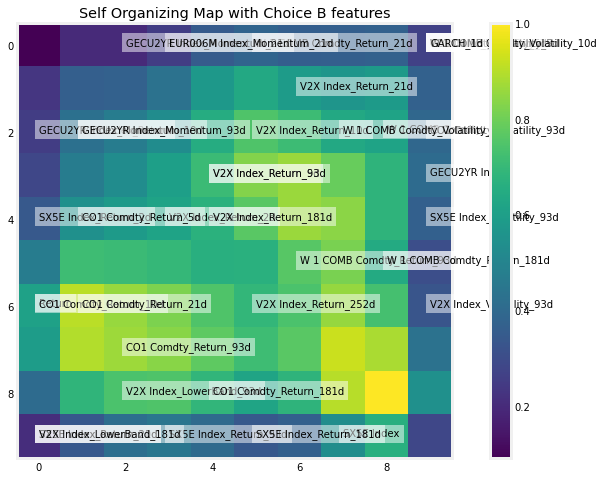

In [27]:
# SOM input
som_data = X[final_features_B].describe().T
som_labels = X[final_features_B].columns.T
som_data = som_data.drop(['count','min','max'],axis=1)
som_values = som_data.values
# Initialize a 10x10 SOM
som = MiniSom(10, 10, 5, learning_rate=0.5, sigma=5, random_seed=42)
# Initialize with randon weights
som.random_weights_init(som_values)
# Trains SOM with 10000 iterations
som.train_batch(som_values,10000, verbose=True)
# Plot SOM
plt.figure(figsize=(12, 8))
for ix in range(len(som_values)):
    winner = som.winner(som_values[ix])
    plt.text(winner[0], winner[1], som_labels[ix], bbox=dict(facecolor='white', alpha=0.5, lw=0)) 
plt.imshow(som.distance_map())
plt.colorbar()
plt.grid(False)
plt.title('Self Organizing Map with Choice B features');

As we expected, **most of Choice B features are now on a different BMU**. The 40 features are more equally represented on the SOM, as they roughly cover the entire map, to the exceptions of some areas such as the upper left or bottom  right corners.

### ROC curve

The ROC curve is created by plotting the true positive rate (TPR) against the false positive rate (FPR) at various classification thresholds. **The ROC curve indicates the loss of information that each model has on top of illustrating how well each model distinguishes between the two classes we aim to predict**. The area under the ROC curve (AUC) is a measure of how well a model can distinguish between two classes. Therefore, we plot on the ROC curve a Random Forest Classifier with:
1. All features included (334)
2. Boruta relevant features included (294)
3. Choice A: final 19 features selected with Boruta, DTC, SOM and maximum correlation at 75%
4. Choice B: final 40 features selected with Boruta and maximum correlation at 75%

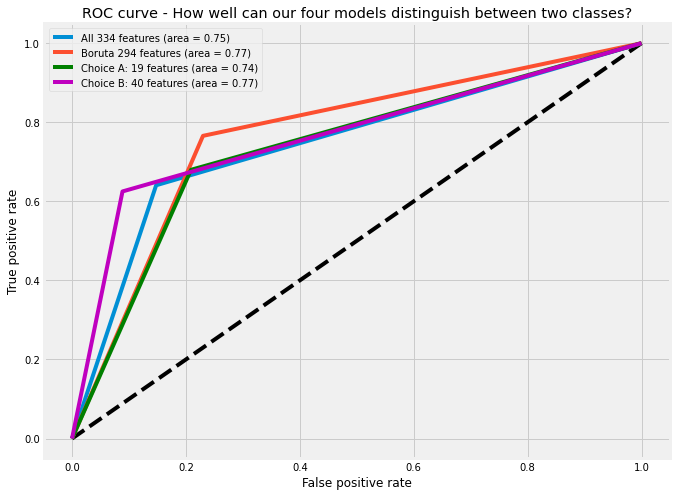

In [28]:
# Compare model performance before Boruta
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, predictions)
auc_rf = auc(fpr_rf, tpr_rf)
# Compare model performance after Boruta
boruta_predictions = rf_all_features.predict(X_test_filtered)
fpr_boruta, tpr_boruta, thresholds_boruta = roc_curve(y_test, boruta_predictions)
auc_boruta = auc(fpr_boruta, tpr_boruta)
# Compare model performance with final 13 features (Choice A)
final_predictions = forest.predict(X_test[final_features])
fpr_final, tpr_final, thresholds_final = roc_curve(y_test, final_predictions)
auc_final = auc(fpr_final, tpr_final)
# Compare model performance with final 13 features (Choice B)
B_predictions = forest_B.predict(X_test[final_features_B])
fpr_B, tpr_B, thresholds_B = roc_curve(y_test, B_predictions)
auc_B = auc(fpr_B, tpr_B)
# Plot
plt.figure(figsize= (10,8))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='All 334 features (area = {:.2f})'.format(auc_rf))
plt.plot(fpr_boruta, tpr_boruta, label='Boruta 294 features (area = {:.2f})'.format(auc_boruta))
plt.plot(fpr_final, tpr_final, label='Choice A: 19 features (area = {:.2f})'.format(auc_final), color = 'g')
plt.plot(fpr_B, tpr_B, label='Choice B: 40 features (area = {:.2f})'.format(auc_B), color = 'm')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve - How well can our four models distinguish between two classes?')
plt.legend(loc='best')
plt.show()

As we see from the ROC curve, Boruta and choice B features provide the same explanatory power into the prediction model. Nevertheless, only 40 of the Boruta 294 features have a correlation below 75%. In other terms, 85% of Boruta selected features are highly correlated. As a result, we prefer Choice B features set to build predictions upon, as Choice B has a higher AUC score than Choice A.

From this point, **we use Choice B features as input dataset**.

## Address class imbalance

As mentioned above, classification predictive modeling involves predicting a class label for a given observation. An imbalanced classification problem is an example of a classification problem where the distribution of examples across the known classes is biased or skewed. **Until now, our dataset is imbalanced: as shown in section 1.3 above, we have 2,439 observations classified as 0 ('Down' move), and only 567 classified as 1 ('Up' move)**. 

**Imbalanced classifications pose a challenge for predictive modeling as most of the machine learning algorithms used for classification were designed around the assumption of an equal number of examples for each class. This results in models that have poor predictive performance, specifically for the minority class**. This is a problem because typically, the minority class is more important and therefore the problem is more sensitive to classification errors for the minority class than the majority class.

The picture below depicts the situation quite well:
- When oversampling, we create additional points in the minority class in order to obtain a balanced dataset aligned on the majority class: it is achieved with the SMOTE algorithm.
- When undersampling, we remove points from the majority class in order to obtain a balanced dataset aligned on the minority class: it is achieved with the Near-Miss algorithm.

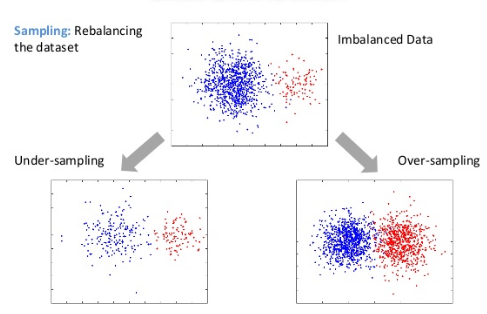

### Oversampling with SMOTE

SMOTE Algorithm oversamples the minority instances and makes it equal to majority class. Both categories have equal amount of records. More specifically, the minority class is increased to the total number of the majority class.

In [29]:
oversample = SMOTE(random_state = 2)
X_train_os, y_train_os = oversample.fit_resample(X_train[final_features_B], y_train)
print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0)))
print("After OverSampling, counts of label '1': {}".format(sum(y_train_os == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_os == 0)))

Before OverSampling, counts of label '1': 439
Before OverSampling, counts of label '0': 1965 

After OverSampling, counts of label '1': 1965
After OverSampling, counts of label '0': 1965


The classification report indicates the accuracy after addressing class imbalance by oversampling.

In [30]:
rf_all_features.fit(X_train_os, y_train_os)
predictions_os = rf_all_features.predict(X_test[final_features_B])
# print classification report
print(classification_report(y_test, predictions_os))
print(f'Train Accuracy:  {accuracy_score(y_train_os, rf_all_features.predict(X_train_os)):.2%}')
print(f'Test Accuracy:  {accuracy_score(y_test, rf_all_features.predict(X_test[final_features_B])):.2%}')

              precision    recall  f1-score   support

           0       0.95      0.51      0.67       474
           1       0.34      0.91      0.49       128

    accuracy                           0.60       602
   macro avg       0.64      0.71      0.58       602
weighted avg       0.82      0.60      0.63       602

Train Accuracy:  76.18%
Test Accuracy:  59.80%


As a result of the SMOTE algorithm, we note that:
- The difference between the Train and Test accuracy increased from around 12 to 16
- The Train accuracy decreased from 93 to 76
- The Test accuracy decreased from 81 to 60

### Undersampling with NearMiss

NearMiss Algorithm undersamples the majority instances and makes it equal to minority class. Both categories have equal amount of records. More specifically, the majority class is decreased to the total number of the minority class.

In [31]:
undersample = NearMiss()
X_train_us, y_train_us = undersample.fit_resample(X_train[final_features_B], y_train)
print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0)))
print("After OverSampling, counts of label '1': {}".format(sum(y_train_us == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_us == 0)))

Before OverSampling, counts of label '1': 439
Before OverSampling, counts of label '0': 1965 

After OverSampling, counts of label '1': 439
After OverSampling, counts of label '0': 439


The classification report indicates the accuracy after addressing class imbalance by undersampling.

In [32]:
rf_all_features.fit(X_train_us, y_train_us)
predictions_us = rf_all_features.predict(X_test[final_features_B])
# print classification report
print(classification_report(y_test, predictions_us))
print(f'Train Accuracy:  {accuracy_score(y_train_os, rf_all_features.predict(X_train_os)):.2%}')
print(f'Test Accuracy:  {accuracy_score(y_test, rf_all_features.predict(X_test[final_features_B])):.2%}')

              precision    recall  f1-score   support

           0       1.00      0.05      0.10       474
           1       0.22      1.00      0.36       128

    accuracy                           0.26       602
   macro avg       0.61      0.53      0.23       602
weighted avg       0.83      0.26      0.16       602

Train Accuracy:  65.47%
Test Accuracy:  25.58%


As a result of the Near Miss algorithm, we note that:
- The difference between the Train and Test accuracy increased from around 12 to 39
- The Train accuracy decreased from 93 to 65
- The Test accuracy decreased from 81 to 26

As a result of the NearMiss algorithm, we note that the undersample feature set is more prone to overfitting. Therefore, we conclude that **the NearMiss algorithm is not a good candidate to address class imbalance in our problem**.

**From now on, we will use as input for our deep-learning models the SMOTE balanced Choice B feature set**.

# Part II: Recurrent Neural Networks (RNNs)

The objective of this second section is to **predict with RNNs if the realized volatility will be above the implied volatility on the next trading day, as this indicates a bear market to come**. Before jumping on the modeling of neural networks, good practice requires to set-up a baseline model against which our models will be benchmarked. If the baseline model performs better than one of our model, then this model is rejected.

## Baseline model

**A baseline model serves as a point of reference in a prediction exercise**. If the model achieves performance at or below the baseline model, then we should abandon the model. **An appropriate baseline** model should be:

- **Simple**: A method that requires little or no training or intelligence.
- **Fast**: A method that is fast to implement and computationally trivial to make a prediction.
- **Repeatable**: A method that is deterministic, meaning that it produces an expected output given the same input.

**The main function of the baseline model is to contextualize the results of trained models. Baseline models usually lack complexity and may have little predictive power**. As we are doing a binary classification exercise, our baseline model will be predicting either 0 or 1. As such, we define as baseline model a model making predictions that ignores the input features and outputs a uniform distribution of 0 and 1. We expect the baseline model to have an accuracy around 50%.

              precision    recall  f1-score   support

           0       0.80      0.48      0.60       466
           1       0.20      0.51      0.28       115

    accuracy                           0.49       581
   macro avg       0.50      0.50      0.44       581
weighted avg       0.68      0.49      0.54       581



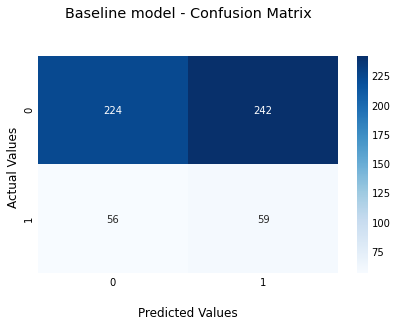

In [33]:
# Define sequence length lookback
sequence_length = 21 # as we will use the past 21 days to make predictions with our LSTM and GRU models later below
# Initialize Dummy Classifier
dummy_clf = DummyClassifier(strategy='uniform',random_state=42)
dummy_clf.fit(X_train_os, y_train_os)
# Make predictions
y_pred_baseline = dummy_clf.predict(X_test_filtered[sequence_length:])
# Classification report
print(classification_report(y_test[sequence_length:], y_pred_baseline))
# Plot confusion matrix with baseline model
cf_matrix_baseline = confusion_matrix(y_test[sequence_length:], y_pred_baseline)
ax = sn.heatmap(cf_matrix_baseline, annot=True, cmap='Blues', fmt='g')
ax.set_title('Baseline model - Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
## Ticket labels
ax.xaxis.set_ticklabels(['0','1'])
ax.yaxis.set_ticklabels(['0','1'])
plt.show()

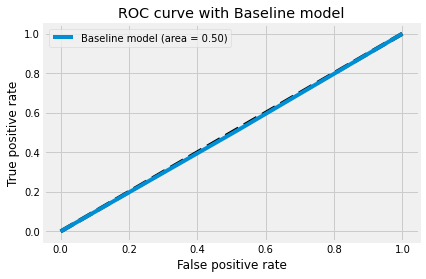

In [35]:
# Plot ROC curve
fpr_baseline, tpr_baseline, thresholds_baseline = roc_curve(y_test[sequence_length:], y_pred_baseline)
auc_baseline = auc(fpr_baseline, tpr_baseline)
plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_baseline, tpr_baseline, label='Baseline model (area = {:.2f})'.format(auc_baseline))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve with Baseline model')
plt.legend(loc='best')
plt.show()

Our baseline model succeeds to predict negative RV-IV spread moves (224 TN, 59 FN), but fails in accurately predicting positive RV-IV spread moves (56 TP, 242 FP).

## Long-Short Term Memory (LSTM) model

A neural network is an adaptive system that learns by using interconnected nodes or neurons in a layered structure that resembles a human brain. **A neural network can learn from data: it can be trained to recognize patterns, classify data, and forecast future events**.

More particularly, we use Recurrent Neural Networks (RNNs), which are a class of neural networks that are powerful for modeling sequence data such as time series. Schematically, a RNN layer uses a 'for' loop to iterate over the timesteps of a sequence, while maintaining an internal state that encodes information about the timesteps it has seen so far. In particular, **a LSTM network is a type of recurrent neural network (RNN) that can learn long-term dependencies between time steps of sequence data**.

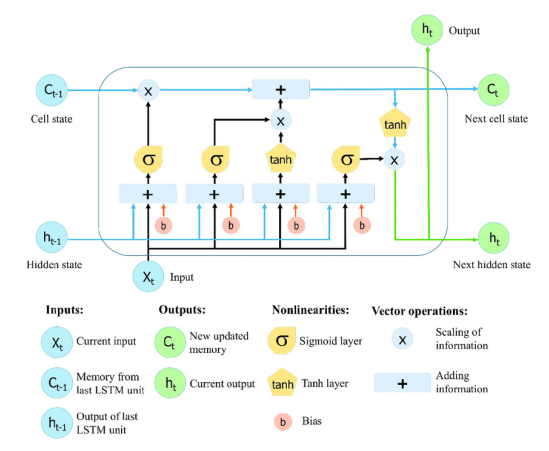

**Time series data must be transformed into a structure of samples with input and output components before it can be used to fit a supervised learning model.** The Keras deep learning library provides the TimeseriesGenerator to automatically transform both univariate and multivariate time series data into samples ready to train deep learning models.

In [37]:
# Define parameters based on oversampled dataset
sequence_length = 21 # e.g. we use the past 21 days to make predictions
nb_features = X_train_os.shape[1]
# Generate train and test sequence data
g = TimeseriesGenerator(X_train_os, y_train_os, length=sequence_length) # X_train_os already incorporate only Choice B features only
g_ = TimeseriesGenerator(X_test[final_features_B], y_test, length=sequence_length)

In [38]:
# Verify batch size
for i in range(len(g)):
    a, b = g[i]
    print(a.shape, b.shape)

(128, 21, 40) (128,)
(128, 21, 40) (128,)
(128, 21, 40) (128,)
(128, 21, 40) (128,)
(128, 21, 40) (128,)
(128, 21, 40) (128,)
(128, 21, 40) (128,)
(128, 21, 40) (128,)
(128, 21, 40) (128,)
(128, 21, 40) (128,)
(128, 21, 40) (128,)
(128, 21, 40) (128,)
(128, 21, 40) (128,)
(128, 21, 40) (128,)
(128, 21, 40) (128,)
(128, 21, 40) (128,)
(128, 21, 40) (128,)
(128, 21, 40) (128,)
(128, 21, 40) (128,)
(128, 21, 40) (128,)
(128, 21, 40) (128,)
(128, 21, 40) (128,)
(128, 21, 40) (128,)
(128, 21, 40) (128,)
(128, 21, 40) (128,)
(128, 21, 40) (128,)
(128, 21, 40) (128,)
(128, 21, 40) (128,)
(128, 21, 40) (128,)
(128, 21, 40) (128,)
(69, 21, 40) (69,)


### Build model

As **the objective of the paper is also to compare LSTM and GRU performance for the same prediction task** and for an aligned set-up, we create a RNN class to build and find hyperparameters for the neural network of our choice.

The LSTM and GRU models have an aligned structure for comparability reasons:

- Stacked structure of 3 hidden layers between an input layer and an output layer
- Dropout regularization for the model to generalize better after the first 2 hidden layers
- Adam optimizer
- Binary Cross Entropy loss function as we deal with a classification problem

Our RNN class (*NN_model*) has two main functions:
- **create**: create the neural network model
- **HPoptim**: create the neural network model for a given set of hyperparameters, used for the tuning process of hyperparameters - see section 5.3 (LSTM) and 6.3 (GRU) below.

In [39]:
class NN_model:
    """
    Class for creating Recurrent Neural Networks
    Attributes: 
        hu          : int
        lookback    : int
        features    : int
        modeltype   : str
    """    
    def __init__(self, hu, lookback, features, modeltype):
        # Hidden units
        self.hu = hu
        # Lookback
        self.lookback = lookback
        # Features
        self.features = features
        # Model: LSTM or GRU
        self.modeltype = modeltype
    
    # Create a sequential model
    def create(self):
        tf.keras.backend.clear_session()
        # Fix random seed for reproducibility
        seed = 2021
        tf.random.set_seed(seed)
        np.random.seed(seed)
        random.seed(seed)
        # Instantiate the model
        model = Sequential()
        # First layer
        model.add(eval(self.modeltype)(units=self.hu*2, input_shape=(self.lookback, self.features), activation = 'elu', return_sequences=True, name=str(self.modeltype)+'1'))
        model.add(Dropout(0.4, name='Dropout1'))
        # Second layer
        model.add(eval(self.modeltype)(units=self.hu, activation = 'elu', return_sequences=True, name=str(self.modeltype)+'2'))
        model.add(Dropout(0.4, name='Dropout2'))
        # Third layer
        model.add(eval(self.modeltype)(units=self.hu, activation = 'elu', return_sequences=False, name=str(self.modeltype)+'3'))
        model.add(Dense(units=1, activation='sigmoid', name='Output'))             
        # Model optimization
        opt = Adam(lr=0.001, epsilon=1e-08, decay=0.0)
        model.compile(optimizer=opt, 
                  loss=BinaryCrossentropy(), 
                  metrics=['accuracy', 
                           Precision(),
                           Recall()])

        return model
    
    def HPoptim(self,hp):
        tf.keras.backend.clear_session()   
        # Fix random seed for reproducibility
        seed = 2021
        tf.random.set_seed(seed)
        np.random.seed(seed)
        random.seed(seed)
        # Instantiate the model
        model = Sequential()
        # Tune the number of units in the layers
        hp_units1 = hp.Int('units1', min_value=4, max_value=32, step=4)
        hp_units2 = hp.Int('units2', min_value=4, max_value=32, step=4)
        hp_units3 = hp.Int('units3', min_value=4, max_value=32, step=4)
        # Tune the dropout rate
        hp_dropout1 = hp.Float('Dropout_rate', min_value=0, max_value=0.5, step=0.1)
        hp_dropout2 = hp.Float('Dropout_rate', min_value=0, max_value=0.5, step=0.1)
        # Tune the learning rate for the optimizer
        hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
        # Tune activation functions
        hp_activation1 = hp.Choice(name = 'activation', values = ['relu', 'elu'], ordered = False)
        hp_activation2 = hp.Choice(name = 'activation', values = ['relu', 'elu'], ordered = False)
        hp_activation3 = hp.Choice(name = 'activation', values = ['relu', 'elu'], ordered = False)
        # First layer
        model.add(eval(self.modeltype)(hp_units1, input_shape=(self.lookback, self.features), activation=hp_activation1, return_sequences=True, name= str(self.modeltype)+'1'))   
        model.add(Dropout(hp_dropout1, name='Dropout1'))
        # Second layer
        model.add(eval(self.modeltype)(hp_units2, activation = hp_activation2, return_sequences=True, name=str(self.modeltype)+'2'))
        model.add(Dropout(hp_dropout2, name='Dropout2'))
        # Third layer
        model.add(eval(self.modeltype)(hp_units3, activation = hp_activation3, return_sequences=False, name=str(self.modeltype)+'3'))
        # Output layer
        model.add(Dense(units=1, activation='sigmoid', name='Output'))    
        # Model optimization
        opt = Adam(lr=hp_learning_rate, epsilon=1e-08, decay=0.0)
        model.compile(optimizer=opt, 
                  loss=BinaryCrossentropy(), 
                  metrics=['accuracy', 
                           Precision(),
                           Recall()])
        return model

We now initiate our LSTM network based on an initial random set of parameters:

In [40]:
# LSTM network
LSTM_model = NN_model(hu=10, lookback=sequence_length, features=nb_features, modeltype='LSTM').create
# Summary
LSTM_model = LSTM_model()
LSTM_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
LSTM1 (LSTM)                 (None, 21, 20)            4880      
_________________________________________________________________
Dropout1 (Dropout)           (None, 21, 20)            0         
_________________________________________________________________
LSTM2 (LSTM)                 (None, 21, 10)            1240      
_________________________________________________________________
Dropout2 (Dropout)           (None, 21, 10)            0         
_________________________________________________________________
LSTM3 (LSTM)                 (None, 10)                840       
_________________________________________________________________
Output (Dense)               (None, 1)                 11        
Total params: 6,971
Trainable params: 6,971
Non-trainable params: 0
______________________________________________________

In addition to the dropout technique which allows the LSTM model to generalize better, we also include in the model the Early Stopping regularization technique. **Early Stopping stops the model training as soon as the model performance on the validation (e.g. test) set gets worse**. **In Keras, Early Stopping happens in what is called a callback function**. One of the parameters of the callback function is the 'Patience', which denotes the number of epochs with no further improvement after which the training stops.

In [41]:
# Create path to store LSTM model results
LSTM_results_path = Path('results', 'LSTM_time_series')
if not LSTM_results_path.exists():
    LSTM_results_path.mkdir(parents=True)

# Specify callback functions
LSTM_model_path = (LSTM_results_path / 'model.h5').as_posix()
logdir = os.path.join('./tensorboard/logs', dt.datetime.now().strftime('%Y%m%d-%H%M%S'))

my_LSTM_callbacks = [
    EarlyStopping(patience=20, monitor='loss', mode='min', verbose=1, restore_best_weights=True),
    ModelCheckpoint(filepath=LSTM_model_path, verbose=1, monitor='loss', save_best_only=True),
    TensorBoard(log_dir=logdir, histogram_freq=1)
]

# Class weight function
def cwts(dfs):
    c0, c1 = np.bincount(dfs['Label'])
    w0=(1/c0)*(len(dfs))/2 
    w1=(1/c1)*(len(dfs))/2 
    return {0: w0, 1: w1}
class_weight = cwts(df)

We now fit the LSTM model on the train dataset. **Dropout and Early stopping regularization techniques are now in place for the LSTM to generalize as best as possible**.

In [42]:
# Model fitting
LSTM_history = LSTM_model.fit(g,
          epochs=500, 
          verbose=1, 
          callbacks=my_LSTM_callbacks, 
          shuffle=False,
          class_weight=class_weight)

Epoch 1/500
31/31 [==============================] - 5s 40ms/step - loss: 1.0774 - accuracy: 0.7820 - precision: 0.9886 - recall: 0.5730

Epoch 00001: loss improved from inf to 1.07741, saving model to results/LSTM_time_series\model.h5
Epoch 2/500
31/31 [==============================] - 1s 26ms/step - loss: 0.8526 - accuracy: 0.5027 - precision: 0.5027 - recall: 1.0000

Epoch 00002: loss improved from 1.07741 to 0.85262, saving model to results/LSTM_time_series\model.h5
Epoch 3/500
31/31 [==============================] - 1s 26ms/step - loss: 0.9073 - accuracy: 0.5027 - precision: 0.5027 - recall: 1.0000

Epoch 00003: loss did not improve from 0.85262
Epoch 4/500
31/31 [==============================] - 1s 30ms/step - loss: 0.8278 - accuracy: 0.5027 - precision: 0.5027 - recall: 1.0000

Epoch 00004: loss improved from 0.85262 to 0.82785, saving model to results/LSTM_time_series\model.h5
Epoch 5/500
31/31 [==============================] - 1s 29ms/step - loss: 0.8456 - accuracy: 0.5027

Epoch 39/500
31/31 [==============================] - 1s 26ms/step - loss: 0.8033 - accuracy: 0.5027 - precision: 0.5027 - recall: 1.0000

Epoch 00039: loss did not improve from 0.80244
Epoch 40/500
31/31 [==============================] - 1s 38ms/step - loss: 0.8078 - accuracy: 0.5027 - precision: 0.5027 - recall: 1.0000

Epoch 00040: loss did not improve from 0.80244
Epoch 41/500
31/31 [==============================] - 1s 29ms/step - loss: 0.8072 - accuracy: 0.5027 - precision: 0.5027 - recall: 1.0000

Epoch 00041: loss did not improve from 0.80244
Epoch 42/500
31/31 [==============================] - 1s 29ms/step - loss: 0.8002 - accuracy: 0.5027 - precision: 0.5027 - recall: 1.0000

Epoch 00042: loss improved from 0.80244 to 0.80022, saving model to results/LSTM_time_series\model.h5
Epoch 43/500
31/31 [==============================] - 1s 32ms/step - loss: 0.8003 - accuracy: 0.5027 - precision: 0.5027 - recall: 1.0000

Epoch 00043: loss did not improve from 0.80022
Epoch 44/500
31

Epoch 78/500
31/31 [==============================] - 1s 29ms/step - loss: 0.5939 - accuracy: 0.7526 - precision: 0.6902 - recall: 0.9216

Epoch 00078: loss did not improve from 0.58494
Epoch 79/500
31/31 [==============================] - 1s 31ms/step - loss: 0.5880 - accuracy: 0.7552 - precision: 0.6912 - recall: 0.9272

Epoch 00079: loss did not improve from 0.58494
Epoch 80/500
31/31 [==============================] - 1s 31ms/step - loss: 0.5871 - accuracy: 0.7516 - precision: 0.6878 - recall: 0.9262

Epoch 00080: loss did not improve from 0.58494
Epoch 81/500
31/31 [==============================] - 1s 34ms/step - loss: 0.5915 - accuracy: 0.7478 - precision: 0.6844 - recall: 0.9247

Epoch 00081: loss did not improve from 0.58494
Epoch 82/500
31/31 [==============================] - 1s 35ms/step - loss: 0.5839 - accuracy: 0.7531 - precision: 0.6887 - recall: 0.9288

Epoch 00082: loss improved from 0.58494 to 0.58393, saving model to results/LSTM_time_series\model.h5
Epoch 83/500
31

Epoch 117/500
31/31 [==============================] - 1s 28ms/step - loss: 0.5215 - accuracy: 0.7803 - precision: 0.7101 - recall: 0.9511

Epoch 00117: loss did not improve from 0.51905
Epoch 118/500
31/31 [==============================] - 1s 29ms/step - loss: 0.5124 - accuracy: 0.7884 - precision: 0.7195 - recall: 0.9491

Epoch 00118: loss improved from 0.51905 to 0.51243, saving model to results/LSTM_time_series\model.h5
Epoch 119/500
31/31 [==============================] - 1s 29ms/step - loss: 0.5152 - accuracy: 0.7746 - precision: 0.7047 - recall: 0.9496

Epoch 00119: loss did not improve from 0.51243
Epoch 120/500
31/31 [==============================] - 1s 29ms/step - loss: 0.5100 - accuracy: 0.7820 - precision: 0.7122 - recall: 0.9506

Epoch 00120: loss improved from 0.51243 to 0.50998, saving model to results/LSTM_time_series\model.h5
Epoch 121/500
31/31 [==============================] - 1s 28ms/step - loss: 0.5075 - accuracy: 0.7818 - precision: 0.7100 - recall: 0.9567

Ep

31/31 [==============================] - 1s 28ms/step - loss: 0.3549 - accuracy: 0.8455 - precision: 0.7832 - recall: 0.9578

Epoch 00194: loss did not improve from 0.34700
Epoch 195/500
31/31 [==============================] - 1s 29ms/step - loss: 0.3858 - accuracy: 0.8107 - precision: 0.7360 - recall: 0.9720

Epoch 00195: loss did not improve from 0.34700
Epoch 196/500
31/31 [==============================] - 1s 30ms/step - loss: 0.3981 - accuracy: 0.8173 - precision: 0.7485 - recall: 0.9588

Epoch 00196: loss did not improve from 0.34700
Epoch 197/500
31/31 [==============================] - 1s 33ms/step - loss: 0.3646 - accuracy: 0.8243 - precision: 0.7568 - recall: 0.9583: 1s - loss: 0.5539 - accuracy: 0.6172 - precision: 0.2969 

Epoch 00197: loss did not improve from 0.34700
Epoch 198/500
31/31 [==============================] - 1s 30ms/step - loss: 0.4273 - accuracy: 0.8219 - precision: 0.7562 - recall: 0.9532

Epoch 00198: loss did not improve from 0.34700
Epoch 199/500
31/31 

31/31 [==============================] - 1s 28ms/step - loss: 0.3745 - accuracy: 0.8074 - precision: 0.7324 - recall: 0.9720

Epoch 00236: loss did not improve from 0.30128
Epoch 237/500
31/31 [==============================] - 1s 42ms/step - loss: 0.3749 - accuracy: 0.8104 - precision: 0.7411 - recall: 0.9573

Epoch 00237: loss did not improve from 0.30128
Epoch 238/500
31/31 [==============================] - 1s 32ms/step - loss: 0.3587 - accuracy: 0.8194 - precision: 0.7464 - recall: 0.9705

Epoch 00238: loss did not improve from 0.30128
Epoch 239/500
31/31 [==============================] - 1s 30ms/step - loss: 0.3399 - accuracy: 0.8304 - precision: 0.7567 - recall: 0.9766

Epoch 00239: loss did not improve from 0.30128
Epoch 240/500
31/31 [==============================] - 1s 32ms/step - loss: 0.3353 - accuracy: 0.8324 - precision: 0.7593 - recall: 0.9761

Epoch 00240: loss did not improve from 0.30128
Epoch 241/500
31/31 [==============================] - 1s 29ms/step - loss: 0.3

The graph below illustrates the evolution of the training loss, but also the accuracy, recall and precision as number of epochs increase. As we can see, the graph does not indicate much, as for epoch 47, the loss jumped off to 70. However, the model log above indicates a decreasing trend towards 0.3 for the loss, a recall value close to 1, and accuracy and precision together around 80%.

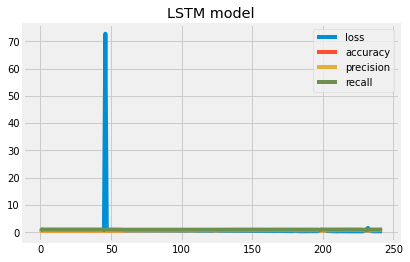

In [43]:
# Plot loss functions
plt.plot(LSTM_history.history['loss'], label='loss')
plt.plot(LSTM_history.history['accuracy'], label='accuracy')
plt.plot(LSTM_history.history['precision'], label='precision')
plt.plot(LSTM_history.history['recall'], label='recall')
plt.title('LSTM model')
plt.legend()
plt.show()

### Evaluate model performance

Classification models have a discrete output, and therefore require an evaluation metric which compares discrete classes in some form. Classification metrics evaluate a model performance and indicate how good or bad the classification is. The most popular metrics to evaluate a classification prediction model are:
- Accuracy
- Precision and Recall
- F1 score
- AUC ROC

To note that the confusion matrix, despite not being a metric, is fundamental when evaluating a classification model.

**Accuracy metrics must be used with caution on imbalanced datasets, as evaluation results will be biased**. To give a few examples:
- when using accuracy on an imbalanced problem, it is easy to get a high accuracy score by simply classifying all observations as the majority class
- when using the ROC curve on an imbalanced problem, false positive rate is pulled down due to a large number of true negatives

**The class imbalance problem has been addressed in section 3 above. Our evaluation measures and results are therefore coherent, as we now work with the SMOTE (oversampled) Choice B feature set**.

In [44]:
# Evaluate the LSTM model
LSTM_score_train = LSTM_model.evaluate(g, verbose=0)
LSTM_score_test = LSTM_model.evaluate(g_, verbose=0)
print(f'Train Accuracy:  {LSTM_score_train[1]*100:.4}%')
print(f'Test Accuracy:  {LSTM_score_test[1]*100:.4}%')

Train Accuracy:  85.88%
Test Accuracy:  48.88%


We start by measuring the accuracy of our LSTM model with a random set of hyper parameters on train and test sets. At this stage the LSTM model overfits, as the model performs well on in-sample data, but poorly on out-of-sample data. The classification report illustrates that the model performs well in predicting class 0 (negative RV-IV spread), but struggles in predicting class 1 (positive RV-IV spread).

In [45]:
# Classification report
y_pred_LSTM = np.where(LSTM_model.predict(g_, verbose=False) > 0.5, 1, 0)
print(classification_report(y_test[sequence_length:], y_pred_LSTM))

              precision    recall  f1-score   support

           0       0.95      0.38      0.55       466
           1       0.27      0.91      0.41       115

    accuracy                           0.49       581
   macro avg       0.61      0.65      0.48       581
weighted avg       0.81      0.49      0.52       581



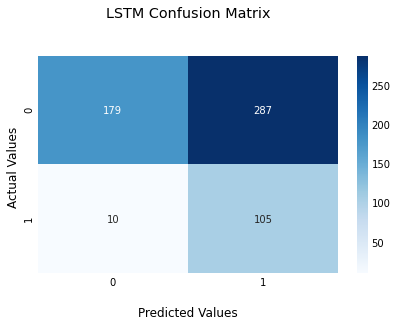

In [46]:
# Plot confusion matrix
cf_matrix_LSTM = confusion_matrix(y_test[sequence_length:], y_pred_LSTM)
ax = sn.heatmap(cf_matrix_LSTM, annot=True, cmap='Blues', fmt='g')
ax.set_title('LSTM Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
## Ticket labels
ax.xaxis.set_ticklabels(['0','1'])
ax.yaxis.set_ticklabels(['0','1'])
plt.show()

Unfortunately, at this stage, **our LSTM model performs just has good as the baseline model**: despite a better prediction in the class of interest (class 1, positive RV-IV spread), the model suffers in predicting negative RV-IV spread, as illustrated by the very large number of False Positive. **On a positive note, the ROC curve confirms that the LSTM model better distinguishes between the two classes than the baseline model, as the AUC score reaches to 65%**.

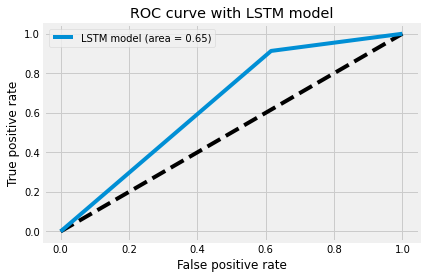

In [47]:
# Plot ROC curve
fpr_LSTM, tpr_LSTM, thresholds_LSTM = roc_curve(y_test[sequence_length:], y_pred_LSTM)
auc_LSTM = auc(fpr_LSTM, tpr_LSTM)
plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_LSTM, tpr_LSTM, label='LSTM model (area = {:.2f})'.format(auc_LSTM))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve with LSTM model')
plt.legend(loc='best')
plt.show()

In [ ]:
# Tensorboard model evaluation
%tensorboard --logdir ./tensorboard/logs

### Hyperparameter tuning

Now that our LSTM is built, we optimize the hyperparameters in order to get the best model possible. The process of choosing a set of optimal hyperparameters for a learning algorithm is called hyperparameter tuning or optimization. **Hyperparameters are parameters whose values are set before the learning process begins. By contrast, the value of simple parameters are derived via training the data**. In the case of a Neural Network, hyperparameters can be:
- number of hidden layers
- number of neurons
- learning rate
- activation function
- etc

Behind the tuning of hyperparameters for our model underlies an optimization problem, as the objective is to minimize the loss function by changing model parameters. It is key to find the best hyperparameters of a model inasmuch as they drive the model performance and speed as well as the quality of the predictions. Wikipedia sums it best: "**Hyperparameter optimization finds a tuple of hyperparameters that yields an optimal model which minimizes a predefined loss function on given test data. The objective function takes a tuple of hyperparameters and returns the associated loss**".

Various techniques exist such as Grid Search or Random Search, as illustrated in the picture below.

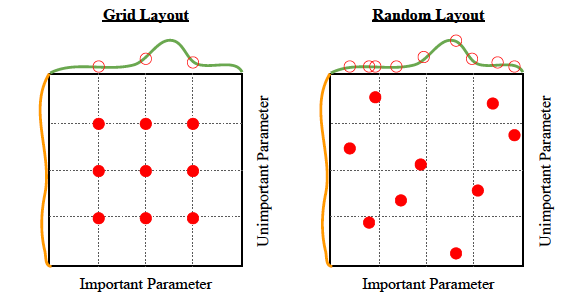

Another hyperparameter optimization is the Bayesian approach. **Bayesian methods attempt to build a function (more accurately, a probability distribution over possible function) that estimates how good your model might be for a certain choice of hyperparameters**. By using this approximate function (called a surrogate function), we do not have to go through the 'set, train, and evaluate' loop too many times, since only the surrogate function hyperparameters need to be optimized. **In short, a Bayesian Optimization runs models many times with different sets of hyperparameter values, and it evaluates the past model information to select hyperparameter values to build the newer model**.

We start the Bayesian Optimization of hyperparameters by setting up Early stopping as above, in order to avoid overfitting.

In [48]:
# Initialize early stopping, prevents model from overfitting/spending too much time training with minimal gains
LSTM_callback = [EarlyStopping(patience=10, monitor='loss', mode='min', verbose=1, restore_best_weights=True),
             TensorBoard(log_dir="./tensorboard/bologs")]

# BayesianOptimization algorithm from keras tuner
LSTM_botuner = BayesianOptimization(
    NN_model(hu=10, lookback=sequence_length, features=nb_features, modeltype='LSTM').HPoptim,
    objective='val_accuracy',
    max_trials=15,
    num_initial_points=2,
    hyperparameters=None,
    tune_new_entries=True,
    allow_new_entries=True,
    overwrite=True,
    directory="./keras",
    project_name="botrial")

# Launch tuning process
LSTM_botuner.search(g, epochs=50, validation_data=g_, callbacks=LSTM_callback, class_weight = class_weight, shuffle=False)

Trial 15 Complete [00h 01m 07s]
val_accuracy: 0.1979345977306366

Best val_accuracy So Far: 0.8227194547653198
Total elapsed time: 00h 15m 51s
INFO:tensorflow:Oracle triggered exit


In [50]:
# Display the best hyperparameter values for the model based on the defined objective function
LSTM_best_bohp = LSTM_botuner.get_best_hyperparameters()[0]
print(LSTM_best_bohp.values)

{'units1': 32, 'units2': 24, 'units3': 32, 'Dropout_rate': 0.0, 'learning_rate': 0.0001, 'activation': 'elu'}


Results of the Bayesian optimization of hyperparameters leads to the following conclusion for our final LSTM model:
- best number of nodes for the input layer: 32
- best number of nodes for the hidden layer: 24
- best number of nodes for the final layer: 32
- best dropout rate: 0
- best learning rate: 0.0001
- best activation function: relu
- best accuracy score: 82%

We now use the best hyperparameters that we have found with the Bayesian Optimization to **build an optimal LSTM model for our classification problem**.

In [51]:
# Define final model with tuned hyperparameters
final_LSTM_model = NN_model(hu=10, lookback=sequence_length, features=nb_features, modeltype='LSTM').HPoptim(LSTM_best_bohp)
# Model fitting
final_LSTM_history = final_LSTM_model.fit(g,
          epochs=500, 
          verbose=1, 
          callbacks=my_LSTM_callbacks, 
          shuffle=False,
          class_weight=class_weight)

Epoch 1/500
31/31 [==============================] - 4s 51ms/step - loss: 1.2438 - accuracy: 0.4973 - precision: 0.0000e+00 - recall: 0.0000e+00

Epoch 00001: loss did not improve from 0.30128
Epoch 2/500
31/31 [==============================] - 1s 36ms/step - loss: 1.0700 - accuracy: 0.6296 - precision: 0.5823 - recall: 0.9308

Epoch 00002: loss did not improve from 0.30128
Epoch 3/500
31/31 [==============================] - 1s 34ms/step - loss: 0.9628 - accuracy: 0.5027 - precision: 0.5027 - recall: 1.0000

Epoch 00003: loss did not improve from 0.30128
Epoch 4/500
31/31 [==============================] - 1s 34ms/step - loss: 0.8740 - accuracy: 0.5027 - precision: 0.5027 - recall: 1.0000

Epoch 00004: loss did not improve from 0.30128
Epoch 5/500
31/31 [==============================] - 1s 35ms/step - loss: 0.8171 - accuracy: 0.5027 - precision: 0.5027 - recall: 1.0000

Epoch 00005: loss did not improve from 0.30128
Epoch 6/500
31/31 [==============================] - 1s 39ms/step -

31/31 [==============================] - 1s 37ms/step - loss: 0.3862 - accuracy: 0.8138 - precision: 0.7517 - recall: 0.9399

Epoch 00086: loss did not improve from 0.30128
Epoch 87/500
31/31 [==============================] - 1s 36ms/step - loss: 0.3716 - accuracy: 0.8393 - precision: 0.7827 - recall: 0.9420

Epoch 00087: loss did not improve from 0.30128
Epoch 88/500
31/31 [==============================] - 1s 37ms/step - loss: 0.3643 - accuracy: 0.8414 - precision: 0.7851 - recall: 0.9425

Epoch 00088: loss did not improve from 0.30128
Epoch 89/500
31/31 [==============================] - 1s 38ms/step - loss: 0.3571 - accuracy: 0.8432 - precision: 0.7857 - recall: 0.9461

Epoch 00089: loss did not improve from 0.30128
Epoch 90/500
31/31 [==============================] - 1s 36ms/step - loss: 0.3476 - accuracy: 0.8493 - precision: 0.7920 - recall: 0.9496

Epoch 00090: loss did not improve from 0.30128
Epoch 91/500
31/31 [==============================] - 1s 37ms/step - loss: 0.3404 -

Epoch 127/500
31/31 [==============================] - 1s 41ms/step - loss: 0.2554 - accuracy: 0.8992 - precision: 0.8493 - recall: 0.9720

Epoch 00127: loss did not improve from 0.24376
Epoch 128/500
31/31 [==============================] - 1s 40ms/step - loss: 0.2593 - accuracy: 0.8754 - precision: 0.8180 - recall: 0.9674

Epoch 00128: loss did not improve from 0.24376
Epoch 129/500
31/31 [==============================] - 1s 38ms/step - loss: 0.2414 - accuracy: 0.8969 - precision: 0.8518 - recall: 0.9623

Epoch 00129: loss improved from 0.24376 to 0.24141, saving model to results/LSTM_time_series\model.h5
Epoch 130/500
31/31 [==============================] - 1s 38ms/step - loss: 0.2297 - accuracy: 0.8954 - precision: 0.8439 - recall: 0.9715

Epoch 00130: loss improved from 0.24141 to 0.22968, saving model to results/LSTM_time_series\model.h5
Epoch 131/500
31/31 [==============================] - 1s 40ms/step - loss: 0.2358 - accuracy: 0.8933 - precision: 0.8449 - recall: 0.9649

Ep

Epoch 167/500
31/31 [==============================] - 1s 41ms/step - loss: 0.2011 - accuracy: 0.9163 - precision: 0.8666 - recall: 0.9852

Epoch 00167: loss did not improve from 0.18165
Epoch 168/500
31/31 [==============================] - 1s 40ms/step - loss: 0.2023 - accuracy: 0.9102 - precision: 0.8655 - recall: 0.9725

Epoch 00168: loss did not improve from 0.18165
Epoch 169/500
31/31 [==============================] - 1s 40ms/step - loss: 0.1957 - accuracy: 0.9120 - precision: 0.8666 - recall: 0.9751

Epoch 00169: loss did not improve from 0.18165
Epoch 170/500
31/31 [==============================] - 1s 41ms/step - loss: 0.1991 - accuracy: 0.9002 - precision: 0.8492 - recall: 0.9746

Epoch 00170: loss did not improve from 0.18165
Epoch 171/500
31/31 [==============================] - 1s 44ms/step - loss: 0.1918 - accuracy: 0.9256 - precision: 0.8861 - recall: 0.9776

Epoch 00171: loss did not improve from 0.18165
Epoch 172/500
31/31 [==============================] - 1s 42ms/st

We plot again the evolution of loss, accuracy, precision and recall as per the number of epochs for our final LSTM model. As above, fluctuations in training over loss epochs are the consequence of neural networks being trained with different forms of stochastic gradient descent - although fluctuations are less pronounced here. **All accuracy metrics plateau after 150 epochs**.

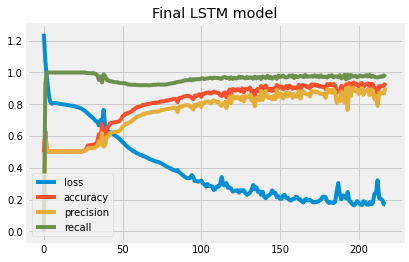

In [53]:
# Plot loss functions
plt.plot(final_LSTM_history.history['loss'], label='loss')
plt.plot(final_LSTM_history.history['accuracy'], label='accuracy')
plt.plot(final_LSTM_history.history['precision'], label='precision')
plt.plot(final_LSTM_history.history['recall'], label='recall')
plt.title('Final LSTM model')
plt.legend()
plt.show()

### Evaluate tuned model performance

As above, **we evaluate the performance of our LSTM model run with the best hyperparameters**, and compare both Train and Test accuracy before and after the Bayesian Optimization.

In [54]:
# Evaluate the LSTM model with best parameters
final_LSTM_score_train = final_LSTM_model.evaluate(g, verbose=0)
final_LSTM_score_test = final_LSTM_model.evaluate(g_, verbose=0)
print(f'Train Accuracy: {final_LSTM_score_train[1]*100:.4}% | Model improvement: {(final_LSTM_score_train[1]/LSTM_score_train[1]-1)*100:.4}%')
print(f'Test Accuracy: {final_LSTM_score_test[1]*100:.4}% | Model improvement: {(final_LSTM_score_test[1]/LSTM_score_test[1]-1)*100:.4}%')

Train Accuracy: 90.71% | Model improvement: 5.63%
Test Accuracy: 76.76% | Model improvement: 57.04%


**Bayesian Optimization resulted in a much better LSTM model** for two main reasons:
- The model is less prone to overfitting and generalizes better, as the difference between train and test accuracy dropped by almost 2/3.
- Test accuracy improved by 57%. A performance accuracy in out-of-sample prediction of 77% is a good score.

In [55]:
# LSTM lassification report with best parameters
final_y_pred_LSTM = np.where(final_LSTM_model.predict(g_, verbose=False) > 0.5, 1, 0)
print(classification_report(y_test[sequence_length:], final_y_pred_LSTM))

              precision    recall  f1-score   support

           0       0.92      0.77      0.84       466
           1       0.45      0.74      0.56       115

    accuracy                           0.77       581
   macro avg       0.69      0.76      0.70       581
weighted avg       0.83      0.77      0.79       581



The confusion matrix validates that our LSTM with the optimal set of hyperparameters performs well, as **true predictions largely exceed false predictions**. We now - happily - note that **our LSTM model outperforms significantly the baseline model, which validates the purpose of the model**.

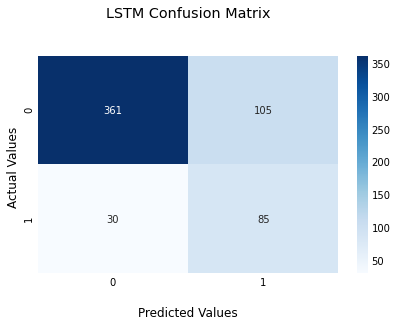

In [57]:
# Plot confusion matrix
final_cf_matrix_LSTM = confusion_matrix(y_test[sequence_length:], final_y_pred_LSTM)
ax = sn.heatmap(final_cf_matrix_LSTM, annot=True, cmap='Blues', fmt='g')
ax.set_title('LSTM Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
## Ticket labels
ax.xaxis.set_ticklabels(['0','1'])
ax.yaxis.set_ticklabels(['0','1'])
plt.show()

Finally, **the ROC curve confirms final LSTM model's ability to distinguish between the two classes**, as the AUC score reaches 76%.

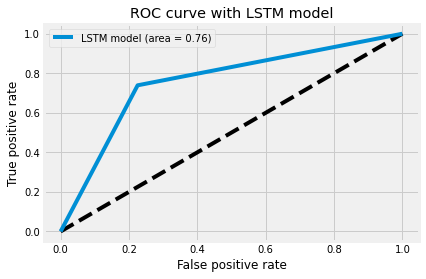

In [58]:
# Plot ROC curve
fpr_final_LSTM, tpr_final_LSTM, thresholds_final_LSTM = roc_curve(y_test[sequence_length:], final_y_pred_LSTM)
final_auc_LSTM = auc(fpr_final_LSTM, tpr_final_LSTM)
plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_final_LSTM, tpr_final_LSTM, label='LSTM model (area = {:.2f})'.format(final_auc_LSTM))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve with LSTM model')
plt.legend(loc='best')
plt.show()

In [ ]:
# Tensorboard model evaluation
%tensorboard --logdir ./tensorboard/logs

### Model backtest

As a final step, we visualize our LSTM model predictions of the Eurostoxx 50 RV-IV spread against observed realized and implied volatility.

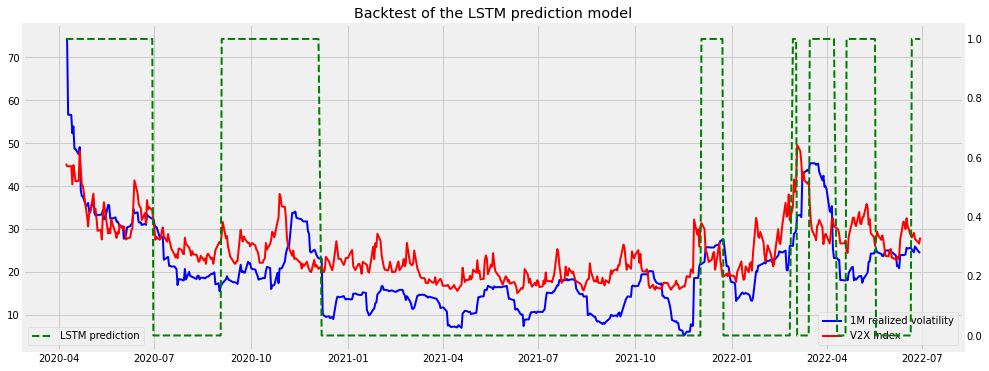

In [85]:
# Resume main variables of interest in a dataframe
df_ = y_test[sequence_length:]
LSTM_predicted = pd.DataFrame(final_y_pred_LSTM, index=df_.index)
LSTM_predicted.columns = ['Predicted']
LSTM_strategy = pd.concat([df[['SX5E Index','Return','Label','SX5E Index_Volatility_21d','V2X Index']], LSTM_predicted], axis=1).dropna()
# Model backtest
fig, ax1 = plt.subplots(figsize=(15,6));
ax2 = ax1.twinx()
ax1.plot(LSTM_strategy.index,LSTM_strategy['SX5E Index_Volatility_21d']*100*(252)**0.5, 'b-', linewidth=2,label='1M realized volatility')
ax1.plot(LSTM_strategy.index,LSTM_strategy['V2X Index'], 'r-',linewidth=2,label = 'V2X Index')
ax1.legend(loc='lower right')
ax2.plot(LSTM_strategy.index, LSTM_strategy['Predicted'], 'g--', linewidth=2, label = 'LSTM prediction')
ax2.grid(False)
ax2.legend(loc='lower left');
plt.title('Backtest of the LSTM prediction model');

We note that **observed and predicted volatility spread signal are most of the time consistent!**
- Our LSTM prediction model correctly predicts all instances where the realized volatility is above the implied volatility
- Although our LSTM model is sometimes wrong in predicting a positive RV-IV spread, we note that the model was close from being right, , as wrong predictions were driven by a sharpe increase in realized volatility which brought it close - but still below, the implied volatility.

## Gated Reccurent Units (GRU) model

As mentioned above, and unlike Feed Forward Neural Networks, **RNNs contain recurrent units in their hidden layers, which allow the algorithm to process sequence data**. This is done by recurrently passing hidden states from previous timesteps and combining them with inputs of the current one. **GRU is an alternative cell design that uses fewer parameters and computes faster compared to LSTM**. GRU is similar to LSTM, but it has fewer gates. Also, it relies solely on a hidden state for memory transfer between recurrent units, so there is no separate cell state.

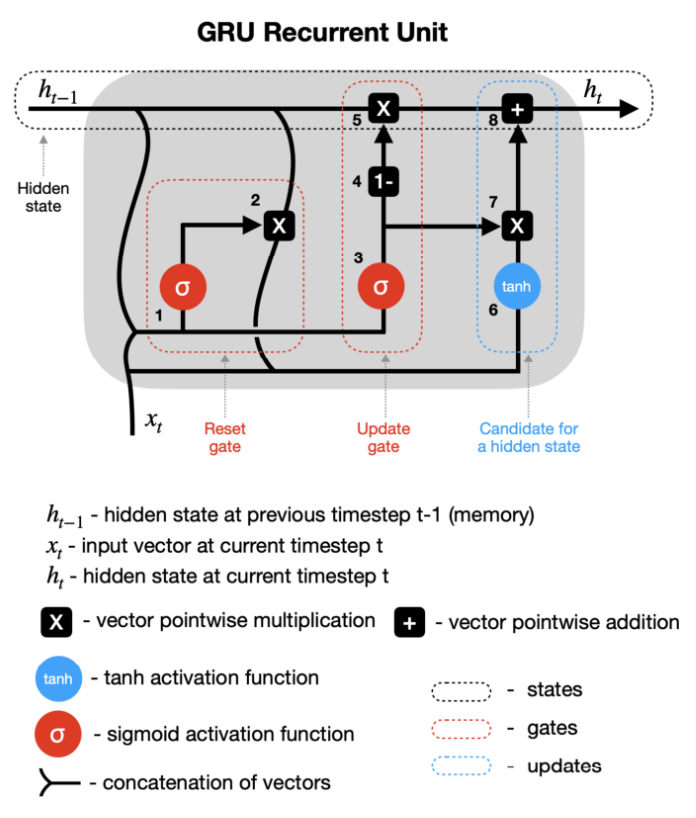

**The idea of section 6 is to go through exactly the exact same process than section 5, but with a GRU model rather than a LSTM model, in order to compare the performance of the two for an aligned set-up**. Of course, GRU and LSTM model final models will be based on different hyperparameters, as per the stochastic nature of the Bayesian optimization, nevertheless the layer structure remains the same.

As a reminder: The LSTM and GRU models have an aligned structure for comparability reasons:

- Stacked structure of 3 hidden layers between an input layer and an output layer
- Dropout regularization for the model to generalize better after the first two hidden layers
- Adam optimizer
- Binary Cross Entropy loss function as we deal with a classification problem

### Build model

As per the model class that we built in section 4.1 above, we build our GRU model based on a random set of nodes.

In [60]:
# GRU network
GRU_model = NN_model(hu=10, lookback=sequence_length, features=nb_features, modeltype='GRU').create
# GRU model summary
GRU_model = GRU_model()
GRU_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
GRU1 (GRU)                   (None, 21, 20)            3720      
_________________________________________________________________
Dropout1 (Dropout)           (None, 21, 20)            0         
_________________________________________________________________
GRU2 (GRU)                   (None, 21, 10)            960       
_________________________________________________________________
Dropout2 (Dropout)           (None, 21, 10)            0         
_________________________________________________________________
GRU3 (GRU)                   (None, 10)                660       
_________________________________________________________________
Output (Dense)               (None, 1)                 11        
Total params: 5,351
Trainable params: 5,351
Non-trainable params: 0
______________________________________________________

As above, we set-up Early Stopping to prevent our GRU model from overfitting, so it can generalize better.

In [61]:
# Create path to store GRU model results
GRU_results_path = Path('results', 'GRU_time_series')
if not GRU_results_path.exists():
    GRU_results_path.mkdir(parents=True)

# Specify callback functions
GRU_model_path = (GRU_results_path / 'model.h5').as_posix()
logdir = os.path.join('./tensorboard/logs', dt.datetime.now().strftime('%Y%m%d-%H%M%S'))

my_GRU_callbacks = [
    EarlyStopping(patience=20, monitor='loss', mode='min', verbose=1, restore_best_weights=True),
    ModelCheckpoint(filepath=GRU_model_path, verbose=1, monitor='loss', save_best_only=True),
    TensorBoard(log_dir=logdir, histogram_freq=1)
]

# Produce class weights
class_weight = cwts(df)

We now fit the GRU model on the train dataset. Dropout and Early stopping regularization technique are now in place for the GRU to generalize as best as possible.

In [62]:
# Model fitting
GRU_history = GRU_model.fit(g,
          epochs=500, 
          verbose=1, 
          callbacks=my_GRU_callbacks, 
          shuffle=False,
          class_weight=class_weight)

Epoch 1/500
31/31 [==============================] - 5s 65ms/step - loss: 0.9807 - accuracy: 0.6567 - precision: 0.6189 - recall: 0.8249: 0s - loss: 0.9369 - accuracy: 0.5806 - precision: 0.4775 - recall: 0.7

Epoch 00001: loss improved from inf to 0.98072, saving model to results/GRU_time_series\model.h5
Epoch 2/500
31/31 [==============================] - 1s 28ms/step - loss: 0.8140 - accuracy: 0.5027 - precision: 0.5027 - recall: 1.0000

Epoch 00002: loss improved from 0.98072 to 0.81402, saving model to results/GRU_time_series\model.h5
Epoch 3/500
31/31 [==============================] - 1s 27ms/step - loss: 0.8439 - accuracy: 0.5027 - precision: 0.5027 - recall: 1.0000

Epoch 00003: loss did not improve from 0.81402
Epoch 4/500
31/31 [==============================] - 1s 28ms/step - loss: 0.8375 - accuracy: 0.5027 - precision: 0.5027 - recall: 1.0000

Epoch 00004: loss did not improve from 0.81402
Epoch 5/500
31/31 [==============================] - 1s 27ms/step - loss: 0.8391 - a

Epoch 38/500
31/31 [==============================] - 1s 27ms/step - loss: 0.4565 - accuracy: 0.7994 - precision: 0.7384 - recall: 0.9308

Epoch 00038: loss improved from 0.46931 to 0.45649, saving model to results/GRU_time_series\model.h5
Epoch 39/500
31/31 [==============================] - 1s 27ms/step - loss: 0.4456 - accuracy: 0.7971 - precision: 0.7392 - recall: 0.9216

Epoch 00039: loss improved from 0.45649 to 0.44559, saving model to results/GRU_time_series\model.h5
Epoch 40/500
31/31 [==============================] - 1s 26ms/step - loss: 0.4367 - accuracy: 0.8058 - precision: 0.7492 - recall: 0.9226

Epoch 00040: loss improved from 0.44559 to 0.43669, saving model to results/GRU_time_series\model.h5
Epoch 41/500
31/31 [==============================] - 1s 27ms/step - loss: 0.4238 - accuracy: 0.8079 - precision: 0.7527 - recall: 0.9201

Epoch 00041: loss improved from 0.43669 to 0.42380, saving model to results/GRU_time_series\model.h5
Epoch 42/500
31/31 [====================

Epoch 75/500
31/31 [==============================] - 1s 29ms/step - loss: 0.2927 - accuracy: 0.8736 - precision: 0.8276 - recall: 0.9455

Epoch 00075: loss did not improve from 0.28230
Epoch 76/500
31/31 [==============================] - 1s 28ms/step - loss: 0.2830 - accuracy: 0.8573 - precision: 0.8010 - recall: 0.9527

Epoch 00076: loss did not improve from 0.28230
Epoch 77/500
31/31 [==============================] - 1s 30ms/step - loss: 0.2927 - accuracy: 0.8762 - precision: 0.8272 - recall: 0.9527

Epoch 00077: loss did not improve from 0.28230
Epoch 78/500
31/31 [==============================] - 1s 28ms/step - loss: 0.2759 - accuracy: 0.8596 - precision: 0.8000 - recall: 0.9608

Epoch 00078: loss improved from 0.28230 to 0.27594, saving model to results/GRU_time_series\model.h5
Epoch 79/500
31/31 [==============================] - 1s 30ms/step - loss: 0.2705 - accuracy: 0.8685 - precision: 0.8110 - recall: 0.9628

Epoch 00079: loss improved from 0.27594 to 0.27049, saving mode

31/31 [==============================] - 1s 30ms/step - loss: 0.1823 - accuracy: 0.9107 - precision: 0.8636 - recall: 0.9766

Epoch 00153: loss did not improve from 0.18093
Epoch 154/500
31/31 [==============================] - 1s 29ms/step - loss: 0.1841 - accuracy: 0.9115 - precision: 0.8645 - recall: 0.9771

Epoch 00154: loss did not improve from 0.18093
Epoch 155/500
31/31 [==============================] - 1s 29ms/step - loss: 0.1874 - accuracy: 0.9130 - precision: 0.8671 - recall: 0.9766

Epoch 00155: loss did not improve from 0.18093
Epoch 156/500
31/31 [==============================] - 1s 29ms/step - loss: 0.1783 - accuracy: 0.9151 - precision: 0.8713 - recall: 0.9751

Epoch 00156: loss improved from 0.18093 to 0.17833, saving model to results/GRU_time_series\model.h5
Epoch 157/500
31/31 [==============================] - 1s 29ms/step - loss: 0.1928 - accuracy: 0.9084 - precision: 0.8598 - recall: 0.9771

Epoch 00157: loss did not improve from 0.17833
Epoch 158/500
31/31 [====

Epoch 194/500
31/31 [==============================] - 1s 30ms/step - loss: 0.1648 - accuracy: 0.9163 - precision: 0.8696 - recall: 0.9807: 1s - loss: 0.4459 - accuracy: 0.7148 - precision: 0.3761 - 

Epoch 00194: loss did not improve from 0.16088
Epoch 195/500
31/31 [==============================] - 1s 30ms/step - loss: 0.1645 - accuracy: 0.9197 - precision: 0.8747 - recall: 0.9807

Epoch 00195: loss did not improve from 0.16088
Epoch 196/500
31/31 [==============================] - 1s 32ms/step - loss: 0.1665 - accuracy: 0.9225 - precision: 0.8788 - recall: 0.9812

Epoch 00196: loss did not improve from 0.16088
Epoch 197/500
31/31 [==============================] - 1s 36ms/step - loss: 0.1594 - accuracy: 0.9233 - precision: 0.8789 - recall: 0.9827

Epoch 00197: loss improved from 0.16088 to 0.15942, saving model to results/GRU_time_series\model.h5
Epoch 198/500
31/31 [==============================] - 1s 30ms/step - loss: 0.1641 - accuracy: 0.9202 - precision: 0.8769 - recall: 0.978

31/31 [==============================] - 1s 29ms/step - loss: 0.1612 - accuracy: 0.9227 - precision: 0.8799 - recall: 0.9802

Epoch 00234: loss did not improve from 0.14591
Epoch 235/500
31/31 [==============================] - 1s 30ms/step - loss: 0.1553 - accuracy: 0.9256 - precision: 0.8815 - recall: 0.9842

Epoch 00235: loss did not improve from 0.14591
Epoch 236/500
31/31 [==============================] - 1s 29ms/step - loss: 0.1565 - accuracy: 0.9291 - precision: 0.8882 - recall: 0.9827

Epoch 00236: loss did not improve from 0.14591
Epoch 237/500
31/31 [==============================] - 1s 30ms/step - loss: 0.1732 - accuracy: 0.9222 - precision: 0.8818 - recall: 0.9761

Epoch 00237: loss did not improve from 0.14591
Epoch 238/500
31/31 [==============================] - 1s 33ms/step - loss: 0.1706 - accuracy: 0.9056 - precision: 0.8500 - recall: 0.9863
Restoring model weights from the end of the best epoch.

Epoch 00238: loss did not improve from 0.14591
Epoch 00238: early stop

The graph below illustrates the evolution of the training loss, but also the accuracy, recall and precision as number of epochs increase for our GRU model. Fluctuations in training over loss epochs are the consequence of neural networks being trained with different forms of stochastic gradient descent.

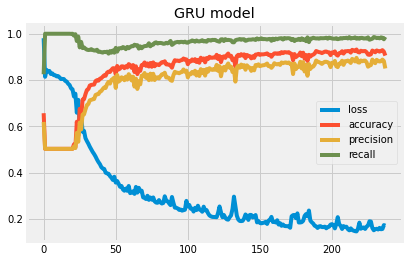

In [63]:
# Plot loss functions
plt.plot(GRU_history.history['loss'], label='loss')
plt.plot(GRU_history.history['accuracy'], label='accuracy')
plt.plot(GRU_history.history['precision'], label='precision')
plt.plot(GRU_history.history['recall'], label='recall')
plt.title('GRU model')
plt.legend()
plt.show()

### Evaluate model performance

In [64]:
# Evaluate the GRU model
GRU_score_train = GRU_model.evaluate(g, verbose=0)
GRU_score_test = GRU_model.evaluate(g_, verbose=0)
print(f'Train Accuracy:  {GRU_score_train[1]*100:.4}%')
print(f'Test Accuracy:  {GRU_score_test[1]*100:.4}%')

Train Accuracy:  92.2%
Test Accuracy:  64.37%


Performance results are encouraging, as the GRU model performs reasonably well out-of sample with an accuracy of 64%. At this stage, the model still overfits, as there is almost 30% difference between the train and test accuracy. The classification report illustrates that the model performs well in predicting class 0 (negative RV-IV spread), but struggles more in predicting class 1 (positive RV-IV spread).

In [65]:
# Classification report
y_pred_GRU = np.where(GRU_model.predict(g_, verbose=False) > 0.5, 1, 0)
print(classification_report(y_test[sequence_length:], y_pred_GRU))

              precision    recall  f1-score   support

           0       0.95      0.59      0.73       466
           1       0.34      0.87      0.49       115

    accuracy                           0.64       581
   macro avg       0.65      0.73      0.61       581
weighted avg       0.83      0.64      0.68       581



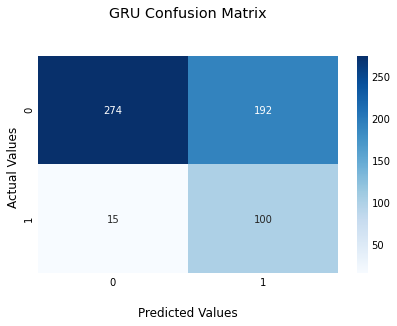

In [66]:
# Plot confusion matrix
cf_matrix_GRU = confusion_matrix(y_test[sequence_length:], y_pred_GRU)
ax = sn.heatmap(cf_matrix_GRU, annot=True, cmap='Blues', fmt='g')
ax.set_title('GRU Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
## Ticket labels
ax.xaxis.set_ticklabels(['0','1'])
ax.yaxis.set_ticklabels(['0','1'])
plt.show();

We - happily - note that with our random set of hyper parameters, **our GRU classification model performs better than our baseline model**, as we have more true predictions and less false predictions. **The ROC curve confirms that the model is able to correctly distinguish between the two classes**, as the AUC score reaches 73%.

We also note that **at the same stage, the GRU model outperforms the LSTM model**, as it has more true predictions and less false predictions.

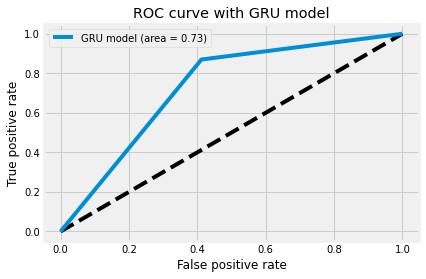

In [67]:
# Plot ROC curve
fpr_GRU, tpr_GRU, thresholds_GRU = roc_curve(y_test[sequence_length:], y_pred_GRU)
auc_GRU = auc(fpr_GRU, tpr_GRU)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_GRU, tpr_GRU, label='GRU model (area = {:.2f})'.format(auc_GRU))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve with GRU model')
plt.legend(loc='best')
plt.show()

### Hyperparameter tuning

As for the LSTM model, we conduct a **Bayesian Optimization in order to find the best hyperparameters for our GRU model**. As a reminder, the **Early Stopping that we set up at first is a regularization technique** in order to prevent the model from overfitting.

In [68]:
# Define the call back function
GRU_callback = [EarlyStopping(patience=10, monitor='loss', mode='min', verbose=1, restore_best_weights=True),
             TensorBoard(log_dir="./tensorboard/bologs")]

# BayesianOptimization algorithm from keras tuner
GRU_botuner = BayesianOptimization(
    NN_model(hu=10, lookback=sequence_length, features=nb_features, modeltype='GRU').HPoptim,
    objective='val_accuracy',
    max_trials=15,
    num_initial_points=2,
    hyperparameters=None,
    tune_new_entries=True,
    allow_new_entries=True,
    overwrite=True,
    directory="./keras",
    project_name="botrial")

# Run the tuning process
GRU_botuner.search(g, epochs=50, validation_data=g_, callbacks=GRU_callback, class_weight = class_weight, shuffle=False)

Trial 15 Complete [00h 01m 08s]
val_accuracy: 0.6368330717086792

Best val_accuracy So Far: 0.7228915691375732
Total elapsed time: 00h 09m 02s
INFO:tensorflow:Oracle triggered exit


In [69]:
# Display the best hyperparameter values for the model based on the defined objective function
GRU_best_bohp = GRU_botuner.get_best_hyperparameters()[0]
print(GRU_best_bohp.values)

{'units1': 12, 'units2': 20, 'units3': 12, 'Dropout_rate': 0.30000000000000004, 'learning_rate': 0.01, 'activation': 'elu'}


Results of the Bayesian optimization of hyperparameters leads to the following conclusion for our final GRU model:
- best number of nodes for the input layer: 12
- best number of nodes for the hidden layer: 20
- best number of nodes for the final layer: 12
- best dropout rate: 0.3
- best learning rate: 0.01
- best activation function: elu
- best accuracy score of 72%

We now use the best hyperparameters that we have found with the Bayesian Optimization to **build an optimal GRU model for our classification problem**.

In [70]:
# Define final model with tuned hyperparameters
final_GRU_model = NN_model(hu=10, lookback=sequence_length, features=nb_features, modeltype='GRU').HPoptim(GRU_best_bohp)
# Model fitting
final_GRU_history = final_GRU_model.fit(g,
          epochs=500, 
          verbose=1, 
          callbacks=my_GRU_callbacks, 
          shuffle=False,
          class_weight=class_weight)

Epoch 1/500
31/31 [==============================] - 5s 52ms/step - loss: 0.9513 - accuracy: 0.6321 - precision: 0.6106 - recall: 0.7405

Epoch 00001: loss did not improve from 0.14591
Epoch 2/500
31/31 [==============================] - 1s 30ms/step - loss: 1.1439 - accuracy: 0.4682 - precision: 0.4825 - recall: 0.8015

Epoch 00002: loss did not improve from 0.14591
Epoch 3/500
31/31 [==============================] - 1s 28ms/step - loss: 1.0311 - accuracy: 0.4779 - precision: 0.4886 - recall: 0.8260

Epoch 00003: loss did not improve from 0.14591
Epoch 4/500
31/31 [==============================] - 1s 30ms/step - loss: 0.9587 - accuracy: 0.5027 - precision: 0.5027 - recall: 1.0000

Epoch 00004: loss did not improve from 0.14591
Epoch 5/500
31/31 [==============================] - 1s 28ms/step - loss: 0.8553 - accuracy: 0.5027 - precision: 0.5027 - recall: 1.0000

Epoch 00005: loss did not improve from 0.14591
Epoch 6/500
31/31 [==============================] - 1s 28ms/step - loss: 0

31/31 [==============================] - 1s 30ms/step - loss: 0.2383 - accuracy: 0.8693 - precision: 0.8086 - recall: 0.9695

Epoch 00087: loss did not improve from 0.14591
Epoch 88/500
31/31 [==============================] - 1s 31ms/step - loss: 0.2264 - accuracy: 0.8795 - precision: 0.8209 - recall: 0.9725

Epoch 00088: loss did not improve from 0.14591
Epoch 89/500
31/31 [==============================] - 1s 31ms/step - loss: 0.2314 - accuracy: 0.8734 - precision: 0.8130 - recall: 0.9715

Epoch 00089: loss did not improve from 0.14591
Epoch 90/500
31/31 [==============================] - 1s 31ms/step - loss: 0.2445 - accuracy: 0.8585 - precision: 0.7944 - recall: 0.9695

Epoch 00090: loss did not improve from 0.14591
Epoch 91/500
31/31 [==============================] - 1s 30ms/step - loss: 0.3361 - accuracy: 0.8404 - precision: 0.7850 - recall: 0.9399+0 - ETA: 1s - loss: 0.4886 - accuracy: 0.8229 - precision: 0.4222 - recall:

Epoch 00091: loss did not improve from 0.14591
Epoch 9

We plot again the evolution of loss, accuracy, precision and recall as per the number of epochs for our final GRU model. As above, fluctuations in training over loss epochs are the consequence of neural networks being trained with different forms of stochastic gradient descent - although fluctuations are less pronounced here. **All metrics plateau around 100 epochs**.

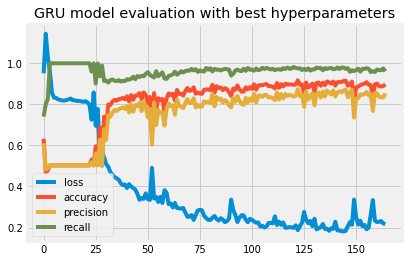

In [71]:
# Plot loss functions
plt.plot(final_GRU_history.history['loss'], label='loss')
plt.plot(final_GRU_history.history['accuracy'], label='accuracy')
plt.plot(final_GRU_history.history['precision'], label='precision')
plt.plot(final_GRU_history.history['recall'], label='recall')
plt.title('GRU model evaluation with best hyperparameters')
plt.legend()
plt.show()

### Evaluate tuned model performance

We now **evaluate the performance of our GRU model run with the best hyperparameters**, and compare both Train and Test accuracy before and after the Bayesian Optimization.

In [72]:
# Evaluate the LSTM model with best parameters
final_GRU_score_train = final_GRU_model.evaluate(g, verbose=0)
final_GRU_score_test = final_GRU_model.evaluate(g_, verbose=0)
print(f'Train Accuracy: {final_GRU_score_train[1]*100:.4}% | Model improvement: {(final_GRU_score_train[1]/GRU_score_train[1]-1)*100:.4}%')
print(f'Test Accuracy: {final_GRU_score_test[1]*100:.4}% | Model improvement: {(final_GRU_score_test[1]/GRU_score_test[1]-1)*100:.4}%')

Train Accuracy: 92.91% | Model improvement: 0.7769%
Test Accuracy: 74.18% | Model improvement: 15.24%


**Bayesian Optimization resulted in a much better GRU model** for two main reasons:
- The model is less prone to overfitting and generalizes better, as train accuracy remained unchanged while test accuracy increased.
- Test accuracy improved by 15%. A performance accuracy in out-of-sample prediction of 74% is a good accuracy score.

In [73]:
# LSTM lassification report with best parameters
final_y_pred_GRU = np.where(final_GRU_model.predict(g_, verbose=False) > 0.5, 1, 0)
print(classification_report(y_test[sequence_length:], final_y_pred_GRU))

              precision    recall  f1-score   support

           0       0.95      0.71      0.82       466
           1       0.42      0.85      0.57       115

    accuracy                           0.74       581
   macro avg       0.69      0.78      0.69       581
weighted avg       0.85      0.74      0.77       581



The confusion matrix validates that our LSTM with the optimal set of hyperparameters performs well, as **true predictions largely exceed false predictions**.

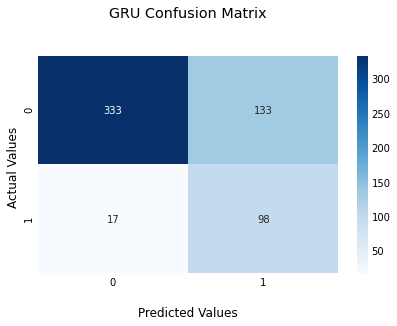

In [74]:
# Plot confusion matrix
final_cf_matrix_GRU = confusion_matrix(y_test[sequence_length:], final_y_pred_GRU)
ax = sn.heatmap(final_cf_matrix_GRU, annot=True, cmap='Blues', fmt='g')
ax.set_title('GRU Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
## Ticket labels
ax.xaxis.set_ticklabels(['0','1'])
ax.yaxis.set_ticklabels(['0','1'])
plt.show()

Finally, **the ROC curve confirms that our GRU model is able to distinguish between the two classes**, as the AUC score reaches 78%.

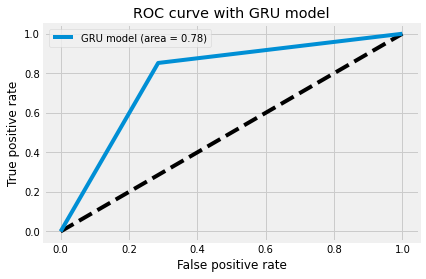

In [75]:
# Plot ROC curve
fpr_final_GRU, tpr_final_GRU, thresholds_final_GRU = roc_curve(y_test[sequence_length:], final_y_pred_GRU)
final_auc_GRU = auc(fpr_final_GRU, tpr_final_GRU)
plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_final_GRU, tpr_final_GRU, label='GRU model (area = {:.2f})'.format(final_auc_GRU))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve with GRU model')
plt.legend(loc='best')
plt.show()

### Model backtest

As a final step, we visualize our GRU model predictions of the Eurostoxx 50 RV-IV spread on the next trading day against observed realized and implied volatility.

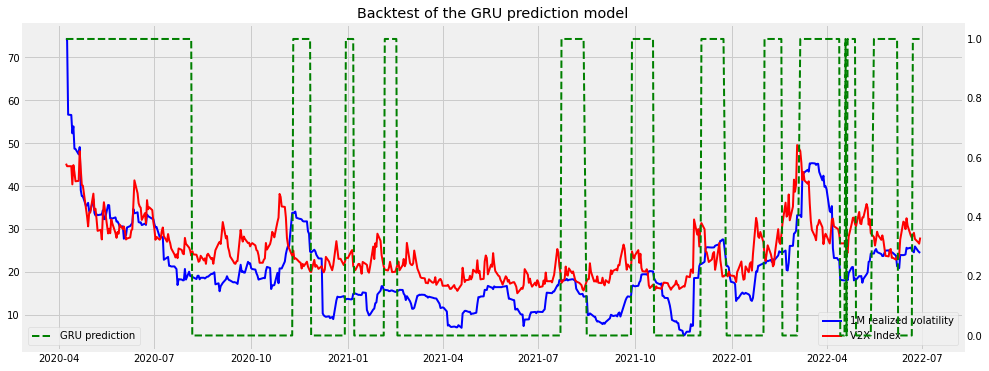

In [89]:
# Resume main variables of interest in a dataframe
df_ = y_test[sequence_length:]
GRU_predicted = pd.DataFrame(final_y_pred_GRU, index=df_.index)
GRU_predicted.columns = ['Predicted']
GRU_strategy = pd.concat([df[['SX5E Index','Return','Label','SX5E Index_Volatility_21d','V2X Index']], GRU_predicted], axis=1).dropna()
# Model backtest
fig, ax1 = plt.subplots(figsize=(15,6));
ax2 = ax1.twinx()
ax1.plot(GRU_strategy.index,GRU_strategy['SX5E Index_Volatility_21d']*100*(252)**0.5, 'b-', linewidth=2,label='1M realized volatility')
ax1.plot(GRU_strategy.index,GRU_strategy['V2X Index'], 'r-',linewidth=2,label = 'V2X Index')
ax1.legend(loc='lower right')
ax2.plot(GRU_strategy.index, GRU_strategy['Predicted'], 'g--', linewidth=2, label = 'GRU prediction')
ax2.grid(False)
ax2.legend(loc='lower left');
plt.title('Backtest of the GRU prediction model');

We note that **observed and predicted volatility spread signal are most of the time consistent!**
- Our GRU prediction model mostly correctly predicts all instances where the realized volatility is above the implied volatility.
- Although our GRU model is sometimes wrong in predicting a positive RV-IV spread, we note that the model was close from being right, as wrong predictions were driven by a sharpe increase in realized volatility which brought it close - but still below, the implied volatility.

## Conclusion: LSTM or GRU?

In this notebook, we built two RNNs aside, one LSTM and one GRU, in order to compare their performance in a classification problem. Both models were built on the same set-up, that is:
- Stacked structure of 3 layers between an input layer and an output layer
- Dropout regularization for the model to generalize better after the first 2 hidden layers
- Adam optimizer
- Binary Cross Entropy loss function as we deal with a classification problem

For both models, we ran a Bayesian Optimization in order to find the respective best hyperparameters for each model. As main observations, we note:

1. **In-sample and out-of-sample accuracy are very good for both models**: 
    - LSTM: respectively 91% and 77%
    - GRU: respectively 93% and 74%

Both models roughly equally overfit as their accuracies are similar, and so is the spread between train and test accuracy.


2. **Both models beat the baseline model by far. Also, GRU predicts better the class of interest (class 1, positive RV-IV spread) than LSTM, however to the detriment of the other class (class 0, negative RV-IV spread)**:
    - Baseline: 283 true predictions (TN: 224, TP: 59) and 298 false predictions (FN: 56, FP: 242)
    - LSTM: 446 true predictions (TN: 361, TP: 85) and 135 false predictions (FN: 30, FP: 105)
    - GRU: 431 true predictions (TN: 333, TP: 98) and 150 false predictions (FN: 17, FP: 133)


3. **GRU model distinguishes better between the two classes than LSTM and baseline models**
    - baseline ROC auc: 50%
    - LSTM ROC auc: 76%
    - GRU ROC auc: 78%


4. **GRU is faster to converge than LSTM**
    - GRU needs 100 epochs to converge while LSTM requires 150 epochs
    - GRU is also faster, as hyperparameter tuning process takes 9 minutes, against 16 minutes for LSTM

For all the 4 reasons cited above, we can conclude that, **for this classification prediction exercise, the GRU model performs better than the LSTM model**

# Part III: Support to Risk Management

## Risk Management strategy

The main challenge that risk managers face is to obtain quality forward-looking measures. Indeed, if backward looking measures are easy to get and calculate, they come with the strong assumption that what happened in the past will happen in the future. However, despite we can see some similarities with past situations, we cannot simply assume that past is a good predictor of the future. In risk management, volatility and correlation between assets are equally important to estimate the risk of a portfolio. 

From Part II above (sections 4, 5 and 6), we now have a volatility prediction model. **The goal of this section is to leverage our classification prediction models and machine learning techniques to propose a methodology to compute a forward-looking portfolio Value-at-Risk**, according to the process below:
1. Build some random portfolio made of Eurostoxx 50 underlying securities
2. Calculate the historical covariance matrix of the portfolio
3. Estimate the de-noised Theory-Implied Covariance (TIC) matrix
4. Fit in the volatility prediction in matrix obtained at step 3
5. Calculate portfolio risk

### Pre-processing

Let's now create an investment portfolio made of underlying assets of the Eurostoxx 50 Index from where we will derive portfolio risk measures. We first retrieve time series of all 50 underlying assets from 01 July 2017 until 30 June 2022. 

In [124]:
# Read components of dow from Yahoo Finance
ES50 = pd.read_html('https://en.wikipedia.org/wiki/EURO_STOXX_50')
# Retrieve stock symbol
ES50_stocks = list(ES50[2]['Ticker'])
ES50_names = list(ES50[2]['Name'])
# Retrieve stock data 
ES50_ohlc = {symbol: yf.download(symbol, start='2017-07-01', end='2022-06-30', auto_adjust=True, progress=False) for symbol in ES50_stocks}
# Save the dictionary
np.save('C:/Users/zacha/OneDrive/Desktop/CQF/Project/ES50_ohlc.npy', ES50_ohlc)
# Load ES50_ohlc dictionary
ohlc = np.load('C:/Users/zacha/OneDrive/Desktop/CQF/Project/ES50_ohlc.npy', allow_pickle='TRUE').item()
# Store stock prices in a dataframe
asset_prices = pd.DataFrame({symbol: ohlc[symbol]['Close'] for symbol in ES50_stocks})
# Check for missing values
asset_prices.isnull().sum()

ADS.DE       20
ADYEN.AS    245
AD.AS         4
AI.PA         3
AIR.PA        3
ALV.DE       18
ABI.BR        4
ASML.AS       4
CS.PA         3
BAS.DE       18
BAYN.DE      18
BBVA.MC       6
SAN.MC        6
BMW.DE       20
BNP.PA        3
CRG.IR       14
BN.PA         3
DB1.DE       22
DPW.DE       21
DTE.DE       20
ENEL.MI      15
ENI.MI       15
EL.PA         3
FLTR.IR      14
RMS.PA        3
IBE.MC        6
ITX.MC        6
IFX.DE       20
INGA.AS       4
ISP.MI       15
KER.PA        3
KNEBV.HE     29
OR.PA         3
LIN.DE      345
MC.PA         3
MBG.DE       21
MUV2.DE      22
RI.PA         3
PHIA.AS       4
PRX.AS      564
SAF.PA        3
SAN.PA        3
SAP.DE       18
SU.PA         3
SIE.DE       18
STLA.MI      15
TTE.PA        4
DG.PA         3
VOW.DE       18
VNA.DE       22
dtype: int64

We only select as part of our portfolio stocks which have less the 1% of values missing. We end up with 25 stocks, to which we assign an equal weight: all 25 stocks in the portfolio have an equal weight of 4% as of 30 June 2022.

In [125]:
# Preprocessing: we remove stocks for which we have more than 1% of missing values
check_null = asset_prices.isna().mean()
asset_prices = asset_prices.loc[:,check_null < 0.01]
# Fill forward the missing values
asset_prices.fillna(method='ffill', axis=0, inplace=True)
asset_prices = asset_prices.dropna()
# Verify whether missing values are dropped
print(f'Number of missing values in dataset: {np.isnan(asset_prices.any()).sum()}')
print(f'Total number of assets in portfolio: {asset_prices.shape[1]}')
print(f'Number of daily prices in dataset: {asset_prices.shape[0]}')

Number of missing values in dataset: 0
Total number of assets in portfolio: 25
Number of daily prices in dataset: 1282


In [126]:
# Equal weight portfolio as of 30 June 2022
num_assets = asset_prices.shape[1]
wts = num_assets * [1./num_assets]
weights = np.array(wts)[:,np.newaxis]
print(f'Portfolio weights sum to: {np.sum(weights)*100}%')

Portfolio weights sum to: 100.0%


We now calculate the realized volatility for each asset in portfolio (based on the past 21 days of observations as defined in section 1 above), as well as historical correlations (based on the past 5 years of observations).

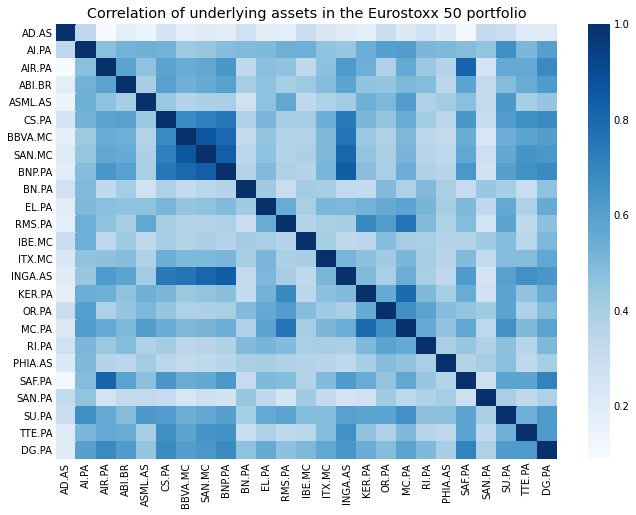

In [127]:
%matplotlib inline
# Calculate log normal daily returns for all assets
daily_returns = np.log(asset_prices).diff().dropna()
# Calculate 1-month annualized volatilities for every asset in portfolio
monthly_vols = pd.DataFrame({
    'Monthly (annualized) Volatility': round(100*daily_returns[-21:].std()*(252)**0.5,2)
})
# Calculate 1-month daily volatilities
vols = pd.DataFrame({
    'Daily Volatility': round(100*daily_returns[-21:].std(),2)
})
# Estimate correlations of underlying assets
corrMatrix = daily_returns.corr()
plt.figure(figsize=(10,8))
sn.heatmap(corrMatrix, annot=False, cmap='Blues')
plt.title('Correlation of underlying assets in the Eurostoxx 50 portfolio')
plt.show()

Hierarchical clustering is a great tool to visualize how assets interact together with the portfolio. Based on historical correlations, we can distinguish 3 main classes within the portfolio, which are quite desorganized and bushy to the exception of the green/blue one on the right.

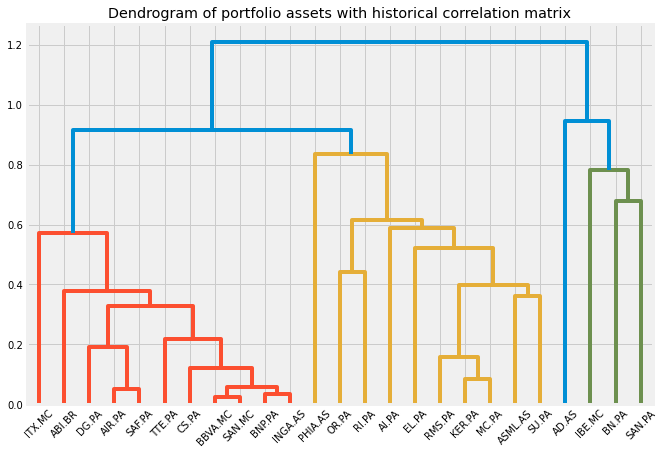

In [128]:
# Estimate the dendogram of underlying assets
plt.figure(figsize=(10, 7))  
plt.title('Dendrogram of portfolio assets with historical correlation matrix')  
z_historical = sch.linkage(corrMatrix.values, method='average', metric='correlation')
dendrogram_historical = sch.dendrogram(z_historical, labels=corrMatrix.columns)  
plt.show()

### Theory-Implied Correlation (TIC) matrix

In 2019, Marcos López de Prado proposed a methodology to estimate Theory-Implied Correlation (TIC) matrices. **TIC methodology introduces a machine learning algorithm to estimate forward-looking correlation matrices implied by economic theory**. Given a particular theoretical representation of the hierarchical structure that governs a universe of securities, **the method fits the correlation matrix that complies with that theoretical representation of the future**. 

https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3484152

**The objective is to obtain the Theory-Implied Correlation (TIC) matrix in the case of our investment portfolio of 25 assets. The code below allows to derive the TIC matrix from the historical matrix and is adapted from Lopez paper** - available in link above. Getting the TIC matrix is the first key step in our attempt to obtain forward-looking portfolio risk measures.

In [96]:
# Adapted from 'ESTIMATION OF THEORY-IMPLIED CORRELATION MATRICES' 2019 paper from Marcos López de Prado

def getLinkage_corr(tree, corr):
    if len(np.unique(tree.iloc[:,-1]))>1:
        tree['All']=0 # add top level
    lnk0=np.empty(shape=(0,4))
    lvls=[[tree.columns[i-1],tree.columns[i]] for i in range(1,tree.shape[1])]
    dist0=((1-corr)/2.)**.5 # distance matrix
    items0=dist0.index.tolist() # map lnk0 to dist0
    for cols in lvls:
        grps=tree[cols].drop_duplicates(cols[0]).set_index(cols[0]).groupby(cols[1])
        
        for cat,items1 in grps:
            items1=items1.index.tolist()
            if len(items1)==1: # single item: rename
                items0[items0.index(items1[0])]=cat
                dist0=dist0.rename({items1[0]:cat},axis=0)
                dist0=dist0.rename({items1[0]:cat},axis=1)
                continue
            dist1=dist0.loc[items1,items1]

            lnk1=sch.linkage(ssd.squareform(dist1,force='tovector',
                                            checks=(not np.allclose(dist1,dist1.T))),
                                            optimal_ordering=True) # cluster that cat
            lnk_=linkClusters(lnk0,lnk1,items0,items1)
            lnk0=np.append(lnk0,lnk_,axis=0)
            items0+=range(len(items0),len(items0)+len(lnk_))
            dist0=updateDist(dist0,lnk0,lnk_,items0)
            # Rename last cluster for next level
            items0[-1]=cat
            dist0.columns=dist0.columns[:-1].tolist()+[cat]
            dist0.index=dist0.columns
        
    lnk0=np.array([tuple(i) for i in lnk0],dtype=[('i0',int),('i1',int), \
                    ('dist',float),('num',int)])    
    return lnk0

# Explain
def linkClusters(lnk0,lnk1,items0,items1):
    # transform partial link1 (based on dist1) into global link0 (based on dist0)
    nAtoms=len(items0)-lnk0.shape[0]
    lnk_=lnk1.copy()
    for i in range(lnk_.shape[0]):
        i3=0
        for j in range(2):
            if lnk_[i,j]<len(items1):
                lnk_[i,j]=items0.index(items1[int(lnk_[i,j])])
            else:
                lnk_[i,j]+=-len(items1)+len(items0)
            # update number of items
            if lnk_[i,j]<nAtoms:
                i3+=1
            else:
                if lnk_[i,j]-nAtoms<lnk0.shape[0]:
                    i3+=lnk0[int(lnk_[i,j])-nAtoms,3]
                else:
                    i3+=lnk_[int(lnk_[i,j])-len(items0),3]
        lnk_[i,3]=i3
    return lnk_

# Explain
def updateDist(dist0,lnk0,lnk_,items0,criterion=None):
    # expand dist0 to incorporate newly created clusters
    nAtoms=len(items0)-lnk0.shape[0]
    newItems=items0[-lnk_.shape[0]:]
    for i in range(lnk_.shape[0]):
        i0,i1=items0[int(lnk_[i,0])],items0[int(lnk_[i,1])]
        if criterion is None:
            if lnk_[i,0]<nAtoms:
                w0=1.
            else:   
                w0=lnk0[int(lnk_[i,0])-nAtoms,3]
            if lnk_[i,1]<nAtoms:
                w1=1.
            else:
                w1=lnk0[int(lnk_[i,1])-nAtoms,3]
            dist1=(dist0[i0]*w0+dist0[i1]*w1)/(w0+w1)
        else:
            dist1=criterion(dist0[[i0,i1]],axis=1) # linkage criterion
        dist0[newItems[i]]=dist1 # add column
        dist0.loc[newItems[i]]=dist1 # add row
        dist0.loc[newItems[i],newItems[i]]=0. # main diagonal
        dist0=dist0.drop([i0,i1],axis=0)
        dist0=dist0.drop([i0,i1],axis=1)
    return dist0

# Explain
def getAtoms(lnk,item):
    # get all atoms included in an item
    anc=[item]
    while True:
        item_=max(anc)
        if item_<=lnk.shape[0]:
            break
        else:
            anc.remove(item_)
            anc.append(lnk['i0'][item_-lnk.shape[0]-1])
            anc.append(lnk['i1'][item_-lnk.shape[0]-1])
    return anc

# Explain
def link2corr(lnk, lbls):
    # derive the correl matrix associated with a given linkage matrix
    corr=pd.DataFrame(np.eye(lnk.shape[0]+1),index=lbls,columns=lbls,
                        dtype=float)
    for i in range(lnk.shape[0]):
        x=getAtoms(lnk,lnk['i0'][i])
        y=getAtoms(lnk,lnk['i1'][i])
        corr.loc[lbls[x],lbls[y]]=1-2*lnk['dist'][i]**2 # off-diagonal values
        corr.loc[lbls[y],lbls[x]]=1-2*lnk['dist'][i]**2 # symmetry
    return corr

# Explain
def corrDist(corr0,corr1):
    num=np.trace(np.dot(corr0,corr1))
    den=np.linalg.norm(corr0,ord='fro')
    den*=np.linalg.norm(corr1,ord='fro')
    cmd=1-num/den
    return cmd

**Part of the transformation required from Lopez to obtain the TIC matrix require the GICS sector, sub-sector and industry information for all underlying assets in the portfolio**. This information is available from Yahoo finance and has been summarized in an Excel.

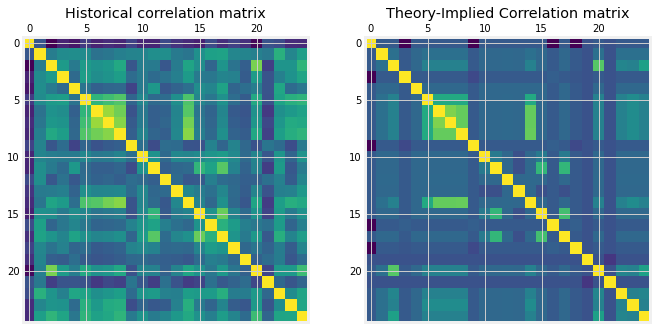

In [129]:
# Calculate Theory-Implied correlation matrix
gics = pd.read_csv('C:/Users/zacha/OneDrive/Desktop/CQF/Project/GICS - ES.csv')
lnk0 = getLinkage_corr(gics,corrMatrix)
TIC_Matrix = link2corr(lnk0,corrMatrix.index)
# Correlation  matrix before and after
fig, (ax0,ax1) = plt.subplots(1,2,figsize=(10,6))
ax0.matshow(corrMatrix)
ax1.matshow(TIC_Matrix)
ax0.set_title('Historical correlation matrix')
ax1.set_title('Theory-Implied Correlation matrix')
plt.show()

The effect of transforming the historical (backward-looking) correlation matrix into the TIC (forward-looking) matrix is well illustrated on the figure above. Correlations between assets are significantly less noisy and appear much better organized. The TIC matrix now fits the correlation matrix that complies with that theoretical representation of the
future, based on historical correlations and GICS information.

The dendogram derived from the forward-looking TIC matrix also illustrates a much simpler dependence structure between the underlying assets of our investment portfolio.

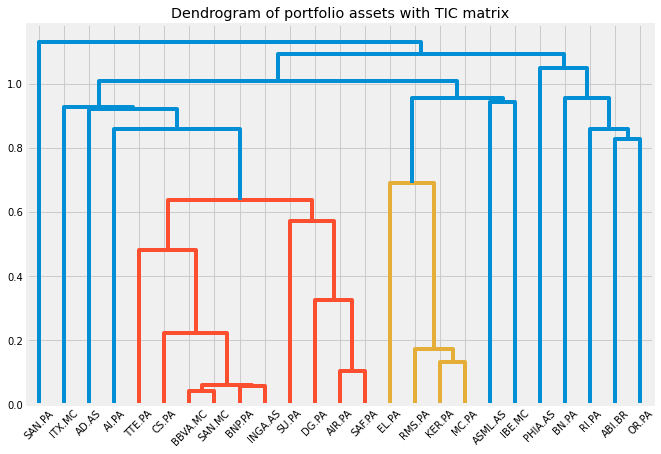

In [130]:
# Estimate the dendogram of underlying assets
plt.figure(figsize=(10, 7))
plt.title('Dendrogram of portfolio assets with TIC matrix')  
z_TIC = sch.linkage(TIC_Matrix.values, method='average', metric='correlation')
dendrogram_TIC = sch.dendrogram(z_TIC, labels=TIC_Matrix.columns)  
plt.show()

### Denoise the TIC matrix

The second step now consists in **denoising the TIC matrix, e.g. remove any information or activity that confuses or misrepresents genuine underlying trends**.

In [103]:
def denoise_matrix(matrix, threshold, sort=True, real=True):
    # Find Eigen values in the correlation matrix
    eigen_values, eigen_vectors = np.linalg.eigh(matrix)
    if sort:
        idx = eigen_values.argsort()[::-1]
        eigen_values = eigen_values[idx]
        eigen_vectors = eigen_vectors[:, idx]
    if real:
        eigen_vectors = eigen_vectors.real
        eigen_values = eigen_values.real
    # Improve Eigen Values by setting a threshold
    improved_eigen_values = eigen_values.copy()
    improved_eigen_values[-threshold:] = np.mean(improved_eigen_values[-threshold:])
    # Rebuilding the denoised correlation matrix
    corr = np.dot(eigen_vectors, improved_eigen_values[:, np.newaxis] * eigen_vectors.T)
    # Fix numerical issues
    corr[corr < -1] = -1
    corr[corr > 1] = 1
    np.fill_diagonal(corr, 1.0)
    return corr

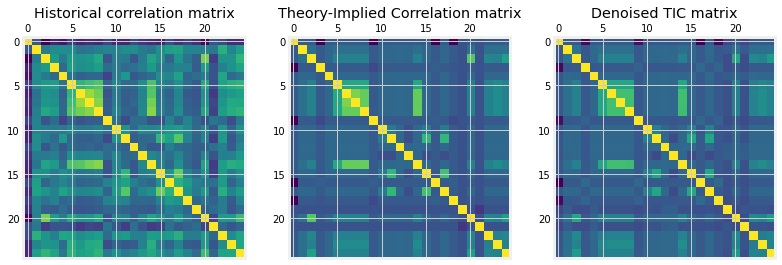

In [108]:
# Calculate the denoised TIC matrix
denoised_TIC_Matrix = pd.DataFrame(denoise_matrix(TIC_Matrix,20), columns=TIC_Matrix.columns)
# Plot correlations
fig, (ax0,ax1,ax2) = plt.subplots(1,3,figsize=(12,10))
ax0.matshow(corrMatrix)
ax1.matshow(TIC_Matrix)
ax2.matshow(denoised_TIC_Matrix)
ax0.set_title('Historical correlation matrix')
ax1.set_title('Theory-Implied Correlation matrix')
ax2.set_title('Denoised TIC matrix')
plt.show()

The effect of denoising on the correlation structure is striking on the dendogram, as the relationships between assets are now much clearer and more organized.

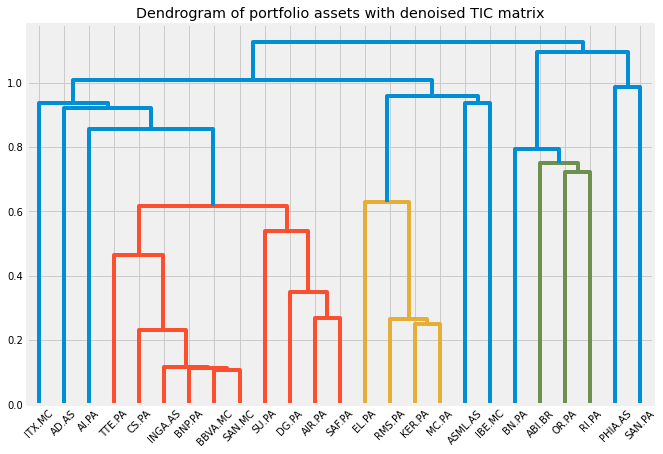

In [131]:
# Estimate the dendogram of underlying assets
plt.figure(figsize=(10, 7))  
plt.title("Dendrogram of portfolio assets with denoised TIC matrix")  
z_denoisedTIC = sch.linkage(denoised_TIC_Matrix.values, method='average', metric='correlation')
dendrogram_denoisedTIC = sch.dendrogram(z_denoisedTIC, labels=denoised_TIC_Matrix.columns)  
plt.show()

Finally, looking at the distances between all three matrices produces results which are in line of the observations: 
- TIC matrix and denoised TIC matrix are very similar
-  TIC matrix and denoised TIC matrix are also different from the historical correlation matrix, which is significantly more noisy and desorganized.

In [111]:
# Estimate distances between the three matrices
print(f'Distance between historical and TIC matrices: {corrDist(corrMatrix,TIC_Matrix):.2%}')
print(f'Distance between historical and denoised TIC matrices: {corrDist(corrMatrix,denoised_TIC_Matrix):.2%}')
print(f'Distance between TIC and denoised TIC matrices: {corrDist(TIC_Matrix,denoised_TIC_Matrix):.2%}')

Distance between historical and TIC matrices: 1.94%
Distance between historical and denoised TIC matrices: 1.98%
Distance between TIC and denoised TIC matrices: 0.03%


### Forward-looking portfolio Value-at-Risk

At this stage, we moved from a backward-looking historical correlation matrix to a forward-looking (denoised theory implied) correlation matrix: **we now have a view on correlations in the future** for the underlying assets of our investment portfolio. To estimate the portfolio risk measures, we need to estimate the denoised theory implied covariance matrix in a first place, and then run a Monte-Carlo simulations with many paths to assess the risk measures in a second place. 

**Risk measures are the result of 10,000 Monte-Carlo simulations on an horizon of one month at 99% confidence level. Risk measures are estimated according to three scenarios**. A first scenario computes the risk measures based on historical volatilities and historical correlations only. A second scenario computes the risk measures with historical volatilities and denoised TIC matrix. Finally, a third scenario computes the risk measures with GRU stressed volatilities and denoised TIC matrix.

In order for the Cholesky decomposition to work in order to compute Monte-Carlo VaR and Expected Shortfall, the covariance matrix must be positive semi-definite. Therefore, we compute the denoised theory-implied covariance matrix by the matrix product between realized volatilities and denoised TIC matrix. We then check that the output matrix is positive semi-definite. In case it is not, it is its closest semi-definite version which is taken as input for the calculation of risk measures.

In [112]:
# Ensure the covariance matrix is positive semi-definite
def get_near_psd(A):
    C = (A + A.T)/2
    eigval, eigvec = np.linalg.eig(C)
    eigval[eigval < 0] = 0
    return eigvec.dot(np.diag(eigval)).dot(eigvec.T)

#### Base scenario

The base scenario consists in calculating portfolio risk measures based on realized volatilities and historical correlation matrix in order to have anchor values to refer to.

In [121]:
# Monte-Carlo set-up and parameters
MC_sims = 10000
horizon = 30
weights = weights.flatten()
hist_cov = np.cov(np.transpose(daily_returns))
mean = np.mean(daily_returns[-21:], axis=0)
Mean_matrix = np.full((horizon,len(weights)),mean)
mean_matrix = np.transpose(Mean_matrix)
portfolio_sims = np.full((horizon,MC_sims),0.)

# Monte-Carlo VaR simulation
np.random.seed(100)
for i in range(0,MC_sims):
    Z = np.random.normal(size=len(weights)*horizon)
    Z = Z.reshape((len(weights),horizon))
    L = np.linalg.cholesky(hist_cov)
    forecasts = mean_matrix + np.inner(L,np.transpose(Z))
    portfolio_sims[:,i] = np.cumprod(np.inner(weights,np.transpose(forecasts)) + 1)

# VaR computation at 99% confidence level
alpha = 0.99   # confidence level
# Porfolio Returns statistics on the 30th day
print('Monte-Carlo portfolio VaR (99%, 1 month): {:.1%}'.format(np.quantile(portfolio_sims[-1]-1,1-alpha)))
print('Monte-Carlo portfolio CVaR (99%, 1 month): {:.1%}'.format(-(1-portfolio_sims[-1][portfolio_sims[-1] <= np.quantile(portfolio_sims[-1],1-alpha)].mean())))

Monte-Carlo portfolio VaR (99%, 1 month): -23.0%
Monte-Carlo portfolio CVaR (99%, 1 month): -24.8%


#### Denoised TIC scenario

The denoised TIC scenario consists in producing portfolio risk measures derived from realized volatilities and denoised TIC matrix. **As we compute the TIC covariance matrix in this step, we also check that the forward-looking covariance matrix that we use as input is positive semi-definite**. In case it is not, the closest positive semi-definite covariance matrix is taken for the risk calculation.

In [115]:
# Create volatility matrix
volatilities = vols.values.flatten()
vols_matrix = np.zeros((vols.shape[0], vols.shape[0]), int)
row,col = np.diag_indices(vols_matrix.shape[0])
vols_matrix[row,col] = volatilities
vols_matrix = vols_matrix/100
volatilities = vols.values.flatten()
# Calculate the covariance matrix
cov = multi_dot([vols_matrix.T, denoised_TIC_Matrix, vols_matrix])
# Approximate the covariance matrix to its nearest positive semi definite version if it is not the case
cov = get_near_psd(cov)
# Check the shape of the covariance matrix
print(f'Shape of the denoised TIC covariance matrix: {cov.shape}')

Shape of the denoised TIC covariance matrix: (25, 25)


In [122]:
# Monte-Carlo set-up and parameters
MC_sims = 10000
horizon = 30
weights = weights.flatten()
mean = np.mean(daily_returns[-21:], axis=0)
Mean_matrix = np.full((horizon,len(weights)),mean)
mean_matrix = np.transpose(Mean_matrix)
portfolio_sims = np.full((horizon,MC_sims),0.)

# Monte-Carlo VaR simulation
np.random.seed(100)
for i in range(0,MC_sims):
    Z = np.random.normal(size=len(weights)*horizon)
    Z = Z.reshape((len(weights),horizon))
    L = np.linalg.cholesky(cov)
    L = np.transpose(L)
    forecasts = mean_matrix + np.inner(L,np.transpose(Z))
    portfolio_sims[:,i] = np.cumprod(np.inner(weights,np.transpose(forecasts)) + 1)

# VaR computation at 99% confidence level
alpha = 0.99   # confidence level
# Porfolio Returns statistics on the 30th day
print('Monte-Carlo portfolio VaR (99%, 1 month): {:.2%}'.format(np.quantile(portfolio_sims[-1]-1,1-alpha)))
print('Monte-Carlo portfolio CVaR (99%, 1 month): {:.2%}'.format(-(1-portfolio_sims[-1][portfolio_sims[-1] <= np.quantile(portfolio_sims[-1],1-alpha)].mean())))

Monte-Carlo portfolio VaR (99%, 1 month): -17.58%
Monte-Carlo portfolio CVaR (99%, 1 month): -18.62%


#### GRU denoised TIC scenario

In this last scenario, we incorporate both the denoised TIC matrix as well as the GRU volatility spread predictions. More precisely, 1-month realized volatitilies of portfolio underlying assets incorporate the result of the GRU volatility prediction model: 
- If the GRU model predicts a positive RV-IV spread, volatilities are increased by 25% to reflect the increase in volatility coming on the next trading day. 
- If the GRU predicts a negative RV-IV spread, then historical volatilities are taken as true estimates of present volatility.

Of course, the 25% factor to reflect the upcoming higher volatility on the next trading would need to be properly calibrated with a backtest if implemented in real life. What we want to illustrate here is the proof of concept and the feasability of the approach, e.g. that we can derive forward-looking risk measures.

In [123]:
# Assume a value for the model prediction in volatility for the next trading day
GRU_volatility_prediction = 1

# Quantify a prediction penalty factor 
if GRU_volatility_prediction == 1:
    # GRU model predicts that the realized volatility will exceed the implied volatility on the next trading day
    pred_factor = 0.25
else:
    pred_factor = 0

# Monte-Carlo set-up and parameters
MC_sims = 10000
horizon = 30
weights = weights.flatten()
mean = np.mean(daily_returns[-21:], axis=0)
Mean_matrix = np.full((horizon,len(weights)),mean)
mean_matrix = np.transpose(Mean_matrix)
portfolio_sims = np.full((horizon,MC_sims),0.)

# Monte-Carlo VaR simulation
np.random.seed(100)
for i in range(0,MC_sims):
    Z = np.random.normal(size=len(weights)*horizon)
    Z = Z.reshape((len(weights),horizon))
    L = np.linalg.cholesky(cov)
    L = np.transpose(L)*(1+pred_factor)
    forecasts = mean_matrix + np.inner(L,np.transpose(Z))
    portfolio_sims[:,i] = np.cumprod(np.inner(weights,np.transpose(forecasts)) + 1)

# VaR computation at 99% confidence level
alpha = 0.99   # confidence level
# Porfolio Returns statistics on the 30th day
print('Monte-Carlo portfolio VaR (99%, 1 month): {:.2%}'.format(np.quantile(portfolio_sims[-1]-1,1-alpha)))
print('Monte-Carlo portfolio CVaR (99%, 1 month): {:.2%}'.format(-(1-portfolio_sims[-1][portfolio_sims[-1] <= np.quantile(portfolio_sims[-1],1-alpha)].mean())))

Monte-Carlo portfolio VaR (99%, 1 month): -19.61%
Monte-Carlo portfolio CVaR (99%, 1 month): -20.86%


**An efficient risk management framework must be guided by a forward-looking view, in order to rely and communicate on accurate forecasts of the risks coming ahead**. In that regards, the denoised TIC and GRU volatility prediction model can help: the latter indicates the direction of the volatility of the next trading day, whether it will be above or below what the market expects. The former proposes a correlation structure that complies with a theoretical representation of the future. In this manner, **a forward-looking view on volatilities and correlations can be factored into a forward-looking covariance matrix, which can later be used as support to the calculation of forward-looking risk measures**.

Scenarios 2 and 3 result in lower risk measures than scenario 1, which is simply derived from historical volatilities and correlations. Nevertheless, this result does not invalidate the model, but the contrary, inasmuch as it reflects the model predictions of normal volatility and weaker correlations to come. 

The approach developed in section 8 of this notebook shows several advantages: **Beyond offering a forward-looking estimation of portfolio risk, it gives an ideal stress-testing framework in order to build scenario analysis. The denoised TIC matrix and volatilities can be stressed to reflect the expectations of risk managers for plausible economic and financial scenarios**. The stress-testing volatility factor of 25% adopted earlier is simply taken as a proof of concept and would need more agile calibration to reflect a more realistic situation. Forward-looking correlation matrices could also be derived with another approach than TIC, as, for instance, get the implied correlations by calibrating a model using market prices of correlation-dependent derivatives in same way implied volatilities are obtained from option quotes. This approach has certainly less available data than the TIC approach (which relies on historical data at start), but has the benefit of being forward-looking too.